# NPR MC1 RAG

Autoren:
- Michelle Rohrer
- Léonie Bécheiraz
- Sabina Gruener

### Libraries  

Falls mit einer `venv` gearbeitet wird, muss die `venv` aktiviert sein. Dies kann über den Befehl `venv\\Scripts\\activate` ausgeführt werden.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datasets import Dataset

import langdetect
import re

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from collections import Counter
from collections import OrderedDict
from langdetect import detect

import torch

import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../"))
import src.utilities as u
import src.plots as p
import src.constants as c
c_stopwords = c.custom_stopwords

from src.utilities import TextCleaner
from src.credentials import AZURE_OPENAI_API_KEY, AZURE_OPENAI_ENDPOINT
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings


from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import chromadb
from src.evaluation import RAGAS_Evaluator

from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.runnables import RunnableLambda
from langchain_core.documents import Document
from langchain.schema.runnable import RunnableMap

from langchain_core.prompts import ChatPromptTemplate


from ragas.metrics import faithfulness, answer_relevancy, context_precision
from ragas import evaluate
from datasets import Dataset
from difflib import SequenceMatcher

u.generate_toc('../doc/MC1.ipynb')

#Inhaltsverzeichnis

- [NPR MC1 RAG](#npr-mc1-rag)
    - [Libraries](#libraries)
  - [Kurzbeschreibung:](#kurzbeschreibung)
    - [Hinweis:](#hinweis)
    - [Sources](#sources)
  - [EDA](#eda)
    - [Daten kennen lernen](#daten-kennen-lernen)
    - [Daten Laden](#daten-laden)
      - [Datenbeschreibung](#datenbeschreibung)
    - [Untersuchen der ersten Erkenntnisse](#untersuchen-der-ersten-erkenntnisse)
      - [Artikel pro Domain](#artikel-pro-domain)
      - [Analyse: Anzahl Artikel pro Domain](#analyse-anzahl-artikel-pro-domain)
        - [Top-Domains mit hoher Artikelanzahl](#top-domains-mit-hoher-artikelanzahl)
        - [Verteilungsmuster und Interpretation](#verteilungsmuster-und-interpretation)
        - [Mögliche Ursachen für die ungleiche Verteilung](#mögliche-ursachen-für-die-ungleiche-verteilung)
      - [Anzahl Artikel zu Top-Titel](#anzahl-artikel-zu-top-titel)
      - [Anzahl pro Domain mit dem Titel 'About David J. Cross'](#anzahl-pro-domain-mit-dem-titel-about-david-j-cross)
      - [Anzahl Artikel pro Top-Datum](#anzahl-artikel-pro-top-datum)
      - [Anzahl pro Domain zum Datum vom 13.06.2023](#anzahl-pro-domain-zum-datum-vom-13062023)
      - [Duplikate beim Artikel?](#duplikate-beim-artikel)
      - [Welches sind die meist benutzten Worte?](#welches-sind-die-meist-benutzten-worte)
    - [Sprache überprüfen](#sprache-überprüfen)
    - [Text Bereinigen](#text-bereinigen)
      - [Klasse `TextCleaner`](#klasse-textcleaner)
    - [Duplikate entfernen](#duplikate-entfernen)
      - [Titel und Inhalt-Längen](#titel-und-inhalt-längen)
      - [Gesamten Text bereinigen](#gesamten-text-bereinigen)
    - [Wordcloud 2.0](#wordcloud-20)
    - [Titel an den Content anfügen](#titel-an-den-content-anfügen)
    - [Datensatz mit 1000 Zeilen](#datensatz-mit-1000-zeilen)
  - [Chunking](#chunking)
  - [Tokenisierung](#tokenisierung)
  - [Embeddings](#embeddings)
  - [Chroma Daten](#chroma-daten)
      - [Übersicht der Konfigurationen](#übersicht-der-konfigurationen)
      - [Detaillierte Parameterbeschreibung](#detaillierte-parameterbeschreibung)
        - [1. Embedding-Modell](#1-embedding-modell)
        - [2. TextSplitter](#2-textsplitter)
        - [3. Ähnlichkeitsmetriken (`hnsw:space`)](#3-ähnlichkeitsmetriken-hnswspace)
        - [4. Konstant gehaltene Parameter](#4-konstant-gehaltene-parameter)
      - [Fazit](#fazit)
  - [Retrieval-Modul (Suche & Ranking) & Generator-Modul (Antwortgenerierung)](#retrieval-modul-suche--ranking--generator-modul-antwortgenerierung)
    - [Ablauf der RetrievalQA-Evaluations-Chain](#ablauf-der-retrievalqa-evaluations-chain)
    - [Varianten im Retrieval](#varianten-im-retrieval)
    - [Weitere Parameter:](#weitere-parameter)
    - [Output:](#output)
  - [Evaluator-Modul (Qualitätsprüfung & Optimierung)](#evaluator-modul-qualitätsprüfung--optimierung)
    - [Evaluierte Metriken](#evaluierte-metriken)
    - [Durchführung des Experiments](#durchführung-des-experiments)
    - [Evaluierung Embeddings](#evaluierung-embeddings)
    - [Embedding Evaluation: Übersicht der Mittelwerte](#embedding-evaluation-übersicht-der-mittelwerte)
    - [Evaluierung Retrieval](#evaluierung-retrieval)
    - [Retriever- und Prompt-Kombinationen: Übersicht der Mittelwerte](#retriever--und-prompt-kombinationen-übersicht-der-mittelwerte)
    - [Evaluierung Temperatur](#evaluierung-temperatur)
    - [Temperature Evaluation: Übersicht der Mittelwerte](#temperature-evaluation-übersicht-der-mittelwerte)
    - [Manuell plausability Check](#manuell-plausability-check)
  - [Fazit](#fazit)
    - [Empfohlene ausgewogene Systemkonfiguration:](#empfohlene-ausgewogene-systemkonfiguration)
  - [Weitere Überlegungen](#weitere-überlegungen)

## Kurzbeschreibung:

Die Mini-Challenge befasst sich mit der Konzeption, Implementierung und Evaluierung eines Retrieval-Augmented-Generation-(RAG)-Systems. Ziel dieses Systems ist es, die Leistungsfähigkeit eines Sprachmodells durch die Integration externer Wissensquellen zu erweitern, um präzisere und kontextuell fundierte Antworten zu generieren. Im Rahmen der Challenge sind die Teilnehmenden dazu aufgefordert, zentrale Systemkomponenten – darunter Module zur Datenaufnahme, zum Information Retrieval sowie zur Textgenerierung – zu entwickeln und hinsichtlich ihrer Leistungsfähigkeit zu überprüfen. Die Evaluation erfolgt sowohl durch automatische Bewertungsverfahren als auch durch manuelle Qualitätsbeurteilungen. Übergeordnetes Ziel ist es, das Verständnis für Methoden der natürlichen Sprachverarbeitung (Natural Language Processing, NLP) zu vertiefen und die praktischen Kompetenzen in der Entwicklung und Bewertung fortgeschrittener Sprachsysteme zu stärken.

### Hinweis:

Für die vollständige Ausführung des Projekts ist die vorherige Installation sämtlicher in der Datei `requirements.txt` aufgeführter Abhängigkeiten erforderlich. Darüber hinaus muss sich das Projekt lokal auf dem System befinden. Die generierten Embeddings sind im lokalen Projektordner im Verzeichnis `src` abzulegen, um eine fehlerfreie Ausführung sicherzustellen.

### Sources

**GitHub Repository Structure (Best Practices)**

- [GitHub Repository Structure Best Practices | by Soulaiman Ghanem | Code Factory Berlin | Medium](https://medium.com/code-factory-berlin/github-repository-structure-best-practices-284f1d93b75a)

**Notebooks ohne Output pushen (Vermeidung von Merge-Konflikten)**

- [Jupyter Notebook: Remove output before git push (Gist)](https://gist.github.com/33eyes/431e3d432f73371509d176d0dfb95b6e)

**Jupyter Book erstellen (HTML oder PDF)**

- [Jupyter Book - Getting Started](https://jupyterbook.org/en/stable/start/build.html)

**Retrieval-Augmented Generation (RAG) – Beispiel**

- [LangChain RAG from Scratch (GitHub)](https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb)

**Chunking und Tokenization**

- [5 Levels of Text Splitting (GitHub)](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)
- [5 Chunking Strategies for RAG (Blog)](https://blog.dailydoseofds.com/p/5-chunking-strategies-for-rag)
- [Chunkviz - Visualisierung](https://chunkviz.up.railway.app/)
- [OpenAI Tokenizer](https://platform.openai.com/tokenizer)
- [What is Tokenization? (DataCamp Blog)](https://www.datacamp.com/blog/what-is-tokenization)

**Chroma DB**

- [LangChain ChromaDB Integration](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
- [ChromaDB Tutorial (Real Python)](https://realpython.com/chromadb-vector-database/)

**Wordcloud & NLTK**

- [Python Word Clouds Tutorial (DataCamp)](https://www.datacamp.com/tutorial/wordcloud-python)
- [NLTK :: Installing NLTK Data](https://www.nltk.org/data.html)

**RAG Evaluation (Video und Beispiel)**

- [RAG Evaluation - YouTube](https://www.youtube.com/watch?v=mEv-2Xnb_Wk)
- [Colab Notebook zur RAG-Evaluation](https://colab.research.google.com/drive/1TZo2sgf1YFzI4_U-tGppg_ylHAR3MXF_?usp=sharing)


## EDA



### Daten kennen lernen

Um den Datensatz kennen zu lernen und dabei die verschiedenen Technologien im Zusammenhang mit textuellen Daten und Modellen zu verstehen, werden wir verschiedene Pakete anwenden.

Inhalt:
- `langdetect`
- `Counter`
- `TextCleaner`
- `WordCloud`

### Daten Laden

Die Daten, welche wir aus einer `.csv` Datei laden, welche von einer Website stammen. Mit diesen Daten möchten wir später unsere Fragen beantworten.

#### Datenbeschreibung
- **id** Unique ID des Artikels
- **title** Title des Artikels
- **date** Erscheinungsdatum des Artikels
- **author** Name des Autors
- **content** Inhalt des Artikels
- **domain** von wo der Artikel kommt
- **url** Webadresse (wie man den Artikel finden kann)

In [3]:
file_path = "../data_mc1/"
file_name_train = 'cleantech_media_dataset_v3_2024-10-28.csv'

column_names = ["id", "title", "date", "author", "content", "domain", "url"]
df_train = pd.read_csv(file_path+file_name_train, delimiter=",", names=column_names, skiprows=1, encoding="utf-8")
df_train.head()

id                                              title        date  \
0  93320          XPeng Delivered ~100,000 Vehicles In 2021  2022-01-02   
1  93321      Green Hydrogen: Drop In Bucket Or Big Splash?  2022-01-02   
2  98159  World’ s largest floating PV plant goes online...  2022-01-03   
3  98158  Iran wants to deploy 10 GW of renewables over ...  2022-01-03   
4  31128  Eastern Interconnection Power Grid Said ‘ Bein...  2022-01-03   

   author                                            content           domain  \
0     NaN  ['Chinese automotive startup XPeng has shown o...    cleantechnica   
1     NaN  ['Sinopec has laid plans to build the largest ...    cleantechnica   
2     NaN  ['Huaneng Power International has switched on ...      pv-magazine   
3     NaN  ['According to the Iranian authorities, there ...      pv-magazine   
4     NaN  ['Sign in to get the best natural gas news and...  naturalgasintel   

                                                 url  
0  https://cleantechnica.com/2022/01/02/xpeng-del...  
1  https://cleantechnica.com/2022/01/02/its-a-gre...  
2  https://www.pv-magazine.com/2022/01/03/worlds-...  
3  https://www.pv-magazine.com/2022/01/03/iran-wa...  
4  https://www.naturalgasintel.com/eastern-interc...

In [4]:
u.missing_value_stats(df_train)

NaN/None (%)  0-Werte (%)
id                0.0          0.0
title             0.0          0.0
date              0.0          0.0
author          100.0          0.0
content           0.0          0.0
domain            0.0          0.0
url               0.0          0.0

Der Spalte **author ist vollständig fehlend**, nach Ansehen des Artikels ist schnell ersichtlich, dass dieser über Webscraping aus den Artikeln extrahiert werden könnte. Da aber in den Evaluierungsdaten keine Frage bezüglich des Authors vorhanden ist wird diese nun entfernt. Allerdings könnte diese Information Wert liefern im Bezug auf Ähnlichkeitsberechnung von Inhalten der Artikeln, dies könnte später erneut überprüft werden. **Vorerst wird die Spalte author erntfernt.**

In [5]:
df_train = df_train.drop(columns=["author"])
df_train.dtypes

id          int64
title      object
date       object
content    object
domain     object
url        object
dtype: object

Nachdem die offensichtlichen Bereinigungen vorgenommen wurden, möchten wir einen Überblick über wichtigsten Metriken. 

Dabei werden die Objekt-Spalten in folgenden Kategorien angezeigt:

- `count`: Anzahl der nicht-leeren Werte

- `unique`: Anzahl der einzigartigen Werte

- `top`: Der am häufigsten vorkommende Wert

- `freq`: Die Häufigkeit dieses Wertes

Wir fügen den Zeilenumbruch für die Ausgabe ein, damit der gesamte Text sichtbar wird.

In [6]:
styled = (
    df_train.describe(include=[object])
    .applymap(u.shorten_text)  # auf alle Zellen anwenden
    .style
    .set_properties(**{
        'white-space': 'pre-wrap',    # \n sichtbar
        'max-width': '300px',         # Zellbreite beschränken
        'font-family': 'monospace',   # bessere Darstellung
    })
)

styled

Wir sehen nun, dass:
- **Total Reihen** es sind 20111 Reihen vorhanden
- **title** die meisten Artikel haben ihren eigenen Titel 
- **date** es sind nur 979 Datum vorhanden, was im Umkehrschluss bedeutet, dass mehrere Artikel das gleiche Datum tragen
- **content** es sind mehr einzigartige Artikel vorhanden als Titel. Die Einzigartigkeit könnte auch mit der Darstellung der Website zusammen hängen. Daher kann es sein, dass nach der Bereinigung des Textes mehrere Artikel gleich sind als jetzt.
- **domain** es gibt nur 25 verschiedene Domains was wiederum bedeutet, dass diese Domains sehr viele Artikel enthalten
- **url** jede Zeile stammt von einer anderen url.
- **top** diese Information sagt uns welcher Titel (About David J. Cross), Artikel, welche Domain (enery-xprt), url oder welches Datum (13.08.2023) am häufigsten vorkommt und somit wo und wie wir nach dieser Häufigkeit suchen müssen

**Anpassen der Datentypen**  

id: int64 -> bleibt int64  
title: object -> string  
date: object -> datetime  
content: object -> string  
domain: object -> string  
url: object -> string  

Datumsformat erstellen

In [7]:
# Datentypen korrigieren
df_train["date"] = pd.to_datetime(df_train["date"], errors="coerce")  # Falls ungültige Datumswerte vorhanden

df_train.dtypes

id                  int64
title              object
date       datetime64[ns]
content            object
domain             object
url                object
dtype: object

### Untersuchen der ersten Erkenntnisse
Die ersten Erkenntnisse möchten wir nun genauer unter die Lupe nehmen und einige Analysen über die Top-Werte erstellen.

#### Artikel pro Domain

Als erstes werden wir schauen, wieviele Artikel pro Domain vorhanden sind. Dazu zählen wir die Artikel pro Domain.

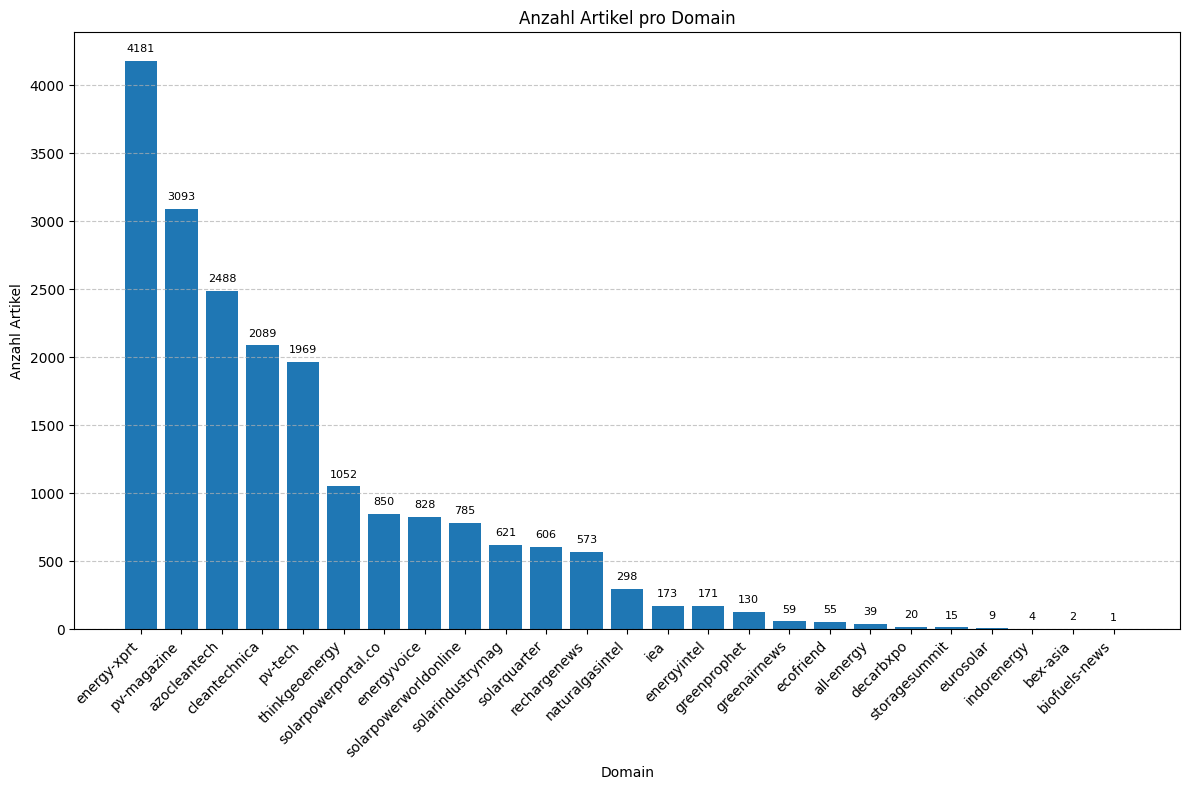

In [8]:
articles_per_domain = df_train.groupby("domain").size().reset_index(name="count")
articles_per_domain = articles_per_domain.sort_values(by="count", ascending=False)
articles_per_domain.reset_index(drop=True, inplace=True)
p.bar_plot(articles_per_domain, "domain", "count", "Anzahl Artikel pro Domain", "Domain", "Anzahl Artikel", xrotation=45, ha_xrotation='right')

#### Analyse: Anzahl Artikel pro Domain

Das Balkendiagramm mit dem Titel **„Anzahl Artikel pro Domain“** zeigt, wie stark die Artikelverteilung auf bestimmte Domains konzentriert ist. Die Daten stammen offenbar aus dem Bereich erneuerbare Energien oder technologische Fachportale.

---

##### Top-Domains mit hoher Artikelanzahl

An der Spitze stehen fünf Domains mit besonders vielen Artikeln:

- **energy-xprt**: 4181 Artikel  
- **pv-magazine**: 3093 Artikel  
- **azocleantech**: 2488 Artikel  
- **cleantechnica**: 2089 Artikel  
- **pv-tech**: 1969 Artikel  

Diese fünf Plattformen allein veröffentlichen zusammen über 13.800 Artikel. Das spricht für eine starke redaktionelle Aktivität und eine klare thematische Fokussierung auf Energie- und Technologiethemen.

Ab dem sechsten Platz, vertreten durch **thinkgeoenergy** mit 1052 Artikeln, ist ein starker Rückgang zu erkennen. Die meisten weiteren Domains bewegen sich im Bereich von 500 bis 1000 Artikeln. Danach fällt die Zahl der veröffentlichten Beiträge deutlich ab.

Eine Vielzahl kleinerer Domains, etwa **ecofriend**, **all-energy**, **storagexpo** oder **biofuels-news**, veröffentlicht jeweils weniger als 100 Artikel. Einzelne Domains, wie „biofuels-news“, bringen es sogar nur auf einen einzigen Artikel. Dies deutet auf Randakteure oder sehr wenig aktive Plattformen hin.

---

##### Verteilungsmuster und Interpretation

Das dargestellte Muster folgt dem Prinzip des sogenannten Power-Law oder „Long Tail“: Wenige große Anbieter publizieren sehr viele Inhalte, während eine Vielzahl kleinerer Akteure nur wenige Beiträge liefert. Solche Verteilungen sind typisch für digitale Medienökosysteme, in denen sich Sichtbarkeit und Produktion stark auf einige zentrale Plattformen konzentrieren.

---

##### Mögliche Ursachen für die ungleiche Verteilung

Drei zentrale Faktoren könnten diese Unterschiede erklären:

1. **Themenspezialisierung**: Plattformen wie „energy-xprt“ und „pv-magazine“ sind vermutlich stark auf bestimmte Technologiebereiche fokussiert.
2. **Ressourcenverfügbarkeit**: Größere Domains verfügen oft über mehr Personal, eine internationale Ausrichtung und höhere Publikationsfrequenz.
3. **Zielgruppenstrategie**: Kleinere Seiten bedienen möglicherweise eng gefasste Zielgruppen oder spezifische Märkte mit geringerem Publikationsbedarf.


#### Anzahl Artikel zu Top-Titel

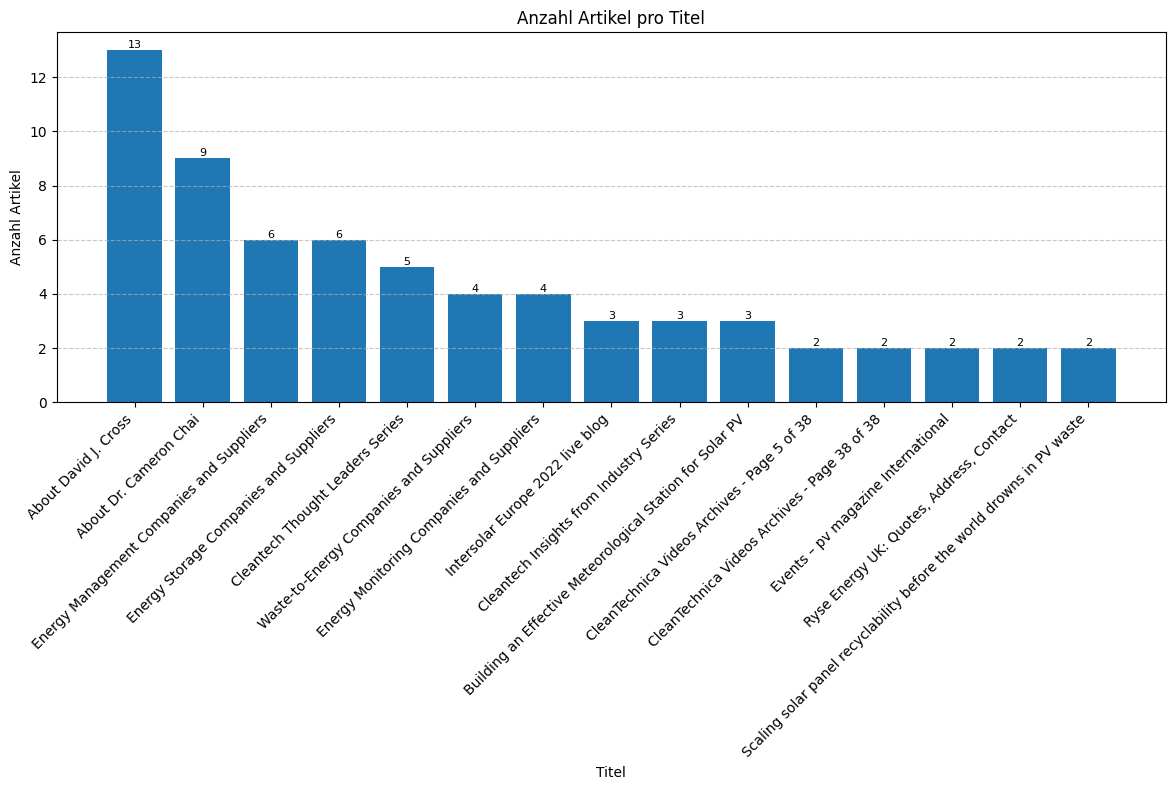

In [9]:
articles_per_title_top_15 = df_train.groupby("title").size().reset_index(name="count")
articles_per_title_top_15 = articles_per_title_top_15.sort_values(by="count", ascending=False).head(15)
articles_per_title_top_15.reset_index(drop=True, inplace=True)
p.bar_plot(articles_per_title_top_15, "title", "count", "Anzahl Artikel pro Titel", "Titel", "Anzahl Artikel", xrotation=45, ha_xrotation='right', height_offset=0)

#### Anzahl pro Domain mit dem Titel 'About David J. Cross'
Ob verschiedene Domains Artikel mit dem Titel 'About David J. Cross' veröffentlicht haben möchten wir hier untersuchen.

In [10]:
article_count_per_title = df_train[df_train["title"] == "About David J. Cross"].groupby("domain").size().reset_index(name="count")
article_count_per_title = article_count_per_title.sort_values(by="count", ascending=False)
article_count_per_title.reset_index(drop=True, inplace=True)
article_count_per_title

domain  count
0  azocleantech     13

Es nur eine Domain, die alle Veröffentlichungen zu diesem Titel gemacht hta. Die "normale" Duplikatensuche keine Ergebnisse lieferte, könnte es sein, dass es sich hier um kleinere Unterschiede beim Inhalt (updates), unterschiedliche Veröffentlichungs-Daten oder verschiedene URLs handeln. Dies wollen wir genauer untersuchen.

In [11]:
article_count_per_title = df_train[df_train["title"] == "About David J. Cross"]
u.styled_text(article_count_per_title)

Die URLs unterscheiden sich insofern, dass jeweils eine andere Page angegeben ist. Die Inhalte scheinen gleich oder sehr ähnlich zu sein. Wir werden nach dem Bereinigungsschritt, bei dem unter anderem die webseitentypischen Textbausteine, wie zum Beispiel: `['We use cookies to enhance your experience. By co
ntinuing to browse`....` entfernt werden, nochmals auf Doppelte Inhalte überprüfen.

#### Anzahl Artikel pro Top-Datum

In [12]:
# nach Datum gruppieren und Anzahl Artikel zählen, absteigend sortieren
articles_per_date = df_train.groupby("date").size().reset_index(name="count")
articles_per_date_sorted = articles_per_date.sort_values(by="count", ascending=False)
articles_per_date_sorted.head(10)

date  count
507 2023-06-13   1812
508 2023-06-14   1493
468 2023-05-04    430
509 2023-06-15    340
464 2023-04-30    111
715 2024-01-11     53
622 2023-10-07     53
653 2023-11-08     49
618 2023-10-03     49
579 2023-08-25     46

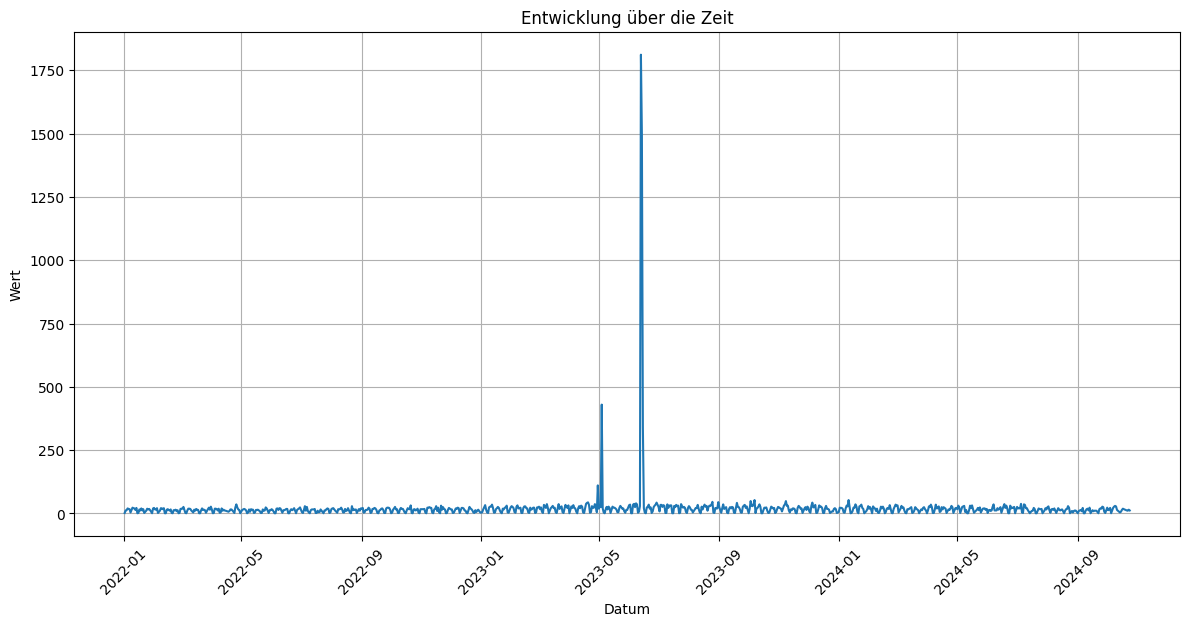

In [13]:
# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(articles_per_date["date"], articles_per_date["count"], linestyle='-')
plt.title("Entwicklung über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

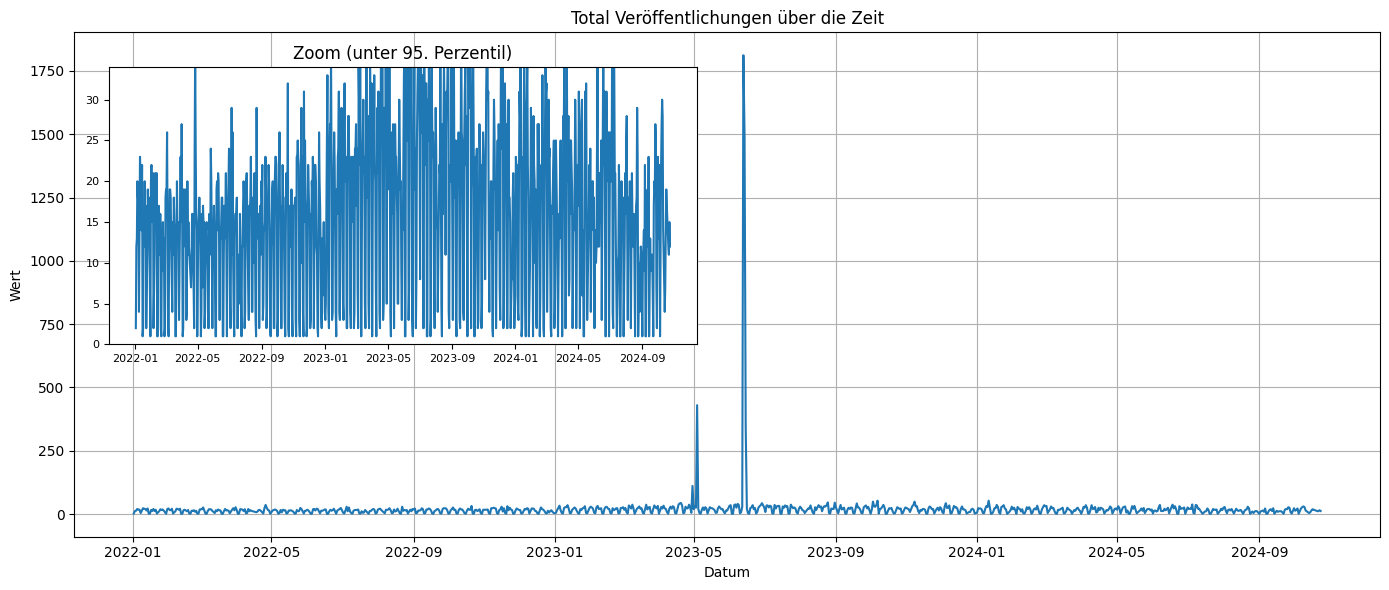

In [14]:
# Hauptplot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(articles_per_date["date"], articles_per_date["count"], label="Count")
ax.set_title("Total Veröffentlichungen über die Zeit")
ax.set_xlabel("Datum")
ax.set_ylabel("Wert")
ax.grid(True)

# Inset-Plot (Zoom auf normalen Bereich)
axins = inset_axes(ax, width="45%", height="55%", loc="upper left", borderpad=2.5)
axins.plot(articles_per_date["date"], articles_per_date["count"])
axins.set_ylim(0, articles_per_date["count"].quantile(0.95))  # 95%-Perzentil als Cutoff
axins.set_title("Zoom (unter 95. Perzentil)")
axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

Es gibt Top 5 Daten, die sich deutlich von den anderen unterscheiden. 2023-06-13 mit 1812, 2023-06-14 mit 1493, 2023-05-04 mit 430, 2023-06-15 mit 340, 2023-04-30 mit 111 Veröffentlichungen. 
Das 95% Perzentil beginnt bei ca. 45 Veröffentlichungen am selben Datum.

#### Anzahl pro Domain zum Datum vom 13.06.2023
Vielleicht können wir herausfinden, warum am 13.06.2023 1812 Artikel veröffentlicht wurden. Dazu werden wir den Datensatz auf das Datum 13.06.2023 filtern, nach Domain filtern und zählen, wieviele Artikel pro Domain veröffentlicht wurden.

In [15]:
article_per_date_and_domain = df_train[df_train["date"] == "2023-06-13"].groupby("domain").size().reset_index(name="count")
article_per_date_and_domain = article_per_date_and_domain.sort_values(by="count", ascending=False)
article_per_date_and_domain.reset_index(drop=True, inplace=True)
article_per_date_and_domain

domain  count
0             energy-xprt   1760
1           cleantechnica     20
2               decarbxpo     12
3             pv-magazine      8
4            azocleantech      3
5   solarpowerworldonline      3
6               ecofriend      1
7             energyintel      1
8                 pv-tech      1
9        solarindustrymag      1
10    solarpowerportal.co      1
11         thinkgeoenergy      1

Fast alle Artikel wurden von energy-xprt an diesem Tag veröffentlicht. Wir schauen uns die Titel an

In [16]:
energy_xprt_title_count = df_train[
    (df_train["date"] == "2023-06-13") & (df_train["domain"] == "energy-xprt")
].groupby("title").size().reset_index(name="count")

energy_xprt_title_count = energy_xprt_title_count.sort_values(by="count", ascending=False)
energy_xprt_title_count.reset_index(drop=True, inplace=True)
energy_xprt_title_count

title  count
0                Energy Storage Companies and Suppliers      6
1               Waste-to-Energy Companies and Suppliers      4
2                  Incineration Companies and Suppliers      2
3                  Solar Data ( Solar Energy) Equipment      1
4                        Solar Energy Articles - page 2      1
...                                                 ...    ...
1746  High Voltage Electricity ( Power Distribution)...      1
1747     High Voltage Cables ( Power Distribution) News      1
1748            High Voltage ( Power Distribution) News      1
1749  High Temperature Batteries Companies and Suppl...      1
1750     zinc alkaline battery ( Battery Energy Storage      1

[1751 rows x 2 columns]

Aus den Titeln und deren Verteilung ist kein spezieller Grund ersichtlich für die Summe der Artikel an diesem Tag. Wir haben ChatGPT gefragt mit folgendem Prompt: `Gibt es ein spezielles Ereignis am 13.06.2023 im Zusammenhang mit der Domain "energy-xprt"?`

Antwort: `Nach den verfügbaren Informationen gab es am 13. Juni 2023 kein besonderes Ereignis im Zusammenhang mit der Domain "energy-xprt". Energy XPRT ist ein globaler Marktplatz für Lösungen und Anbieter im Energiesektor, der Produktkataloge, Artikel, Branchenveranstaltungen und Publikationen anbietet. citeturn0search0 Obwohl Energy XPRT regelmäßig Veranstaltungen und Neuigkeiten veröffentlicht, scheint an diesem spezifischen Datum kein besonderes Ereignis stattgefunden zu haben. `

Wir nehmen dies so zur Kenntnis.

#### Duplikate beim Artikel?

Diese Frage können wir soweit schon beantworten, dass es höchstwahrscheinlich Duplikate gibt, diese aber erst nach der Textbereinigung überprüft werden.

#### Welches sind die meist benutzten Worte?

Um den Datensatz inhaltlich bzw. thematisch noch besser kennen zu lernen, möchten wir sehen, welches die häufigsten Wörter sind. Ob das Bereinigen vor einer solchen Analyse sinnvoll ist, versuchen wir herauszufinden. Deshalb suchen wir nach den häufigsten Wörtern vor und nach der Bereinigung, um so den direkten Vergleich zu erhalten.
Wir erstellen zwei Wordclouds.

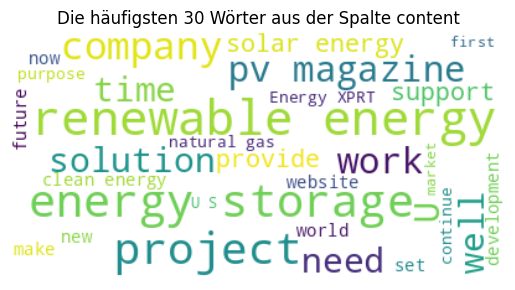

In [17]:
content = " ".join(df_train["content"].astype(str).tolist())
p.plot_wordcloud(content, c_stopwords=c_stopwords, column_name='content')

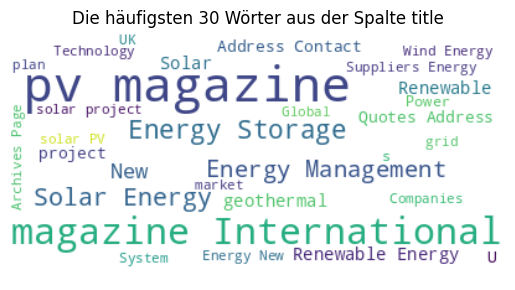

In [18]:
titles = " ".join(df_train["title"].astype(str).tolist())
p.plot_wordcloud(titles, c_stopwords=c_stopwords, column_name='title')

Aus diesen beiden Wordclouds kann man erkennen, dass es vorallem Artikle im Energie-Bereich sind.

### Sprache überprüfen

Prüfen ob alle Artikel **einheitliche Sprache** haben  

In [19]:
def check_language(df: pd.DataFrame, column: str) -> bool:
    """
    Prüft, ob alle Texte in einer bestimmten Spalte auf Englisch sind.

    Args:
        df
        column: Name der Spalte mit Text.

    Returns:
        bool: True, wenn alle Inhalte in der Spalte Englisch sind, sonst False.
    """
    try:
        all_english = all(
            langdetect.detect(text) == "en"
            if isinstance(text, str) and text.strip() != "" else False
            for text in df[column]
        )
    
        if all_english:
            print("Alle Inhalte sind auf Englisch.")
        else:
            print("Die Sprache ist nicht einheitlich Englisch.")
    
    except Exception as e:
        print(f"Fehler bei Spracherkennung: {e}")
        return False
    

check_language(df_train, "content")

Die Sprache ist nicht einheitlich Englisch.


In [20]:
# Sprache für jede Zeile erkennen
def detect_language(text: str) -> str:
    try:
        return detect(text) if isinstance(text, str) and text.strip() != "" else "unknown"
    except:
        return "error"

# Neue Spalte Spracherkennung
df_train["language"] = df_train["content"].apply(detect_language)

# Sprachen zählen
language_counts = Counter(df_train["language"])
print("Anzahl Artikel pro erkannter Sprache:")
print(language_counts)

Anzahl Artikel pro erkannter Sprache:
Counter({'en': 20106, 'de': 3, 'ru': 1, 'es': 1})


Überprüfen, ob die Sprachzuteilung stimmt. Dazu drucken wir die erste Zeile mit Deutsch aus.

In [21]:
u.print_full_text(df_train[df_train["language"] == 'de'][['id', 'title', 'content', 'language']].head(1), max_width=400)

An diesem Beispiel sieht man gut, dass der Titel und der Text Deutsch sind. Einzig die Boilerplates sind in Englisch. Diese werden durch die Textbereinigung entfernt.

Im Trainingsdatensatz wurden 5 von 20111 Artikeln als nicht englisch erkannt. Weil dieser Anteil vernachlässigbar klein ist, wurden diese Artikel bewusst entfernt, da:

* Das RAG-System ausschließlich auf englischsprachigen Daten trainiert wird (sowohl der Retriever als auch der Generator).
* Nicht englische Inhalte potenziell fehlerhafte Embeddings erzeugen könnten, was zu einer schlechteren semantischen Suche oder gar falschen Resultaten führen kann.
* Eine sprachlich homogene Datenbasis sicherstellt, dass alle semantischen Vektoren im gleichen Sprachraum liegen - ein wichtiger Faktor für eine konsistente Performance beim Retrieval.
* Bei größeren Mengen an nicht englischen Daten wäre es hingegen sinnvoll, vor dem Einbetten eine automatische Übersetzung (zB. MarianMT) durchzuführen, um die Datenbasis zu erweitern, ohne sprachliche Inkonsistenzen einzuführen, dazu müsste man zursätzliche Antwort-Postprocessing einführen oder ein multilinguales Modell trainieren.

In [22]:
# Nur englische Artikel behalten
df_train = df_train[df_train["language"] == "en"]

print(f"Anzahl Artikel nach dem Entfernen nicht-englischer Inhalte: {len(df_train)}")

Anzahl Artikel nach dem Entfernen nicht-englischer Inhalte: 20106


### Text Bereinigen

Da die Daten scheinbar durch Webscraping erstellt wurden, sind einige Sätze in Apostrophe gefasst und mit einem Komma getrennt, daher wird der Text zu einem Fliesstext gemerged.

In [23]:
def fake_list_to_text(text: str) -> str:
    if not isinstance(text, str):
        return text
    if text.count("',") >= 1 and "'" in text:
        parts = re.split(r"\s*,\s*", text.strip("[]"))
        parts = [p.strip(" '\"\n") for p in parts if p.strip()]
        return " ".join(parts)
    return text

In [24]:
df_train["content"] = df_train["content"].apply(fake_list_to_text)
df_train.head()

id                                              title       date  \
0  93320          XPeng Delivered ~100,000 Vehicles In 2021 2022-01-02   
1  93321      Green Hydrogen: Drop In Bucket Or Big Splash? 2022-01-02   
2  98159  World’ s largest floating PV plant goes online... 2022-01-03   
3  98158  Iran wants to deploy 10 GW of renewables over ... 2022-01-03   
4  31128  Eastern Interconnection Power Grid Said ‘ Bein... 2022-01-03   

                                             content           domain  \
0  Chinese automotive startup XPeng has shown one...    cleantechnica   
1  Sinopec has laid plans to build the largest gr...    cleantechnica   
2  Huaneng Power International has switched on a ...      pv-magazine   
3  According to the Iranian authorities there are...      pv-magazine   
4  Sign in to get the best natural gas news and d...  naturalgasintel   

                                                 url language  
0  https://cleantechnica.com/2022/01/02/xpeng-del...       en  
1  https://cleantechnica.com/2022/01/02/its-a-gre...       en  
2  https://www.pv-magazine.com/2022/01/03/worlds-...       en  
3  https://www.pv-magazine.com/2022/01/03/iran-wa...       en  
4  https://www.naturalgasintel.com/eastern-interc...       en

#### Klasse `TextCleaner`
Für die Text Bereinigung haben wir eine Klasse `TextCleaner` erstellt. 
Die Klasse `TextCleaner` ist dafür gedacht, Webtexte oder Textdaten von sogenannter „Boilerplate“ zu bereinigen – das sind Textteile, die keinen inhaltlichen Mehrwert liefern, wie z. B. Cookie-Hinweise, rechtliche Hinweise oder Login-Formulare. Solche Texte stören oft bei der Analyse von Webinhalten, NLP-Projekten oder Textklassifikation. Schauen wir uns die Klasse im Detail an:

__init__: Konstruktor
Hier werden zwei Dinge initialisiert:

1. boilerplate_patterns: Eine Liste an regulären Ausdrücken (regex), um häufig vorkommende, irrelevante Textbestandteile zu erkennen und zu entfernen (z. B. Cookie-Banner, Captcha, rechtliche Hinweise, Navigation, Newsletter-Aufrufe etc.).

2. end_markers: Stichworte, bei denen davon ausgegangen wird, dass ab diesem Punkt der Text irrelevant ist und abgeschnitten werden kann.


`truncate_boilerplate_tail(text)`
Schneidet den Text an dem Punkt ab, an dem einer der end_markers auftaucht (z. B. „this content is protected“). Das hilft, um am Ende des Textes automatisch irrelevante Abschnitte zu entfernen.


`clean_text(text)`
Dies ist die zentrale Methode zur Textbereinigung. Sie macht folgendes:

1. Entfernt URLs mit einem regex.

2. Vereinheitlicht typographische Zeichen (z. B. ersetzt typographische Anführungszeichen durch Standardzeichen).

3. Wendet alle boilerplate_patterns auf den Text an und entfernt sie.

4. Ersetzt Sonderzeichen wie Bindestriche und Unterstriche durch Leerzeichen.

5. Entfernt alle Zeichen außer Buchstaben, Zahlen, Satzzeichen und deutsche Umlaute.

6. Schneidet am Ende des Textes alles ab, was nach einem end_marker kommt (via truncate_boilerplate_tail).

7. Gibt den bereinigten Text zurück.


`is_meaningful(text)`
Prüft, ob der Text nach der Bereinigung überhaupt noch sinnvollen Inhalt hat:

- Ist nicht leer (enthält Buchstaben oder Zahlen).

- Ist nicht nur „Meta-Text“, wie z. B. „NGI“ oder eine ISSN.

So können irrelevante oder leere Texte leicht erkannt und ggf. verworfen werden.


`clean_text_column(df, column, new_column=None)`
Diese Methode ist gedacht für Pandas DataFrames:

1. Wendet clean_text() auf eine ganze Spalte (column) an.

2. Schreibt die bereinigten Texte entweder in dieselbe oder in eine neue Spalte (new_column).

3. Filtert alle Zeilen raus, deren bereinigter Text nicht sinnvoll ist (is_meaningful).

Um die Funktion des TextCleaners zu überprüfen, verwenden wir den Datenstatz `article_count_per_title`, da dieser die vermuteten doppelten Inhalte aufzeigen kann.

In [25]:
cleaner = TextCleaner(level="risky")
data_cleaned = cleaner.clean_text_column(article_count_per_title, column="content", new_column="content_cleaned")

data_cleaned_compare = data_cleaned[["content", "content_cleaned"]].copy()
u.styled_text(data_cleaned_compare.head(), max_width=500)

Nun ist gut zu erkennen, dass es sich höchstwahrscheinlich um dieselben Texte handelt, zumindest sind die ersten 5 Zeilen identisch. Diese Erkenntnis werden wir nutzen, um Duplikate zu entfernen.

### Duplikate entfernen
Bevor die Duplikate entfernt werden können, muss der gesamte Text mit dem TextCleaner bereinigt werden.

#### Titel und Inhalt-Längen

Wir wollen sehen, ob es sehr lange Titel oder sehr kurze Inhalte gibt. Dazu schauen wir uns die Textlängen an. Dies machen wir vor und nach dem Text Bereinigen.

#### Gesamten Text bereinigen


In [26]:
df_train_cleaned = cleaner.clean_text_column(df_train, column="content", new_column="content_cleaned")

u.styled_text(df_train_cleaned.head(3))

In [27]:
u.styled_text(df_train_cleaned.describe(include=[object]))

Duplikate werden auf die Spalte'content_cleaned' überprüft. Falls es Duplikate hat, wir der Datensatz, welcher vom Datum her der aktuellste ist, behalten.

In [28]:
def drop_duplicates_keep_latest(df: pd.DataFrame) -> pd.DataFrame:
    """
    Entfernt Duplikate basierend auf den Spalten 'title', 'content_cleaned', 'domain', und 'url' und behält den neuesten Eintrag.
    """
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date').drop_duplicates(subset=['content_cleaned'], keep='last')
    
    return df
df_train_cleaned_unique = df_train_cleaned.copy(deep=True)
df_train_cleaned_unique = drop_duplicates_keep_latest(df_train_cleaned_unique)
len(df_train_cleaned), len(df_train_cleaned_unique), len(df_train_cleaned) - len(df_train_cleaned_unique)


(20106, 19988, 118)

Kontrolle, ob nicht Datensätze gelöscht wurden, welche für die Evaluation nötig sind.

In [29]:
def check_target_url_in_train_df(target_df: pd.DataFrame, train_df: pd.DataFrame) -> pd.DataFrame:
    url_in_train_df = set(train_df['url'])
    target_df['url_in_train_df'] = target_df['article_url'].isin(url_in_train_df)
    return target_df
    
# read parquet file
cleantech_rag_evaluation_data = pd.read_parquet('../data_mc1/data_processed/cleantech_rag_evaluation_data.parquet')
url_check = check_target_url_in_train_df(cleantech_rag_evaluation_data, df_train_cleaned_unique)
print(f"Es fehlen {len(url_check[url_check['url_in_train_df'] == False])} Datensätze, welch durch die Bereinigung gelöscht wurden und im  Evaluationsdatensatz enthalten sind.")

Es fehlen 0 Datensätze, welch durch die Bereinigung gelöscht wurden und im  Evaluationsdatensatz enthalten sind.


In [30]:
print(f"Nach dem Bereinigen sind noch {len(df_train_cleaned_unique)} Artikel übrig (von ursprünglich {len(df_train)}), was einer Reduktion von {len(df_train) - len(df_train_cleaned_unique)} Artikeln entspricht.")
df_train_cleaned = df_train_cleaned_unique.copy(deep=True)

Nach dem Bereinigen sind noch 19988 Artikel übrig (von ursprünglich 20106), was einer Reduktion von 118 Artikeln entspricht.


### Wordcloud 2.0
Nach der erfolgreichen Bereinigung erstellen wir nochmals dieselben Wordclouds wie zuvor.

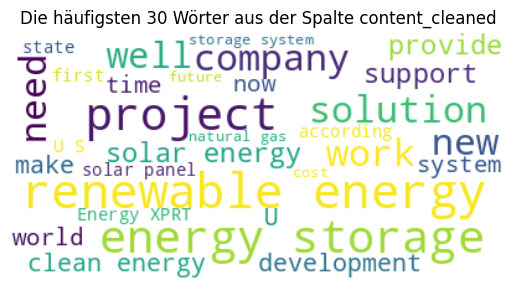

In [31]:
content = " ".join(df_train_cleaned["content_cleaned"].astype(str).tolist())
p.plot_wordcloud(content, c_stopwords=c_stopwords, column_name='content_cleaned')

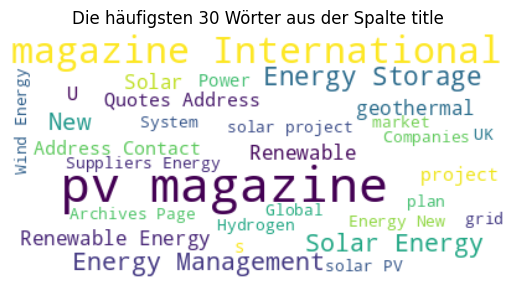

In [32]:
titles = " ".join(df_train_cleaned["title"].astype(str).tolist())
p.plot_wordcloud(titles, c_stopwords=c_stopwords, column_name='title')

Im Vergleich zu den nicht bereinigten Wordclouds kann man nun einen deutlichen Unterschied zwischen Titel und Inhalt erkennen. Vorher war beides sehr ähnlich.
Wenn man die Wordcloud vom Content anschaut, könnte man zum Schluss kommen, dass der Inhalt noch weiter Bereinigt werden sollte, da es nun einige Stopwords anzeigt. Dass bei der zweiten Wordcloud aus Title einzelne Buchstaben angezeigt werden, lässt ebenfalls darauf schliessen, dass noch weiter bereinigt werden sollte.
Zuerst möchten wir aber die wichtigen Wörter mit TF-IDF anschauen und danach beurteilen, wie weiter bereinigt werden sollte.

Spalte content droppen und contetent_cleaned zu content umbenennen

In [33]:
df_train_cleaned = df_train_cleaned.drop(columns=["content"])
df_train_cleaned = df_train_cleaned.rename(columns={"content_cleaned": "content"})

### Titel an den Content anfügen

Der Titel wird jeweils zu Beginn des Contents getrennt mit einem Doppelpunkt hinzugefügt. Damit muss nur noch der Content embedded werden.

In [34]:
# ermittle die maximale Länge der Titel
max_title_length = df_train_cleaned['title'].str.len().max()
print(f"Maximale Länge der Titel: {max_title_length}")
# ermittle die minimale Länge der Inhalte
min_content_length = df_train_cleaned['content'].str.len().min()
print(f"Minimale Länge der Inhalte: {min_content_length}")

# ermittle, welche Titel länger sind als ihre Inhalte
longer_titles = df_train_cleaned[df_train_cleaned['title'].str.len() > df_train_cleaned['content'].str.len()]
print(f"Anzahl Titel, die länger sind als ihre Inhalte: {len(longer_titles)}")

Maximale Länge der Titel: 403
Minimale Länge der Inhalte: 8
Anzahl Titel, die länger sind als ihre Inhalte: 36


In [35]:
# Kontrolliere, ob die evaluationadaten (urls) in den longer_titles enthalten sind
print(f"Anzahl Evaluationsdaten, die in den longer_titles enthalten sind: {len(longer_titles[longer_titles['url'].isin(cleantech_rag_evaluation_data['article_url'])])}")

Anzahl Evaluationsdaten, die in den longer_titles enthalten sind: 0


In [36]:
# Lösche die Datensätze von longer_titles aus dem df_train_cleaned
df_train_cleaned = df_train_cleaned[~df_train_cleaned['id'].isin(longer_titles['id'])]

# Title und Content zusammenführen
df_train_cleaned['text'] = df_train_cleaned['title'] + ": " + df_train_cleaned['content']
df_train_cleaned.head(3)

id                                              title       date  \
0   93320          XPeng Delivered ~100,000 Vehicles In 2021 2022-01-02   
1   93321      Green Hydrogen: Drop In Bucket Or Big Splash? 2022-01-02   
13  65564  Community solar policy gets green light in man... 2022-01-03   

                   domain                                                url  \
0           cleantechnica  https://cleantechnica.com/2022/01/02/xpeng-del...   
1           cleantechnica  https://cleantechnica.com/2022/01/02/its-a-gre...   
13  solarpowerworldonline  https://www.solarpowerworldonline.com/2022/01/...   

   language                                            content  \
0        en  Chinese automotive startup XPeng has shown one...   
1        en  Sinopec has laid plans to build the largest gr...   
13       en  Community solar is a unique market segment tha...   

                                                 text  
0   XPeng Delivered ~100,000 Vehicles In 2021: Chi...  
1   Green Hydrogen: Drop In Bucket Or Big Splash?:...  
13  Community solar policy gets green light in man...

In [37]:
df_train_cleaned = df_train_cleaned.drop(columns=["content"])
df_train_cleaned = df_train_cleaned.rename(columns={"text": "content"})

### Datensatz mit 1000 Zeilen

Um die Ressourcen nicht zu schnell zu verbrauchen, reduzieren wir den Datensatz auf 1000 Zeilen. Dabei wird darauf geachtete, dass alle Zeilen, die im Testdatensatz vorhanden sind, auch im reduzierten Datensatz sind. Das Vorgehen ist folgendermassen: alle Daten, die für die Tests benötigt werden

In [38]:
df_train_cleaned_subset = df_train_cleaned[df_train_cleaned['url'].isin(cleantech_rag_evaluation_data['article_url'])].copy(deep=True)
df_train_subset_1000 = df_train_cleaned.sample(n=1000-len(df_train_cleaned_subset), random_state=42, replace=False)
df_train_1000 =pd.concat([df_train_cleaned_subset, df_train_subset_1000], ignore_index=True)

## Chunking  

 Beim Chunking werden die Token zu bedeutungsvolleren Einheiten zusammengefasst, wie zB. Sätze oder thematischen Einheiten (je nach Bedarf).  

Ein **Overlap (Überlappung)** zwischen Chunks wird verwendet, um den **semantischen Zusammenhang** zu erhalten.
zB.:  
Chunk 1: "Das Unternehmen Tesla hat eine neue Batterie entwickelt."  
Chunk 2: "Sie hält 50% länger als bisherige Modelle."  

-> Chunk 2 hätte keinen Bezug zum Unternehmen "Tesla" ohne einen Teil aus Chunk 1. -> der Kontext soll also erhalten bleiben.  





## Tokenisierung  
Tokenisierung zerlegt den Text in kleine Einheiten (Zeichen, Wörter).  
Tokensierung wird automatisch durch das Embedding-Modell übernommen. 

## Embeddings  

Für das Embedding mit LangChain: Keine Kleinschreibung erzwingen (Grossbuchstaben sind wichtig für Satzgrenzen und Entitätenerkennung)

Jeder Chunk wird in einen numerischen Vektor umgewandelt. Diese Vektoren repräsentieren die Bedeutung des Textes. Chunks mit ähnlicher Bedeutung haben ähnliche Vektoren

In dem Python-Skript `Chroma_Embedding_Pipeline.py` ist die Pipeline für die Erstellung der Embeddings und deren Speicherung in Chroma implementiert. In dem `archiv/testing_embedding.ipynb` wurden einzelne Schritte getestet und basierend auf den Ergebnissen die Pipeline erstellt.

## Chroma Daten

Die verschiedenen Chroma Datenbänke werden in dem Notebook `chroma_data.ipynb` erstellt und lokal gespeichert, da sie für GitLab zu gross sind. Hier wurden ebenfalls einige tests in dem Notebook `archiv/testing_embedding.ipynb` gemacht, um die Chroma DB zu testen.

#### Übersicht der Konfigurationen

| **DB-Name**              | **TextSplitter**                        | **Chunk Size / Overlap** | **Ähnlichkeitsmetrik** | **Erwartete Auswirkungen**                                                            |
|--------------------------|-----------------------------------------|---------------------------|-------------------------|-----------------------------------------------------------------------------------------|
| `recchar_800_cosine`     | `RecursiveCharacterTextSplitter`        | 800 Zeichen / 100         | Cosine                  | Gute Balance zwischen Genauigkeit und Effizienz; geringer Ressourcenverbrauch.          |
| `recchar_800_l2`         | `RecursiveCharacterTextSplitter`        | 800 Zeichen / 100         | L2 (Euklidisch)         | Potenziell bessere Treffergenauigkeit; höherer Rechen- und Speicherbedarf.              |
| `recchar_800_ip`         | `RecursiveCharacterTextSplitter`        | 800 Zeichen / 100         | IP (Inneres Produkt)    | Abhängig vom Textinhalt; bei passenden Daten eventuell bessere Relevanz.                |
| `senttrans_200_cosine`   | `SentenceTransformersTokenTextSplitter` | 200 Token / 20            | Cosine                  | Höhere Präzision bei modernen Modellen; Chunkgrenzen wirken teils unnatürlich.          |
| `senttrans_200_l2`       | `SentenceTransformersTokenTextSplitter` | 200 Token / 20            | L2 (Euklidisch)         | Sehr genaue Ergebnisse möglich; deutlich erhöhter Ressourcenbedarf.                     |
| `senttrans_200_ip`       | `SentenceTransformersTokenTextSplitter` | 200 Token / 20            | IP (Inneres Produkt)    | Uneinheitliche Resultate; sinnvoll bei bestimmten Textarten oder Spezialanwendungen.    |



#### Detaillierte Parameterbeschreibung

Jedes der sechs Konfigurationen wurde ebenfalls mit einem zusätzlichen Embedding-Modell getestet, um 

##### 1. Embedding-Modell

Jede Konfiguration wird mit zwei verschiedenen Embedding-Modellen getestet, um die Auswirkungen der Modellwahl auf die Qualität der Embeddings und die Effizienz des Retrievals zu evaluieren.

- **text-embedding-3-large**
  - **Beschreibung**: Hochperformantes Embedding-Modell der dritten Generation von OpenAI mit stark verbesserter semantischer Repräsentationsfähigkeit.
  - **Vorteile**: Sehr hohe Genauigkeit bei der semantischen Suche, besonders geeignet für komplexe, nuancenreiche Inhalte.
  - **Nachteile**: Höherer Ressourcenverbrauch (Rechenleistung & Kosten) im Vergleich zu kleineren Modellen.
  - **Erwartung**: Führt zu einer signifikanten Verbesserung der Suchqualität, insbesondere in Kombination mit präzisen TextSplittern und anspruchsvollen Metriken.

- **text-embedding-ada-002**
  - **Beschreibung**: Kosteneffizientes und schnelles Embedding-Modell der zweiten Generation mit solider semantischer Qualität.
  - **Vorteile**: Günstig, schnell und für viele Standardanwendungen ausreichend präzise.
  - **Nachteile**: Geringere semantische Tiefe und Genauigkeit im Vergleich zu größeren Modellen.
  - **Erwartung**: Gute Baseline-Performance für einfache bis mittelschwere Anwendungsfälle mit niedrigem Ressourcenbedarf.

##### 2. TextSplitter

Die Wahl des TextSplitters bestimmt maßgeblich die Granularität der Chunks und beeinflusst damit die Qualität der Embeddings sowie die Suchpräzision.

- **RecursiveCharacterTextSplitter** (`chunk_size=800`, `chunk_overlap=100`, `separators=["\n\n", "\n", ".", " ", ""]`)
  - **Beschreibung**: Hierarchische Aufteilung entlang natürlicher Textgrenzen wie Absätze, Sätze und Wörter.
  - **Vorteile**: Semantisch kohärente Chunks, geringer Rechenaufwand, einfache Implementierung.
  - **Nachteile**: Ignoriert Token-Grenzen von Transformer-Modellen, was Embedding-Effizienz beeinträchtigen kann.
  - **Erwartung**: Sehr gute Performance bei strukturierten Texten wie Berichten und Artikeln.

- **SentenceTransformersTokenTextSplitter** (`chunk_size=200 Tokens`, `chunk_overlap=20`, `model_name="sentence-transformers/all-MiniLM-L6-v2"`)
  - **Beschreibung**: Aufteilung auf Basis der Tokenisierung eines Transformer-Modells.
  - **Vorteile**: Bessere Anpassung an Embedding-Modelle, präzisere Repräsentation komplexer Inhalte.
  - **Nachteile**: Chunks können mitten in Sätzen enden; erhöhter Rechenaufwand durch Tokenisierung.
  - **Erwartung**: Höhere Präzision bei technischen oder informationsdichten Texten.


##### 3. Ähnlichkeitsmetriken (`hnsw:space`)

Die Metrik definiert, wie Ähnlichkeit zwischen Vektoren gemessen wird und beeinflusst somit die Qualität und Reihenfolge der Treffer.

- **Cosine (Cosinus-Ähnlichkeit)**:
  - **Beschreibung**: Vergleicht die Richtung von Vektoren, robust gegenüber Skalierungsunterschieden.
  - **Vorteile**: Schnelle Berechnung, speichereffizient, bewährter Standard für Text-Embeddings.
  - **Nachteile**: Kann bei sehr ähnlichen Einträgen unpräziser sein.
  - **Erwartung**: Solide Basislinie mit guter Balance zwischen Qualität und Performance.

- **L2 (Euklidische Distanz)**:
  - **Beschreibung**: Misst den tatsächlichen Abstand zwischen Vektoren im Raum.
  - **Vorteile**: Höhere Genauigkeit bei fein abgestuften Ähnlichkeiten.
  - **Nachteile**: Deutlich rechenintensiver und speicheraufwändiger.
  - **Erwartung**: Präzisere Resultate bei komplexen, feingranularen Abfragen.

- **IP (Inneres Produkt)**:
  - **Beschreibung**: Fokus auf die Projektion von Vektoren zueinander, weniger auf den absoluten Abstand.
  - **Vorteile**: Kann bei normalisierten Embeddings Vorteile bieten.
  - **Nachteile**: Ergebnisse sind schwerer vorhersehbar; kann unzuverlässig bei allgemeinen Texten sein.
  - **Erwartung**: Starke Abhängigkeit vom spezifischen Embedding- und Anwendungsfall.


##### 4. Konstant gehaltene Parameter

Um die Auswirkungen von Splitter- und Metrikvarianten isoliert evaluieren zu können, bleiben folgende Werte konstant:

- **HNSW-Parameter**: `hnsw:M=16`, `efConstruction=200`
  - **Begründung**: Standardkonfiguration für eine ausgewogene Balance zwischen Genauigkeit und Speicherverbrauch.
- **Indexierungspipeline**: `batch_size=20`, `sleep_time=1.0`
  - **Begründung**: Verhindert API-Überlastung durch konservative Anfragefrequenz, sorgt für Stabilität während des Ladens.


#### Fazit

Diese sechs Konfigurationen ermöglichen eine strukturierte Evaluierung der Auswirkungen unterschiedlicher Text-Splitting-Strategien und Ähnlichkeitsmetriken, welche mithilfe von RAGAS evaluiert und verglichen werden. 


## Retrieval-Modul (Suche & Ranking) & Generator-Modul (Antwortgenerierung)  


### Ablauf der RetrievalQA-Evaluations-Chain

- **Retriever:** Holt relevante Dokumente basierend auf der Frage (`retriever.invoke`).
- **Retrieved Texts:** Extrahiert nur die Inhalte (`page_content`) der Dokumente.
- **Context:** Verbindet die Inhalte zu einem großen Textblock (`\n\n`.join(...)).
- **Prompt Template:** Fügt den generierten Context und die Frage in ein definiertes Prompt-Template ein.
- **LLM Call:** Ruft das LLM auf, um auf Basis von Context + Frage eine Antwort zu erzeugen.
- **Speicherung:** Frage, Antwort, verwendete Texte und Context werden für die spätere Evaluation gespeichert.

Reihenfolge ist essenziell:  
**Retriever → Texte → Context → Prompt → LLM**

### Varianten im Retrieval  
Es wurden verschiedene Konfigurationen des Retrievals getestet, um den Einfluss auf die Antwortqualität zu analysieren:  

**Similarity Retrieval (Top-k Suche):**
* similarity_k3: Holt die 3 ähnlichsten Chunks zum Query.
* similarity_k5: Holt die 5 ähnlichsten Chunks zum Query.

Beim Similarity Retrieval werden die Chunks basierend auf der Ähnlichkeit (meist gemessen als Distanz im Vektorraum) zum Query sortiert und die Top-k ähnlichsten Chunks ausgewählt.
Der Parameter k bestimmt dabei, wie viele Chunks pro Anfrage abgerufen werden.  

**Maximal Marginal Relevance (MMR Retrieval):**
* mmr_k5_fetch20: Wählt 5 diverse Chunks aus 20 vorselektierten Kandidaten.
* mmr_k7_fetch20: Wählt 7 diverse Chunks aus 20 vorselektierten Kandidaten.

Beim MMR Retrieval wird nicht nur die Ähnlichkeit zum Query berücksichtigt, sondern zusätzlich die Diversität unter den ausgewählten Chunks maximiert.
Hier steuert der Parameter fetch_k, wie viele Kandidaten zunächst auf Basis der Ähnlichkeit vorgeladen werden, und k, wie viele davon dann nach maximaler Diversität ausgewählt werden.

### Weitere Parameter: 

**Temperatur:**  
Die Temperatur des LLMs wurde standardmäßig auf 0.5 gesetzt, kann jedoch im System flexibel angepasst werden, da sie als einstellbarer Parameter übergeben wird.  
Die Temperatur steuert die Glättung oder Schärfung der Wahrscheinlichkeitsverteilung über die möglichen nächsten Token im Sprachmodell.

* Eine niedrige Temperatur (z.B. 0.2) führt zu deterministischeren, präziseren Antworten und bewirkt eine Schärfung der Verteilung:  
Wahrscheinlichkeiten mit ohnehin hohem Wert werden noch dominanter. Das Modell bevorzugt sehr wahrscheinliche Token.
* Eine höhere Temperatur (z.B. 0.7) erzeugt kreativere, vielfältigere Antworten mit mehr Variabilität und glättet die Verteilung:  
Unterschiede zwischen den Token-Wahrscheinlichkeiten werden abgeschwächt, wodurch auch weniger wahrscheinliche Token eher ausgewählt werden können.  

Einfluss auf die RAGAS-Evaluierung - Unterschiedliche Temperaturen können direkte Auswirkungen auf die RAGAS-Metriken haben:  
Niedrige Temperaturen verbessern tendenziell die Faithfulness- und Context Relevance-Scores, da die Antworten näher am bereitgestellten Kontext bleiben.  
Hohe Temperaturen können zu kreativ ausgeschmückten Antworten führen, die zwar sprachlich korrekt erscheinen, aber weniger genau auf dem tatsächlichen Kontext basieren, was die Groundedness und Relevanz-Bewertungen negativ beeinflussen kann.

In dieser Evaluation lag der Fokus auf kontrollierten und replizierbaren Antworten, weshalb moderate Temperaturen verwendet wurden.

**Prompting-Strategien:**  
Alle Varianten wurden systematisch mit zwei verschiedenen Prompt-Templates getestet und die Ergebnisse gespeichert:

* Simple Prompt: Der LLM wird angewiesen, die Frage basierend auf dem bereitgestellten Kontext direkt zu beantworten und bei Unsicherheit offen "I do not know" anzugeben.
* Chain-of-Thought Prompt: Der LLM wird aufgefordert, vor der finalen Antwort eine schrittweise Überlegung ("Chain of Thought") zu formulieren, um so die Qualität und Nachvollziehbarkeit der Antworten zu erhöhen.

**Hinweis:**  
Die Prompting-Strategien wurden bewusst nicht exzessiv optimiert oder angepasst, da die Qualität der Antworten auch stark von der Formulierung der Benutzerfragen abhängt.
Eine umfassende Optimierung des Promptings wäre zudem sehr zeitintensiv und wurde aufgrund der Projektziele nicht priorisiert.

Auf weitere Varianten von top-k, fetch_k, anderen Retrieval-Methoden und umfangreichere Prompting-Experimente wurde aus zeitlichen Gründen verzichtet.

### Output:

- **question:** Frage aus dem Eval-Set  
- **relevant_text:** "Ground Truth" aus dem Eval-Set  
- **relevant_text_llm:** Liste der Top-K retrieved Chunks  
- **retrieved_context:** Der Kontext-String, den das LLM tatsächlich gesehen hat  
- **answer:** Erwartete Antwort aus Eval-Set  
- **answer_llm:** Antwort, die das Modell produziert  

## Evaluator-Modul (Qualitätsprüfung & Optimierung)  


Im Rahmen dieser Arbeit wurde eine extrinsische Evaluation des RAG-Systems mithilfe des Frameworks RAGAS durchgeführt. Dabei kamen sowohl LLM-basierte Qualitätsmetriken als auch klassische Information-Retrieval-Metriken zum Einsatz. Ziel war eine umfassende Bewertung der Systemleistung über verschiedene Dimensionen hinweg. Die wichtigsten Erkenntnisse sind in den dargestellten Boxplots und Balkendiagrammen visualisiert.  


In dem Python-Skript `evaluation.py` ist die Pipeline für die automatische Evualierung per RAGAS und non-LLM metriken, sowie deren Visualisierung. Die Ergebnisse werden ausserdem in `data_mc1/data_evaluierung` abgelegt um nachträglich für weiter Analysen darauf zugreifen zu können.  

Übersicht evaluation.py:  
- Lädt Chroma-Collection mit Embeddings
- Unterstützt Retriever-Typen
- Prompting & Chain-Erstellung (simple, cot)
- Erstellt LangChain-Pipeline (Retriever → Prompt → LLM)
- Antwortgenerierung: speichert Antwort, Kontext, Gold-Referenz
- Evaluation: RAGAS- und IR-Metriken
- Visualisierung der Ergebnisse (Boxplot & Balken)

**Konfigurierbare Komponenten**
* Retriever: similarity_k3, similarity_k5, mmr_k5, mmr_k7
* Prompting: simple, chain_of_thought
* Temperatur: variable
* Embeddings: text-embedding-3-large oder text-einbettung-ada-002 via Azure OpenAI
* LLM Modelle: Antwortgenerierung mit gpt-4o-mini via Azure OpenAI


### Evaluierte Metriken
**LLM-basierte Metriken (RAGAS)**  
Diese Metriken werden automatisch durch ein LLM (gpt-4o-mini) bewertet und basieren auf der Qualität der generierten Antwort im Verhältnis zum abgerufenen Kontext:

* **Faithfulness:** Bewertet, ob die generierte Antwort sachlich korrekt und durch den bereitgestellten Kontext belegbar ist.  
→ Ein hoher Wert nahe 1 zeigt, dass die Antwort inhaltlich treu und gut gestützt ist.

* **Answer Relevance:** Misst, ob die generierte Antwort überhaupt zur gestellten Frage passt.  
→ Ein hoher Wert nahe 1 ist wünschenswert - Werte nahe 0 deuten auf irrelevante oder fehlgeleitete Antworten hin. (Verbesserungspotenzial bei Promptgestaltung oder Retrieval-Qualität)  

* **Context Precision:** Gibt an, wie viel Prozent des verwendeten Kontexts tatsächlich relevant zur Frage ist.  
→ Hohe Präzision nahe 1 bedeutet, dass kaum irrelevante Information im Kontext enthalten ist - ein Indikator für effizientes Retrieval.  

* **Context Recall:** Bewertet, ob alle für die Antwort relevanten Informationen im Kontext enthalten sind.  
→ Ein hoher Wert nahe 1 zeigt, dass der Kontext vollständig genug war, um die Frage zu beantworten.  

* **Answer Correctness:** Überprüft, ob die Antwort nicht nur relevant, sondern auch objektiv korrekt ist.  
→ Ein hoher Wert nahe 1 bedeutet korrekte Antworten; Schwankungen hier weisen auf Unsicherheiten in der LLM-Generierung hin.  


**Nicht-LLM-basierte klassische IR-Metriken**  
Diese Metriken basieren auf der Analyse der Treffergenauigkeit beim Retrieval und sind unabhängig von der Antwortgenerierung. Auch hier gilt: Werte nahe 1 sind besser.  
* **Precision@k:** Anteil der tatsächlich relevanten Chunks unter den Top-k Retrievals
* **Recall@k:** Gibt an ob der relevante Chunk in den Top-k enthalten ist - Fokus auf Vollständigkeit. Dies ist besonders wichtig für Systeme mit geringer Fehlertoleranz.   
* **MRR (Mean Reciprocal Rank):** Misst, an welcher Position der erste relevante Treffer erscheint. Ein Wert nahe 1 bedeutet, dass der relevante Chunk meist sehr weit oben in der Liste erscheint.  


### Durchführung des Experiments
Die Evaluation des RAG-Systems erfolgte in mehreren aufeinander aufbauenden Schritten, um systematisch die optimale Konfiguration zu identifizieren und Ressourcen zu sparen:  

1) **Embedding-Modelle (12 Varianten)**
Zunächst wurden zwölf unterschiedliche Embedding-Varianten getestet. Ziel war es, jene Variante zu finden, die die besten Resultate im Hinblick auf Retrieval-Qualität und LLM-Auswertung liefert. Das leistungsstärkste Modell wurde für die weiteren Schritte übernommen.

2) **Retriever- und Prompt-Kombinationen**
Mit dem "besten" Embedding-Modell wurden sämtliche Kombinationen aus verschiedenen Retrieval-Strategien (z. B. Similarity, MMR) und Prompting-Methoden (z. B. „simple“, „chain of thought“) evaluiert. Auch hier wurde die beste Kombination für den nächsten Schritt selektiert.

3) **Temperatur-Variationen (5 Stufen)**
Abschließend wurden fünf unterschiedliche Sampling-Temperaturen getestet, um den Einfluss auf Antwortdiversität und Qualität zu untersuchen.

### Evaluierung Embeddings

Um die verschiedenen Embedding-Modelle isoliert vergleichen zu können, wurden alle übrigen Parameter konstant gehalten. Dazu zählten insbesondere der Retriever-Typ (k=5, Similarity), die Prompting-Strategie (simple) sowie die Temperatur bei der Antwortgenerierung.

Ein gutes Embedding zeigt sich vor allem durch hohe Werte bei Recall@5, Context Recall, Answer Correctness und Similarity to Gold, da diese Metriken direkt davon abhängen, wie gut relevante Informationen im Vektorraum repräsentiert und wiedergefunden werden.

RecursiveCharacterTextSplitter, Cosine Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:15<00:00,  1.25it/s]


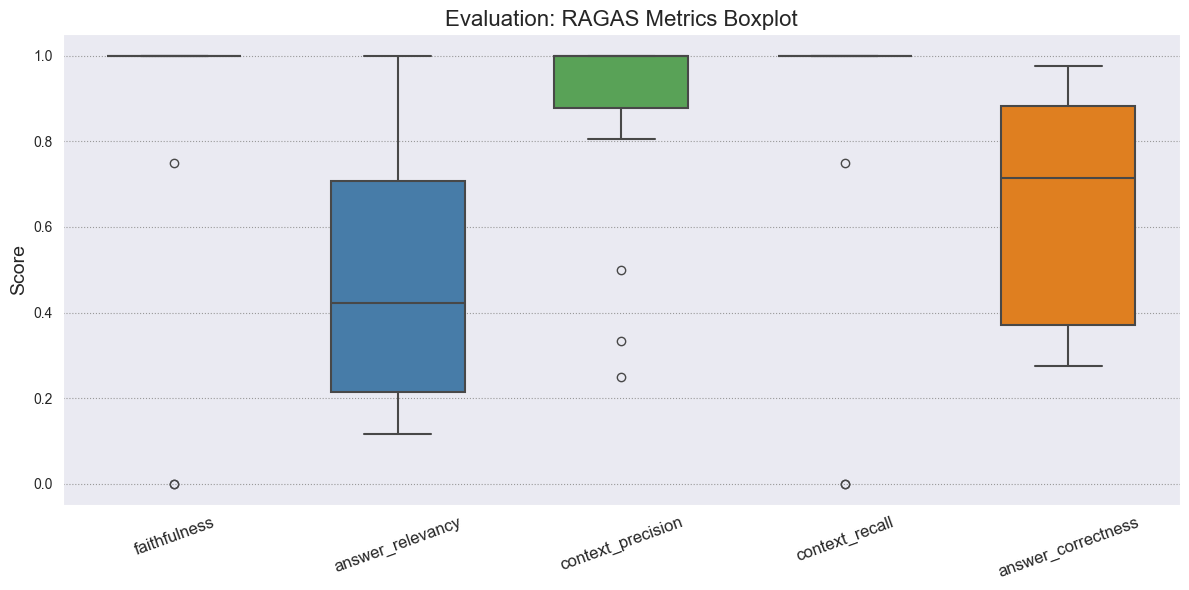

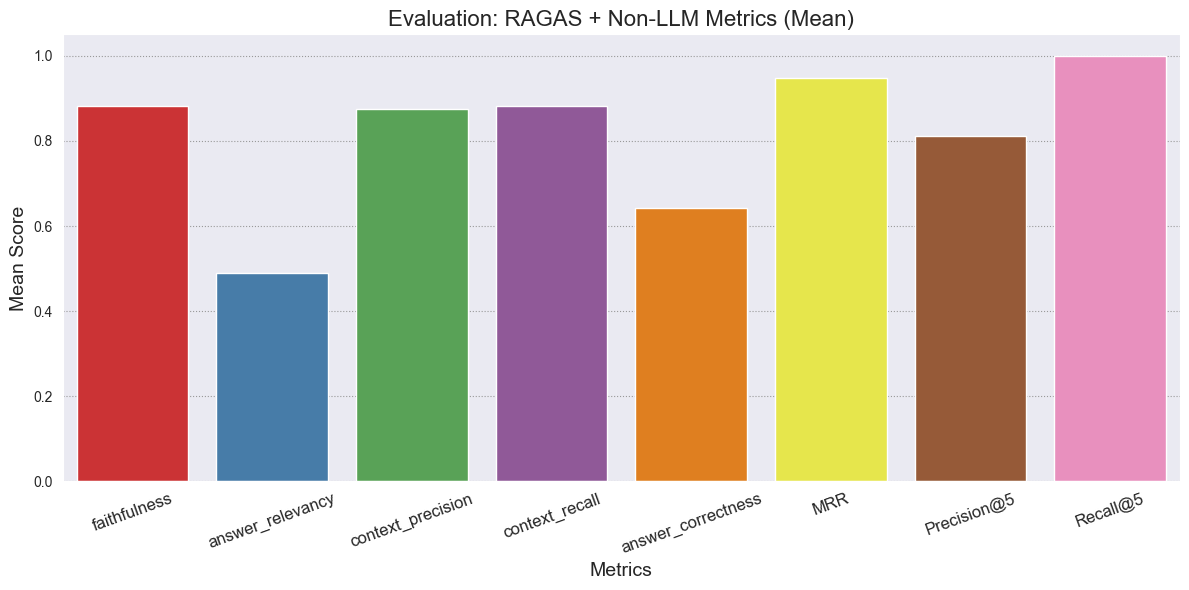

Durchschnittliche Antwortähnlichkeit: 0.8089461937183137


In [39]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_cosine_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="800_cosine_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

RecursiveCharacterTextSplitter, Cosine Similarity, Embedding ada 002

Evaluating: 100%|██████████| 95/95 [01:15<00:00,  1.26it/s]


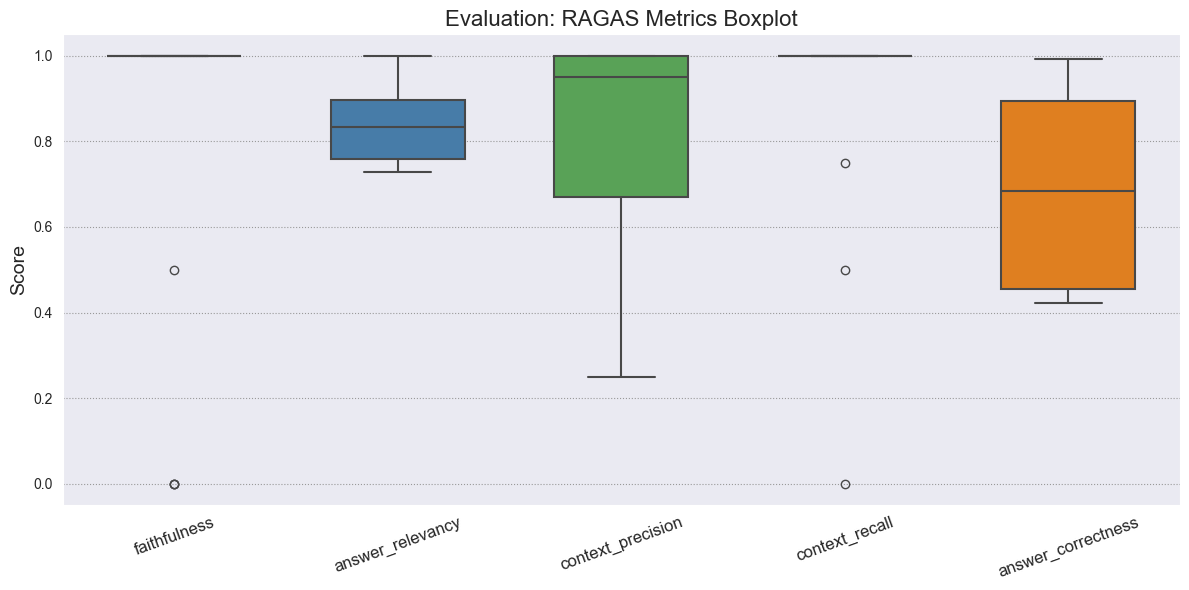

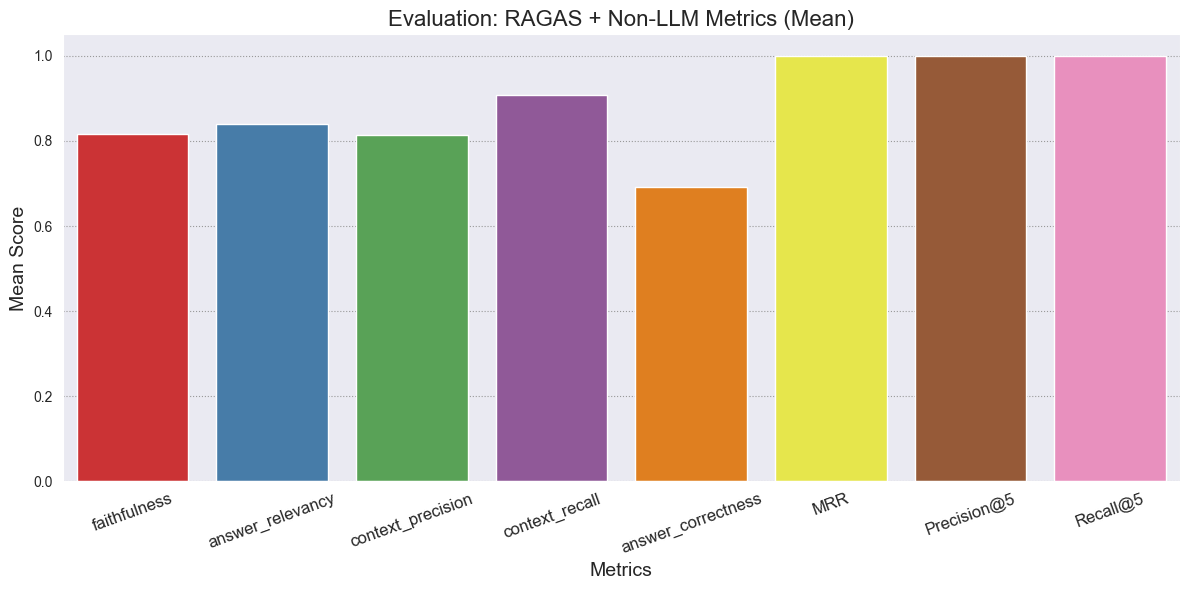

Durchschnittliche Antwortähnlichkeit: 0.9224537753013365


In [40]:
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_cosine_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_800_cosine_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

RecursiveCharacterTextSplitter, IP Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:20<00:00,  1.18it/s]


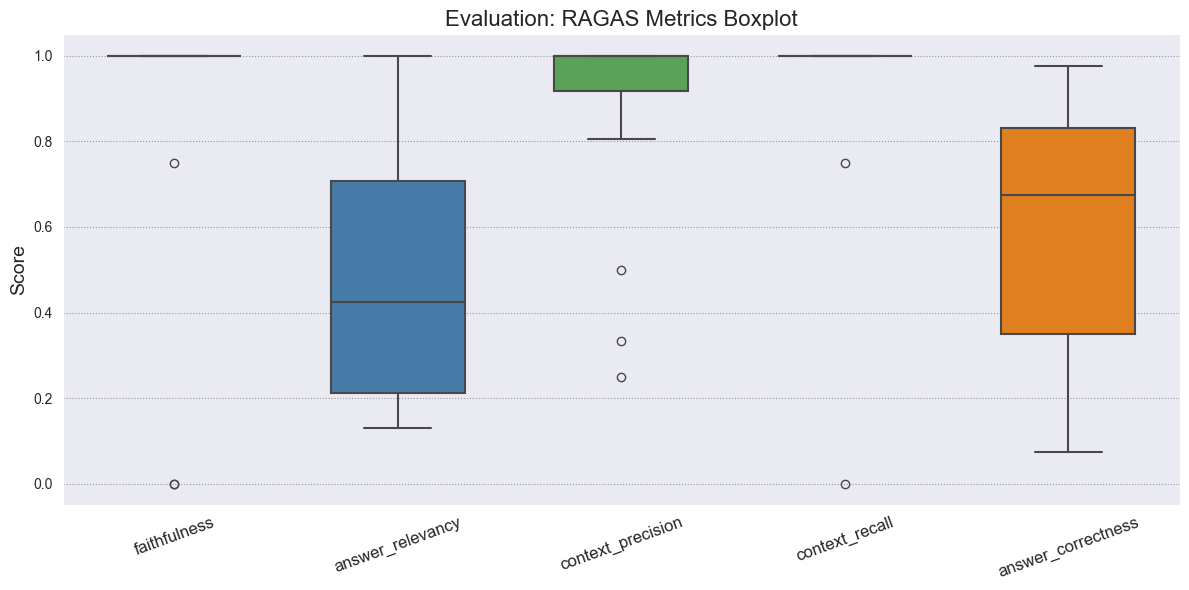

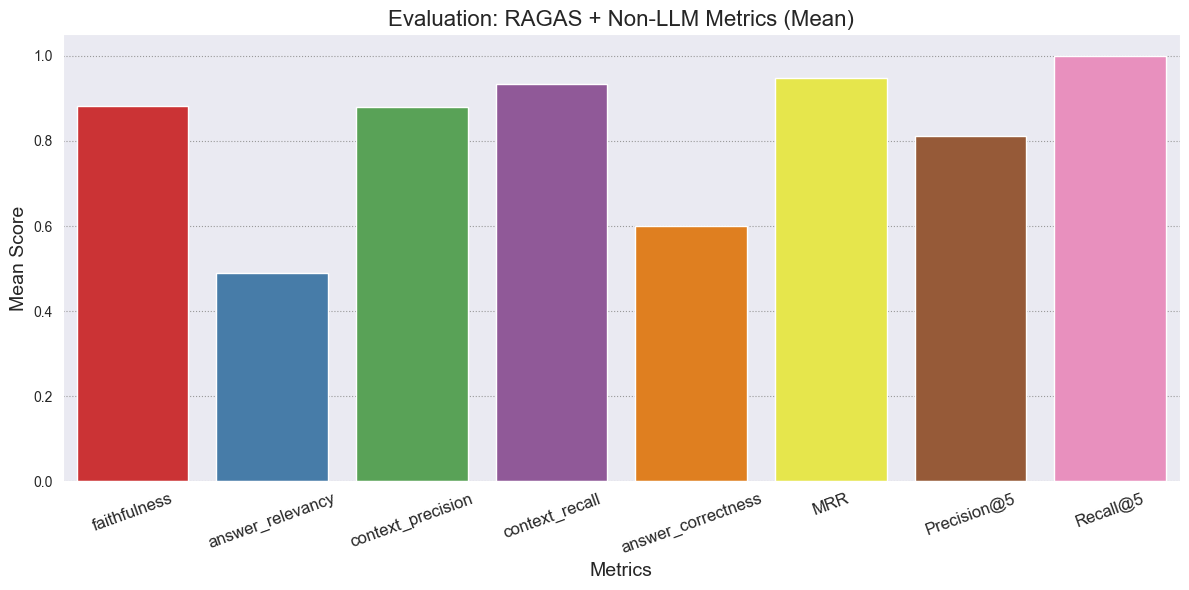

Durchschnittliche Antwortähnlichkeit: 0.7402009444554254


In [41]:
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_ip_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="800_ip_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

RecursiveCharacterTextSplitter, IP Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:18<00:00,  1.21it/s]


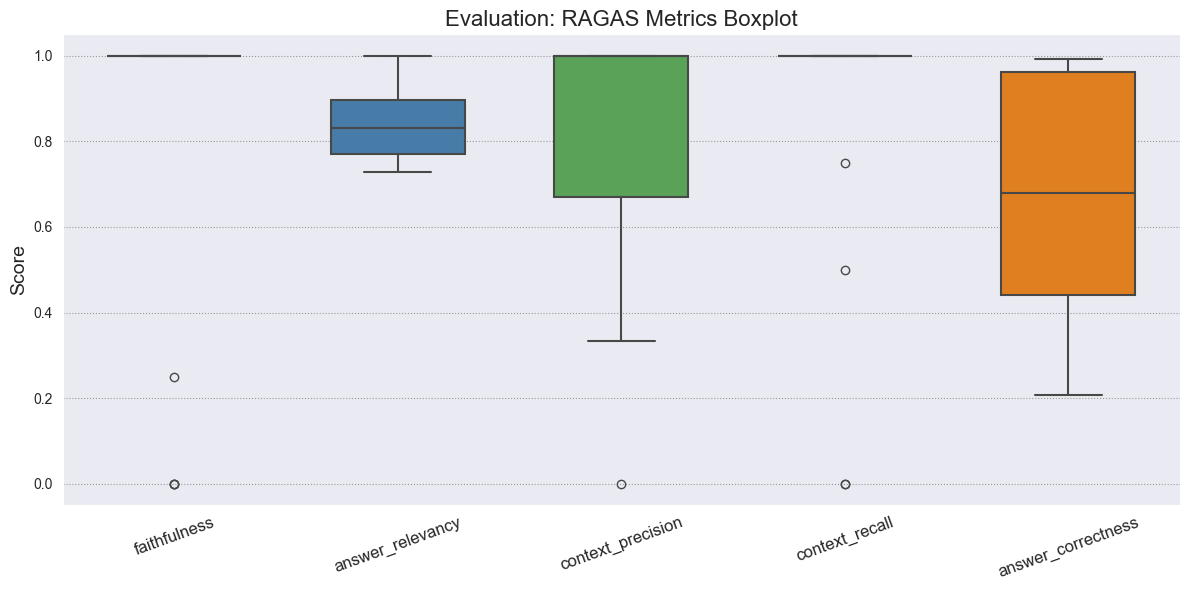

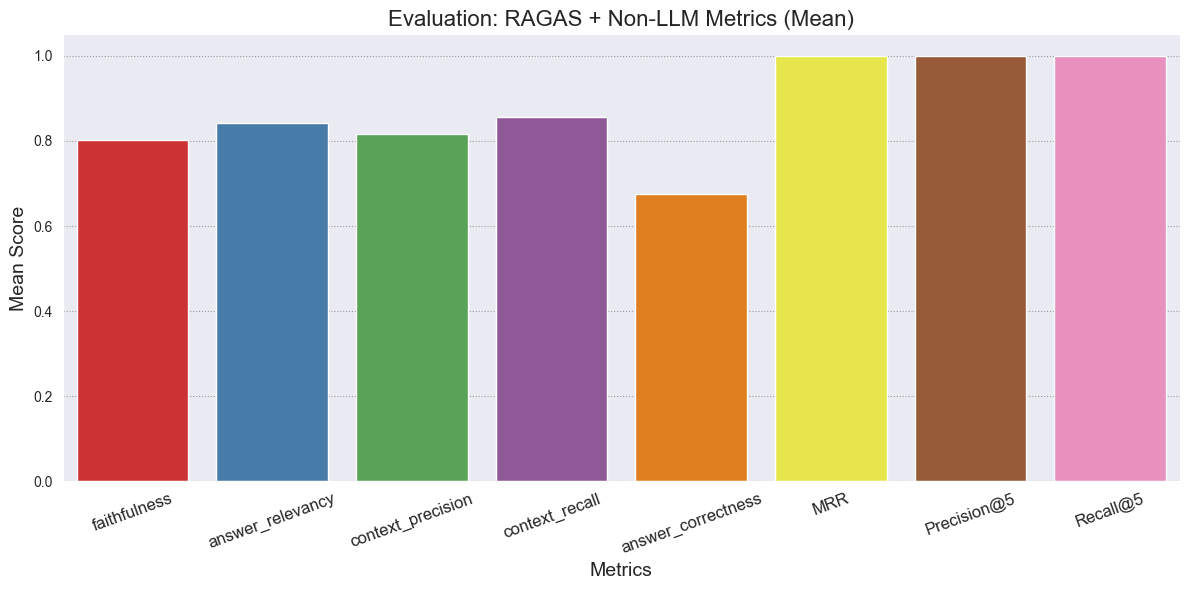

Durchschnittliche Antwortähnlichkeit: 0.9300966413118155


In [42]:
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_800_ip_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

RecursiveCharacterTextSplitter, l2 Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:19<00:00,  1.20it/s]


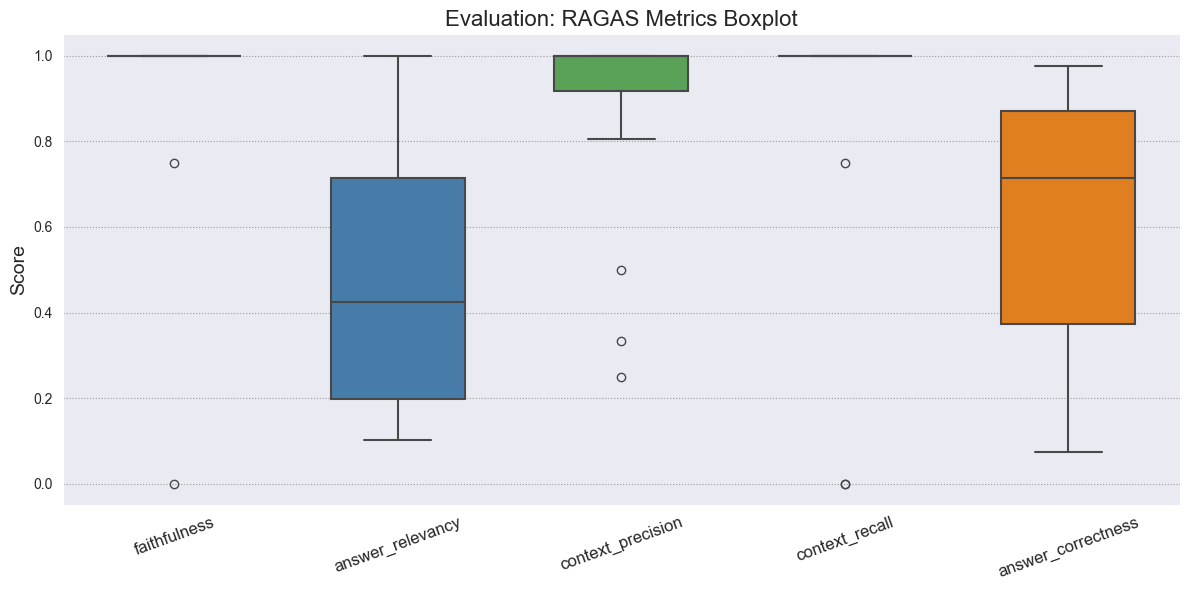

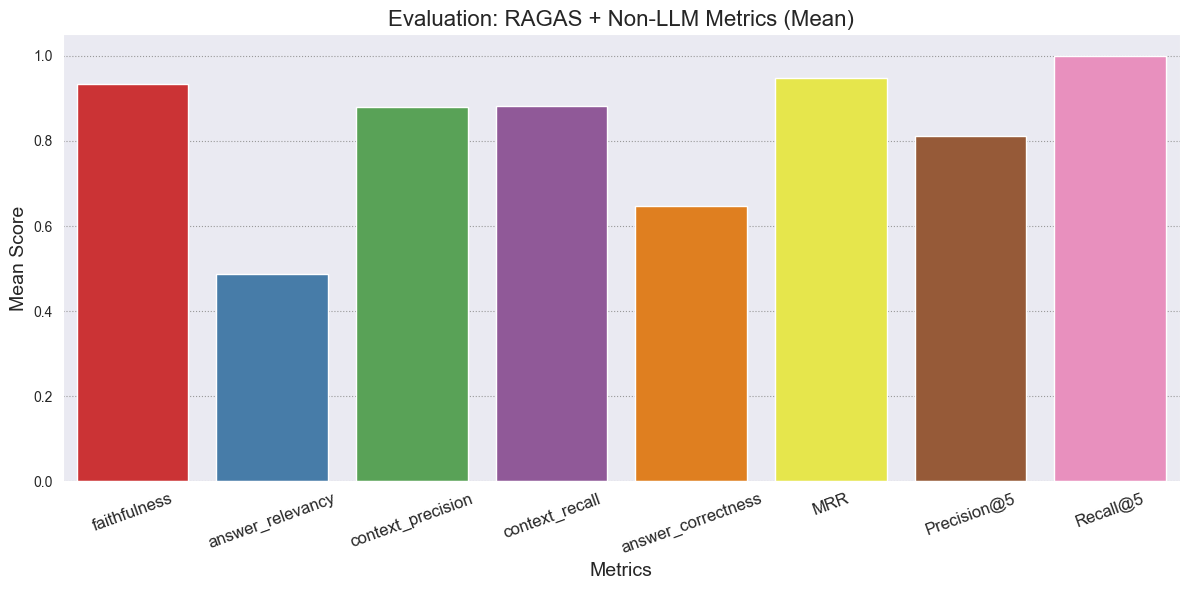

Durchschnittliche Antwortähnlichkeit: 0.7679850248820453


In [43]:
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_l2_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="800_l2_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

RecursiveCharacterTextSplitter, l2 Similarity, Embedding ada 002

Evaluating: 100%|██████████| 95/95 [01:23<00:00,  1.13it/s]


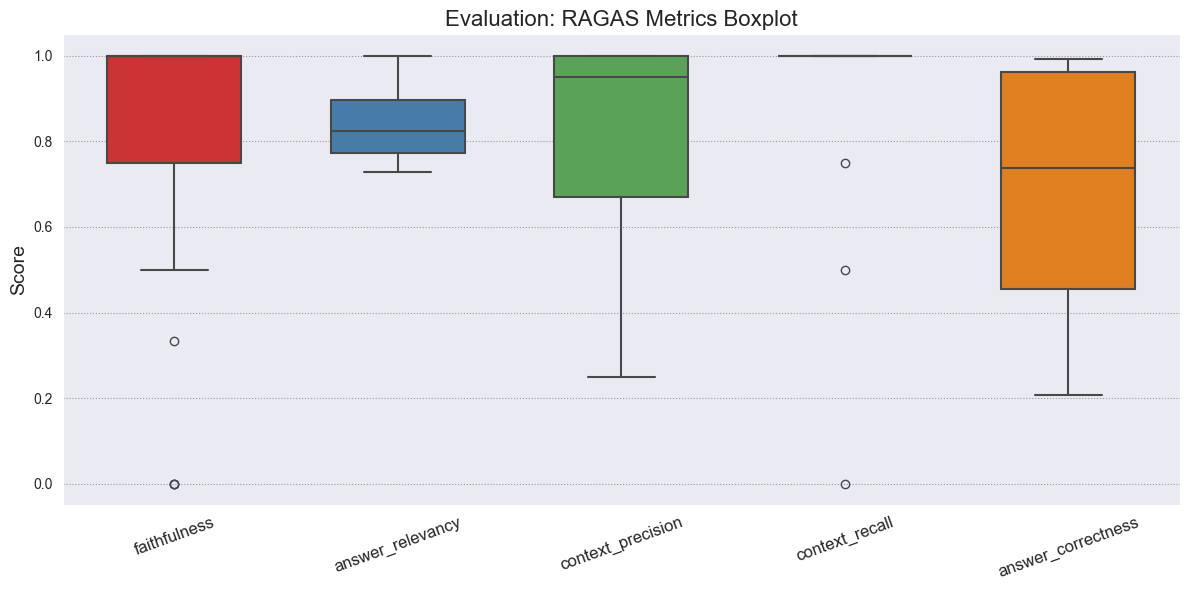

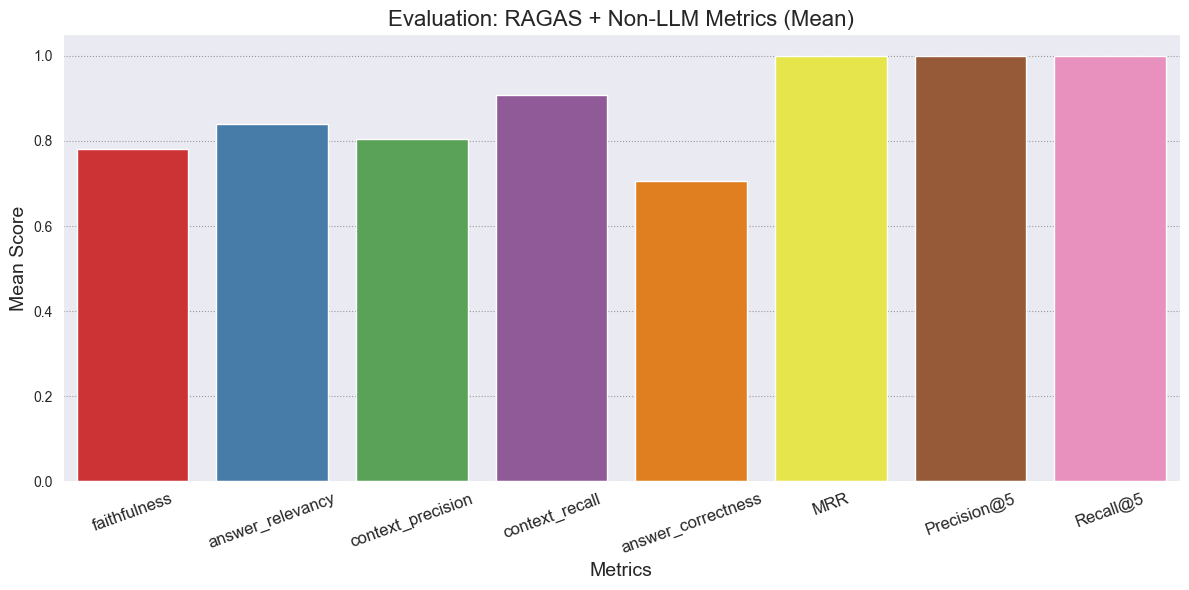

Durchschnittliche Antwortähnlichkeit: 0.9318871484441911


In [44]:
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_recchar_800_l2_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_800_l2_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, Cosine Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:27<00:00,  1.08it/s]


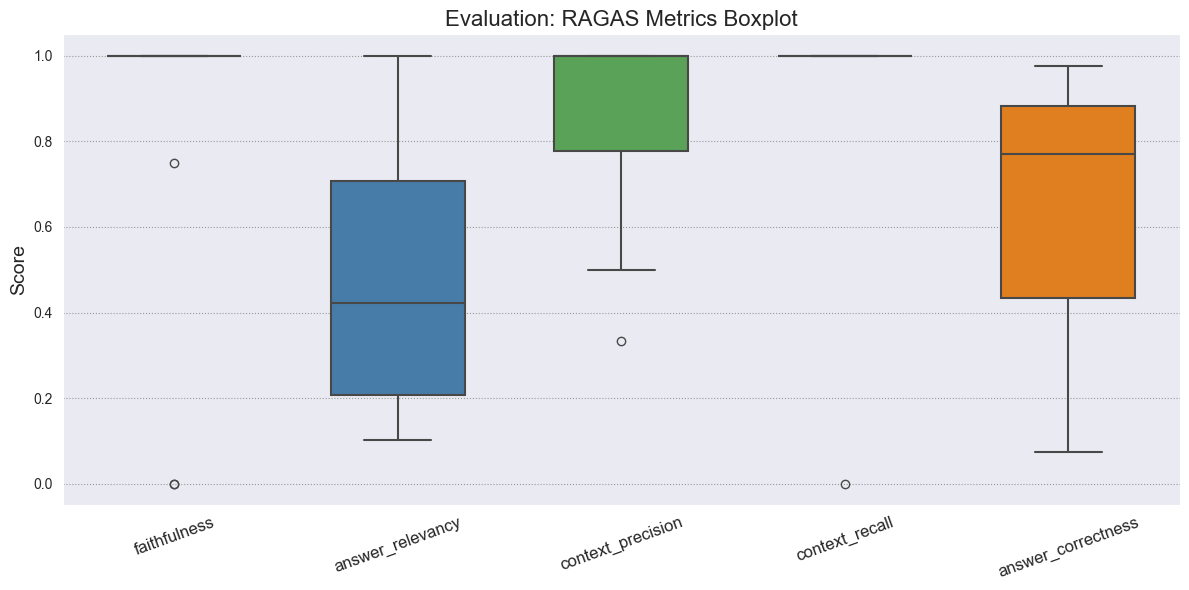

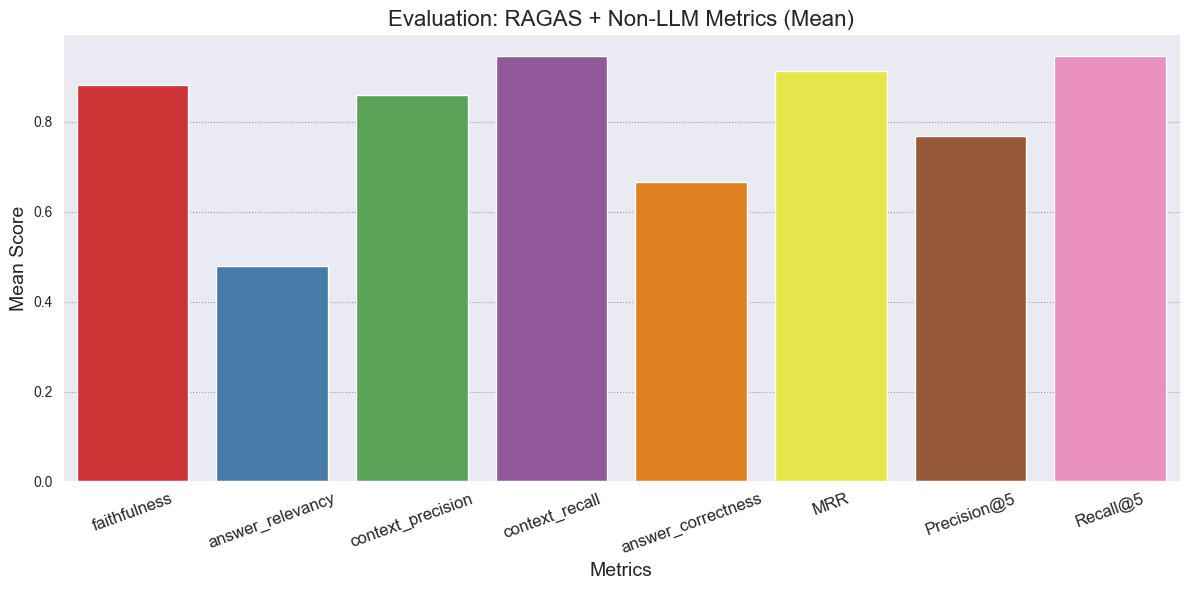

Durchschnittliche Antwortähnlichkeit: 0.8183913191958395


In [45]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_cosine_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="200_cosine_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, Cosine Similarity, Embedding ada 002

Evaluating: 100%|██████████| 95/95 [01:39<00:00,  1.05s/it]


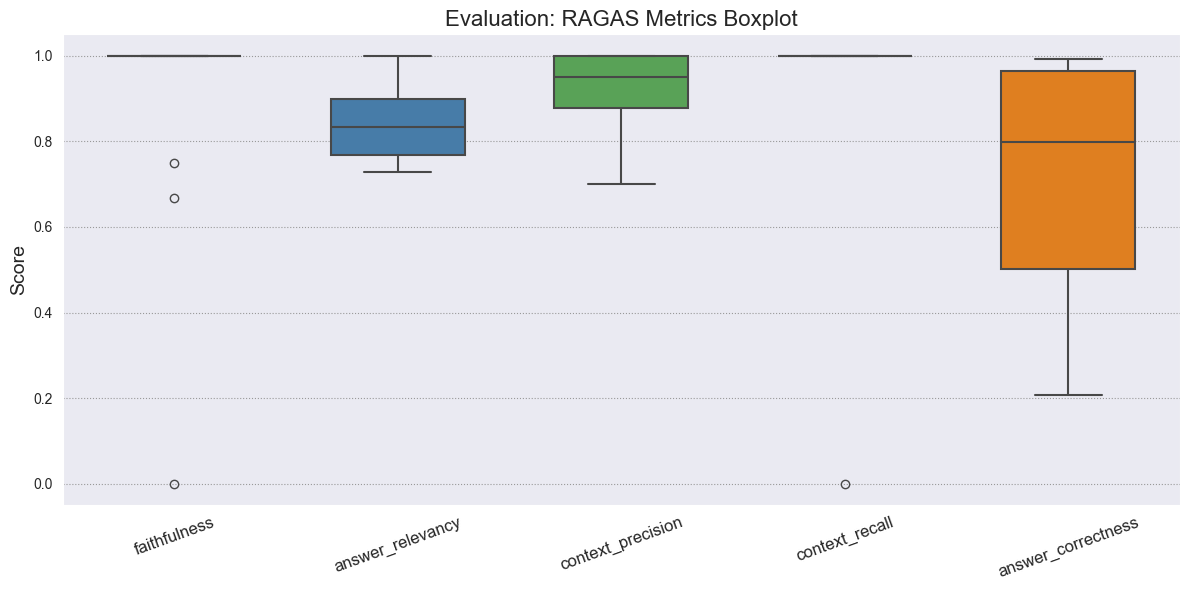

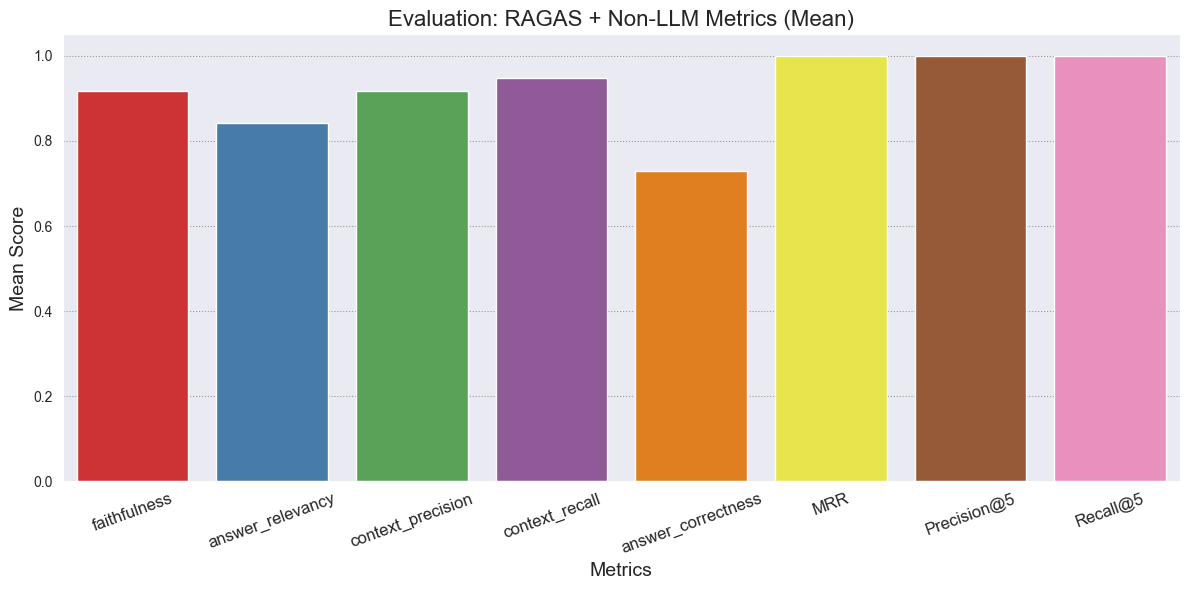

Durchschnittliche Antwortähnlichkeit: 0.9421745395976444


In [46]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_cosine_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_200_cosine_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, IP Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:41<00:00,  1.07s/it]


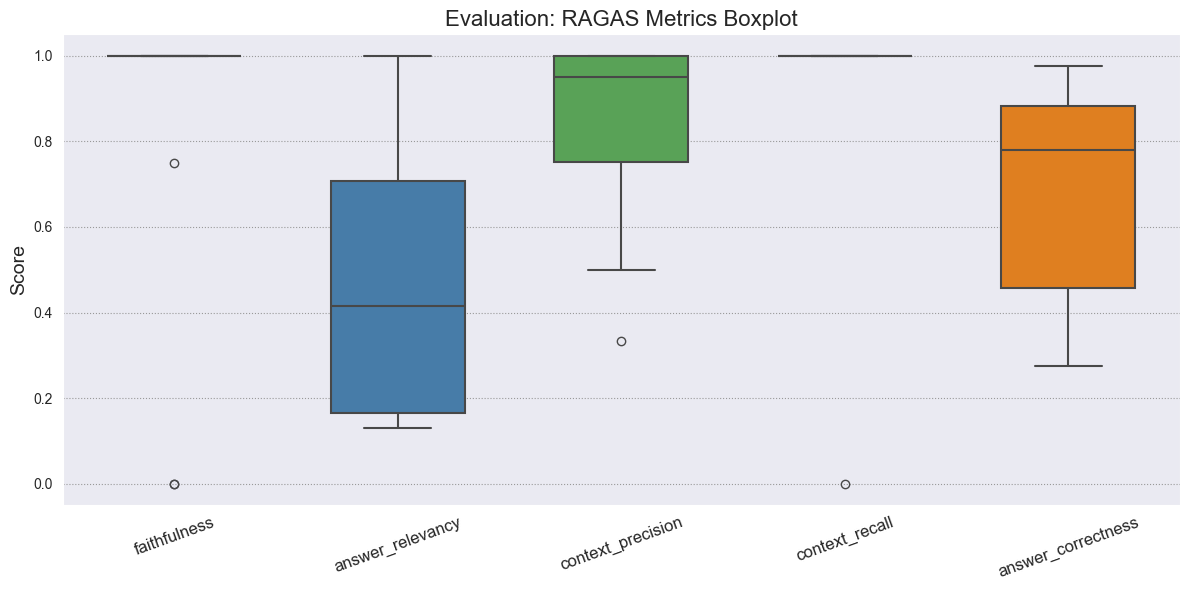

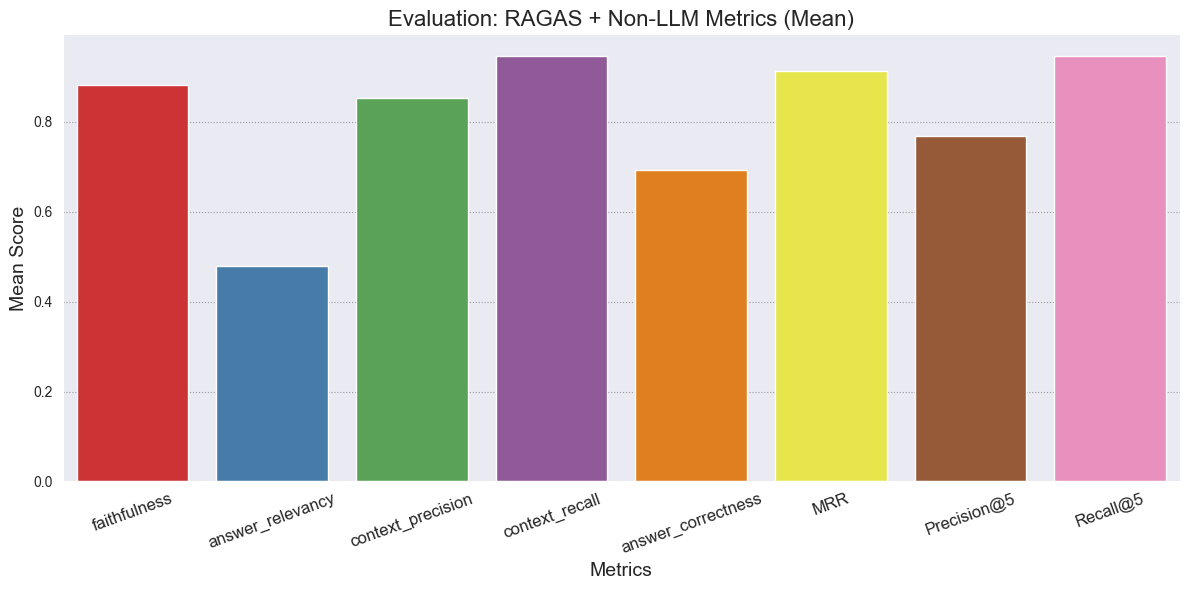

Durchschnittliche Antwortähnlichkeit: 0.8382218615881519


In [47]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="200_ip_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, IP Similarity, Embedding ada 002

Evaluating: 100%|██████████| 95/95 [01:40<00:00,  1.06s/it]


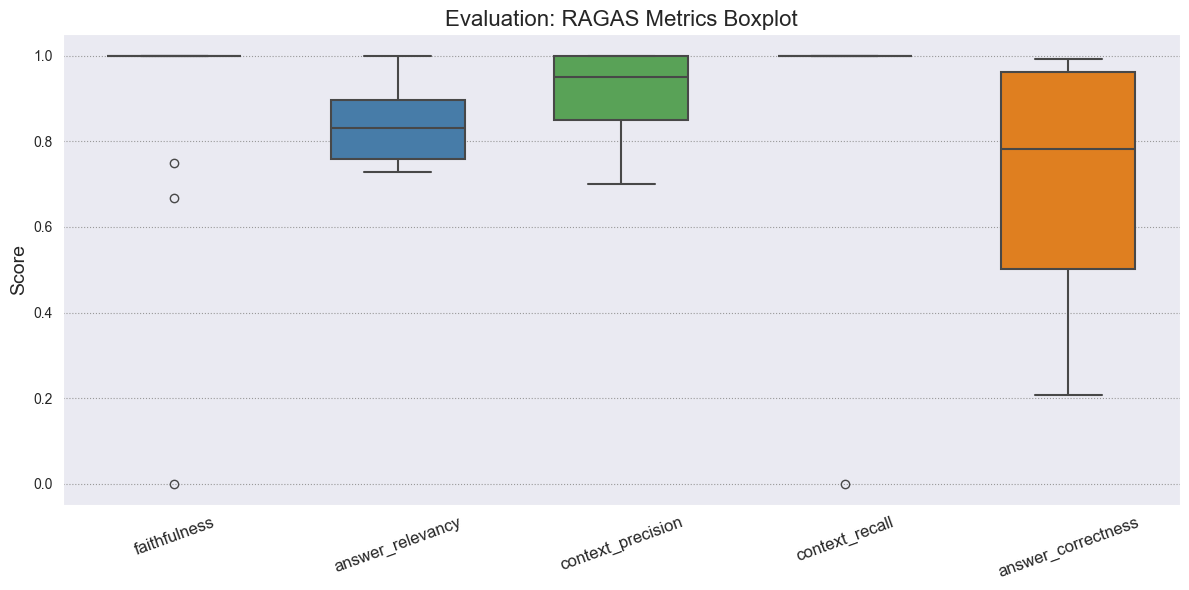

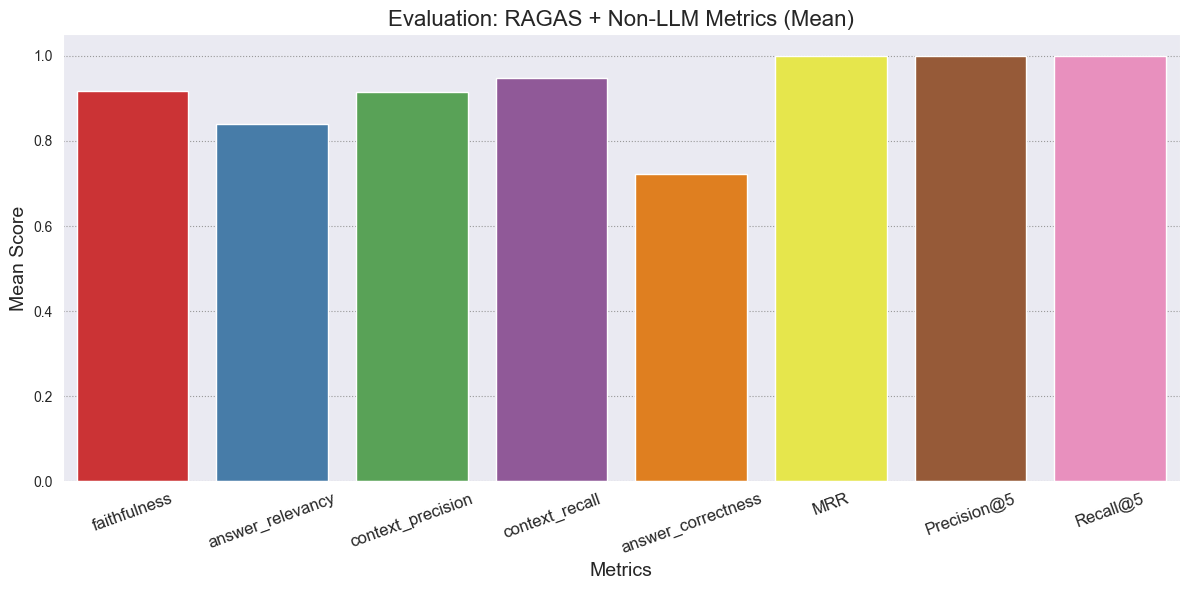

Durchschnittliche Antwortähnlichkeit: 0.9428049017660128


In [48]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_200_ip_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, l2 Similarity, Embedding 3 large

Evaluating: 100%|██████████| 95/95 [01:42<00:00,  1.08s/it]


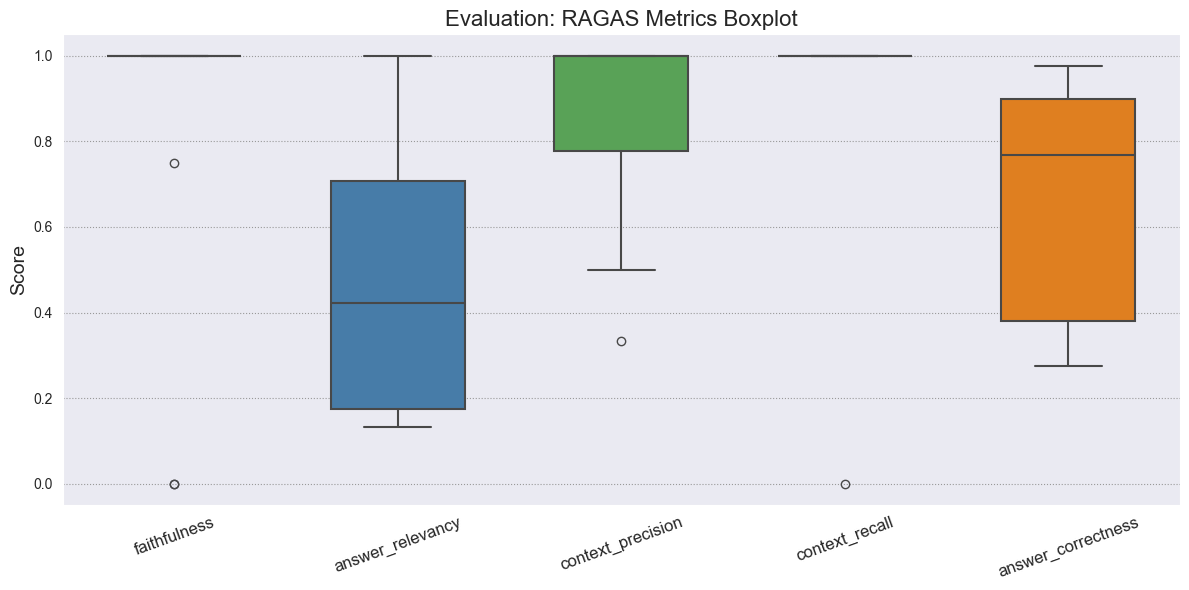

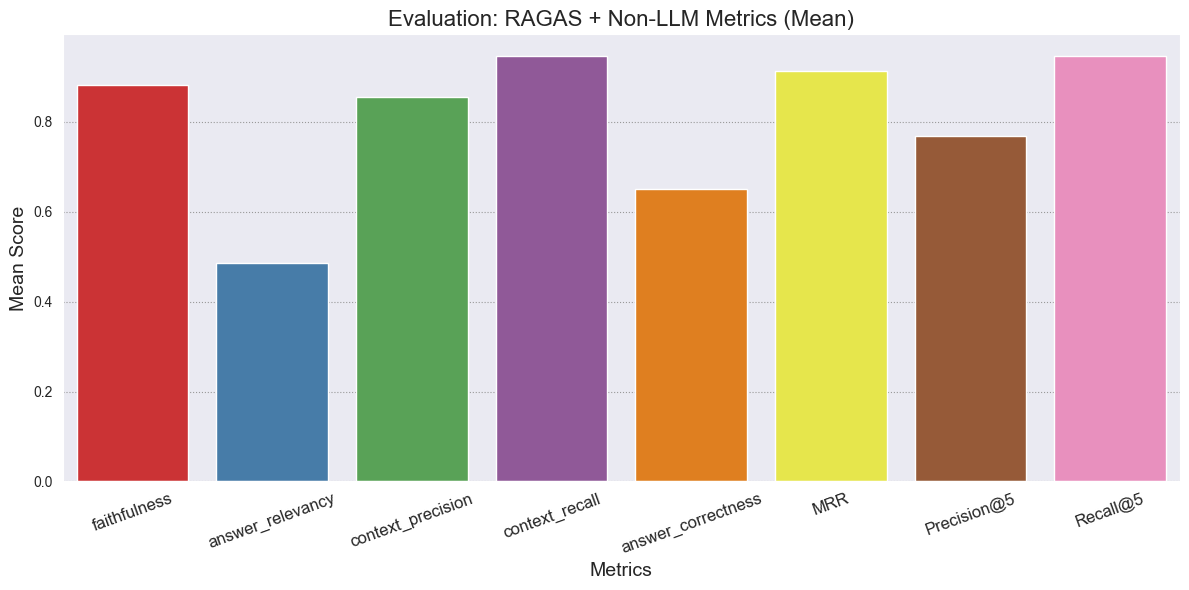

Durchschnittliche Antwortähnlichkeit: 0.8280307023708715


In [49]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-3-large")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_l2_3-large",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="200_l2_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

SentenceTransformersTokenTextSplitter, l2 Similarity, Embedding ada 002

Evaluating: 100%|██████████| 95/95 [01:39<00:00,  1.05s/it]


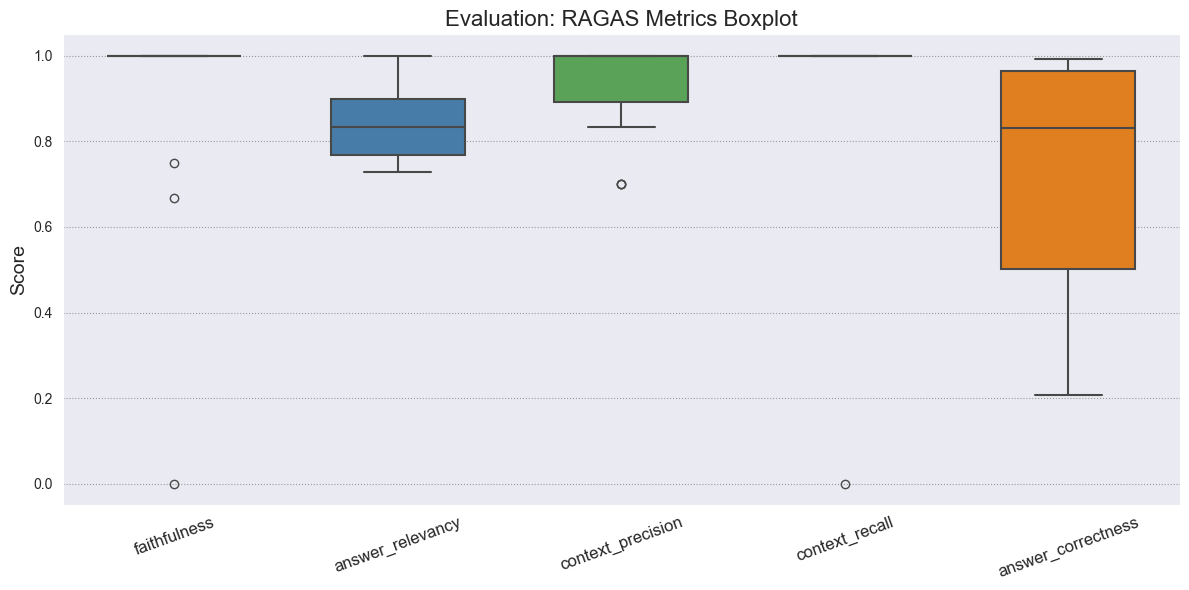

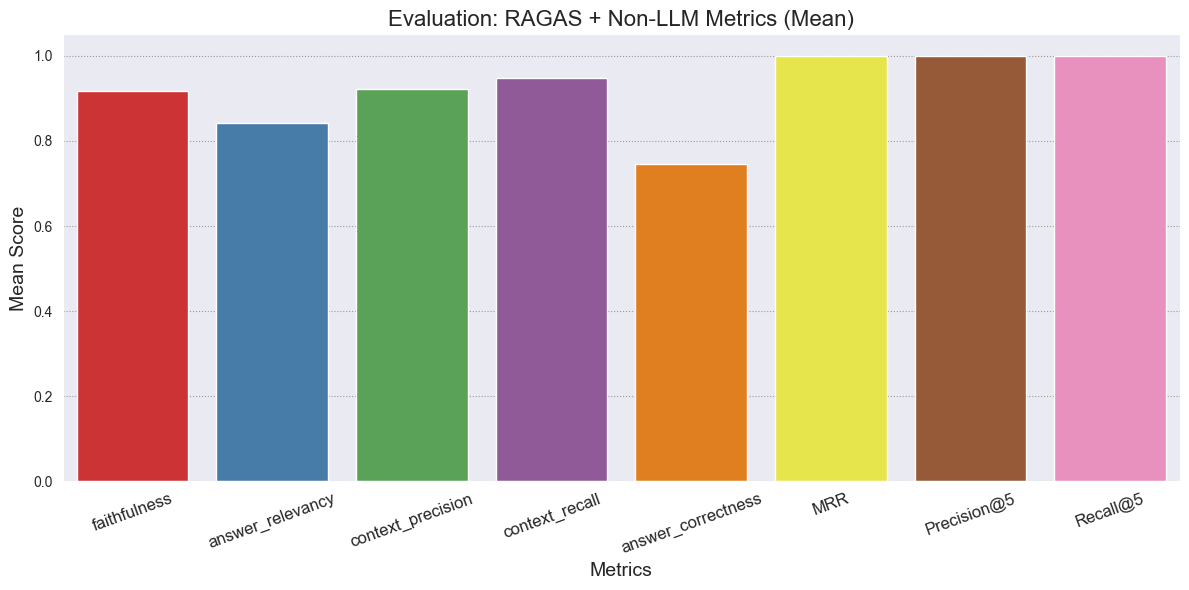

Durchschnittliche Antwortähnlichkeit: 0.9413381270921989


In [50]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_l2_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="ada_200_l2_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

### Embedding Evaluation: Übersicht der Mittelwerte

| Emb. Modell | Distanzmetrik | Splitter    | Chunks | Faithfulness | Answer Relevance | Context Precision | Context Recall | Answer Correctness | MMR  | Precision@k | Recall@k | Similarity to Gold |
|-------------|----------------|-------------|--------|---------------|-------------------|--------------------|----------------|---------------------|------|--------------|-----------|---------------------|
| 3-large     | cosine         | recchar     | 800    | 0.88          | 0.49              | 0.88               | 0.88           | 0.66                | 0.95 | 0.81         | 1.00         | 0.778               |
| ada         | cosine         | recchar     | 800    | 0.82          | 0.84              | 0.83               | 0.91           | 0.73                | 1.00 | 1.00         | 1.00         | 0.937               |
| 3-large     | IP             | recchar     | 800    | 0.88          | 0.49              | 0.88               | 0.88           | 0.62                | 0.95 | 0.81         | 1.00         | 0.749               |
| ada         | IP             | recchar     | 800    | 0.82          | 0.84              | 0.81               | 0.88           | 0.74                | 1.00 | 1.00         | 1.00         | 0.918               |
| 3-large     | l2             | recchar     | 800    | 0.88          | 0.49              | 0.88               | 0.88           | 0.65                | 0.95 | 0.81         | 1.00         | 0.808               |
| ada         | l2             | recchar     | 800    | 0.84          | 0.84              | 0.83               | 0.88           | 0.76                | 1.00 | 1.00         | 1.00         | 0.918               |
| 3-large     | cosine         | senttrans   | 200    | 0.88          | 0.49              | 0.85               | 0.95           | 0.64                | 0.91 | 0.77         | 0.95         | 0.825               |
| ada         | cosine         | senttrans   | 200    | 0.92          | 0.84              | 0.92               | 0.95           | 0.71                | 1.00 | 1.00         | 1.00         | 0.946               |
| 3-large     | IP             | senttrans   | 200    | 0.88          | 0.49              | 0.86               | 0.95           | 0.63                | 0.91 | 0.77         | 0.95         | 0.834               |
| ada         | IP             | senttrans   | 200    | 0.86          | 0.84              | 0.92               | 0.95           | 0.70                | 1.00 | 1.00         | 1.00         | 0.943               |
| 3-large     | l2             | senttrans   | 200    | 0.88          | 0.48              | 0.84               | 0.95           | 0.68                | 0.91 | 0.77         | 0.95         | 0.835               |
| ada         | l2             | senttrans   | 200    | 0.92          | 0.84              | 0.92               | 0.95           | 0.75                | 1.00 | 1.00         | 1.00         | 0.942               |


**Stärkster Gesamtkandidat:**  
Die Kombination text-embedding-ada-002 mit Cosine Similarity erzielte durchgehend hohe Werte in allen zentralen Metriken: Faithfulness, Answer Relevance, Answer Correctness sowie besonders bei Similarity to Gold (Top-Werte: 0.946, 0.943, 0.942). Dieses Modell überzeugte durch Konsistenz und Robustheit – unabhängig von Splitter oder Distanzmetrik.

**Schwächster Kandidat:**  
Dem gegenüber zeigte sich text-embedding-3-large mit Cosine (800 Chunks) als die schwächste Variante. Trotz hoher Faithfulness (0.88) lagen Answer Relevance (0.49) und Answer Correctness deutlich unter dem Durchschnitt. Die Similarity to Gold war mit 0.778 klar unterhalb aller ada-002-Kombinationen.  

**Weitere Beobachtungen:**  

* IP (Inner Product) funktioniert deutlich besser mit ada-002 als mit 3-large. Während 3-large + IP nur 0.749 erreicht, liegt ada-002 + IP bei bis zu 0.943 – ein Hinweis auf die höhere Robustheit von ada-002 gegenüber verschiedenen Metriken.

* SentenceTransformersTokenTextSplitter zeigte keine signifikanten Vorteile gegenüber RecursiveCharacter-Splitting. Zwar wurde teils ein höherer Context Recall (1.00) erreicht, dies führte jedoch nicht zu merklichen Gewinnen bei den Endmetriken.

* 3-large zeigt über alle Konfigurationen hinweg schwache Werte bei Answer Relevance (max. 0.49), was auf eine systematische Schwäche in der semantischen Passung trotz guter Kontextabdeckung hinweist.

* Retrieval-Qualität war insgesamt sehr hoch: Recall@k = 1 und Precision@k ≥ 0.77 in allen Fällen belegen ein bereits gutes und konsistentes Retrieval-Setup.  

* Kleinere Chunking-Größen (200 Tokens) führten insbesondere zu höheren Werten bei Context Recall und Recall@k. Dies deutet darauf hin, dass feiner segmentierte Texte den Retriever dabei unterstützen, relevante Inhalte präziser zu erfassen. Der Einfluss auf generative Metriken wie Answer Correctness oder Faithfulness war hingegen geringer.  

---

**Interpretation: Konstante Top-Werte bei ada-002**  
In allen Konfigurationen mit text-embedding-ada-002 erreichten Recall@k, Precision@k und MMR konstant den Maximalwert (1.00).  
Das liegt daran, dass alle Modelle unter identischen Bedingungen (gleicher Retriever, Prompt und Temperatur) getestet wurden - Unterschiede wären also auf das Embedding zurückzuführen.  
Die konstant hohen Werte zeigen, dass ada-002 den relevanten Chunk zuverlässig und sehr weit oben im Ranking findet, was auf eine starke semantische Strukturierung im Vektorraum hinweist.  
Da Recall@k keine Streuung aufweist, eignen sich Answer Correctness, Context Recall und Similarity to Gold besser zur Unterscheidung der Embedding-Modellqualität.

---

**Fazit - text-embedding-3-large oder text-embedding-ada-002?**  
Im Vergleich zeigte sich, dass das ältere text-embedding-ada-002 trotz einfacherer Architektur insgesamt die stabilere und leistungsfähigere Lösung darstellt. Besonders bei Answer Relevance, Answer Correctness und Similarity to Gold schnitt es durchgehend besser ab (zB. 0.94 vs. 0.77).

Zwar lieferte 3-large punktuell bessere Werte bei Context Precision und Faithfulness, jedoch war das Modell insgesamt inkonsistenter und weniger geeignet für den Einsatz in einem robusten RAG-System.

Für die **weitere Evaluierung wurde daher die Kombination text-embedding-ada-002 + SentenceTransformersTokenTextSplitter + IP Similarity gewählt.** Dieses Setup überzeugte nicht nur mit Bestwerten in Similarity to Gold, sondern auch durch ausgeglichene und hohe Werte in den embeddingsensitiven Metriken:  
Context Recall, Answer Correctness, Recall@k und Similarity to Gold lagen alle auf hohem Niveau - ein deutlicher Hinweis auf die Qualität und Robustheit des gewählten Embeddings.  

Eine gleichwertige Alternative stellt die Kombination mit Cosine Similarity dar, da sich die Metrik-Werte nur minimal unterscheiden.  

### Evaluierung Retrieval

Um die Auswirkungen verschiedener Retriever- und Prompting-Strategien isoliert bewerten zu können, wurden das Embedding-Modell (text-embedding-ada-002 + SentenceTransformersTokenTextSplitter + IP Similarity) sowie die Temperatur bei der Antwortgenerierung konstant gehalten.

Die Qualität der Kombinationen zeigt sich besonders in den Metriken Context Recall, Faithfulness, Answer Relevance und Answer Correctness, da diese unmittelbar davon abhängen, wie gut relevante Informationen gefunden und inhaltlich korrekt verarbeitet werden. Unterschiede in diesen Werten geben Aufschluss darüber, wie effektiv ein Retriever-Prompt-Paar passende Kontexte identifiziert und für die Antwortgenerierung nutzbar macht.

Evaluating: 100%|██████████| 95/95 [01:17<00:00,  1.23it/s]


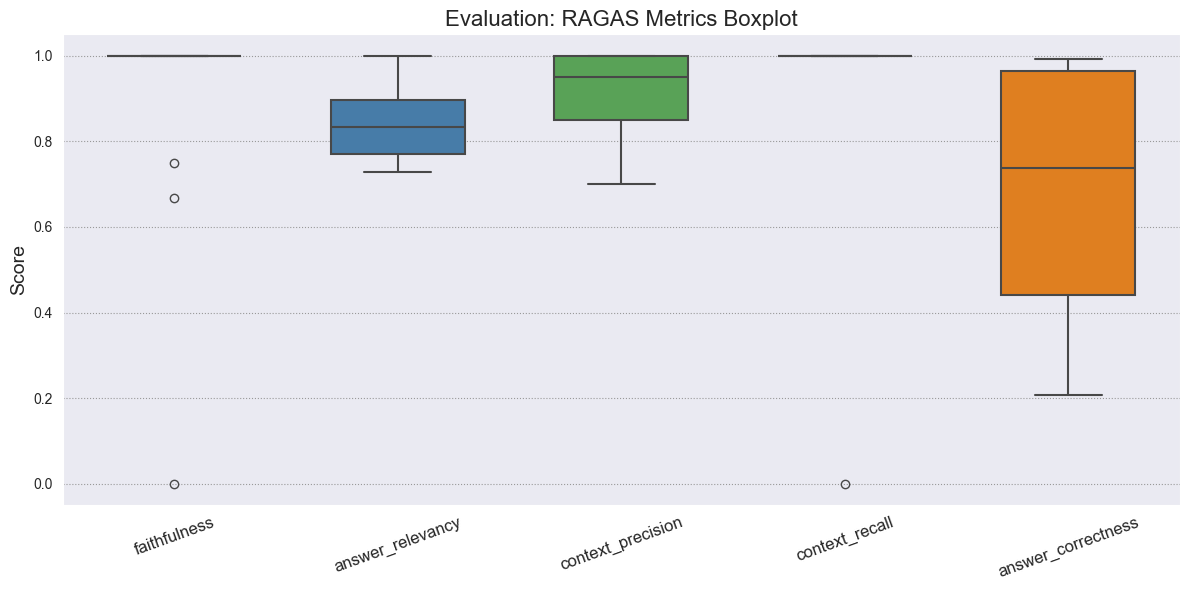

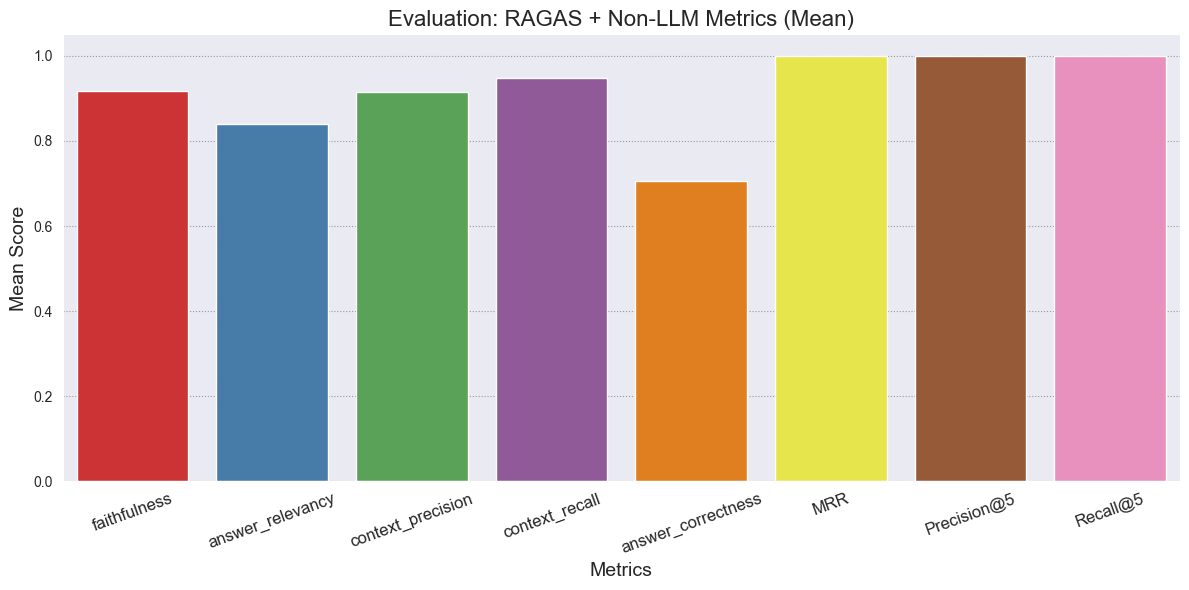

Durchschnittliche Antwortähnlichkeit: 0.8449529152214904


In [51]:
# Ausführung des Codes
evaluator = RAGAS_Evaluator(embedding_deployment="text-embedding-ada-002")

results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="chain_of_thought",
    temperature=0.3,
    save_path="sim_k5_cot.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:14<00:00,  1.27it/s]


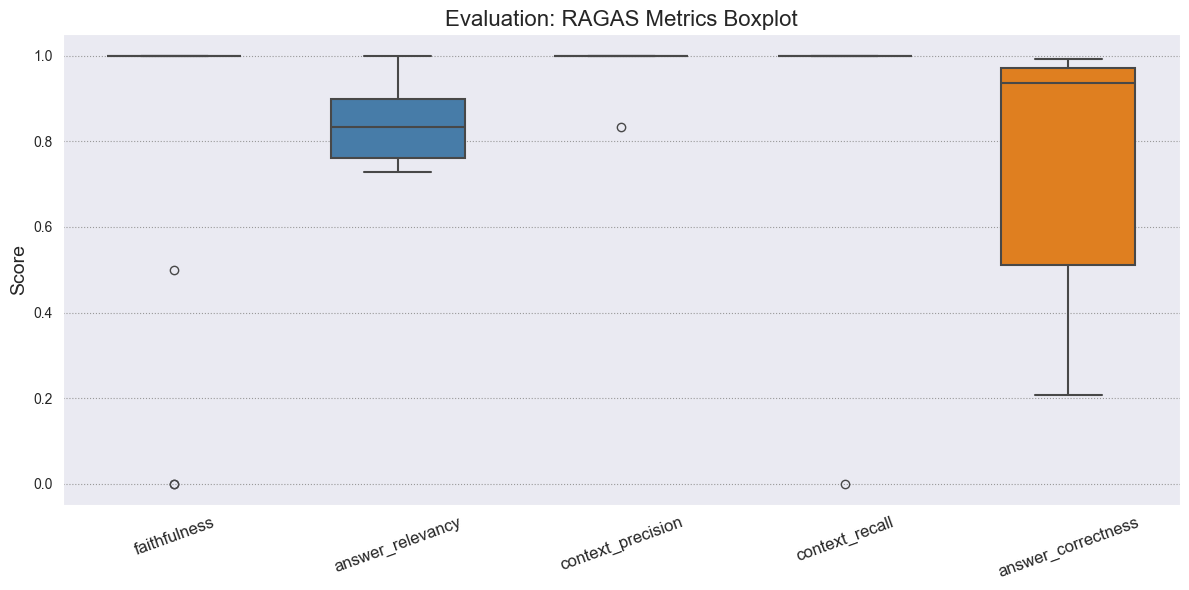

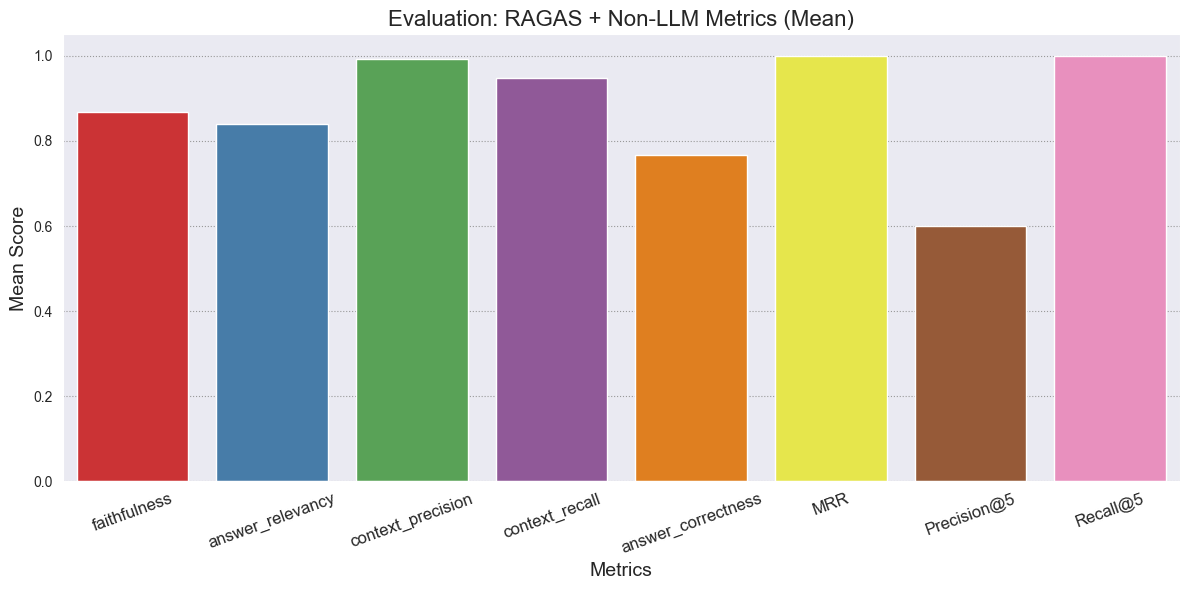

Durchschnittliche Antwortähnlichkeit: 0.9366147935818292


In [52]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k3",
    prompt_name="simple",
    temperature=0.3,
    save_path="sim_k3_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:15<00:00,  1.26it/s]


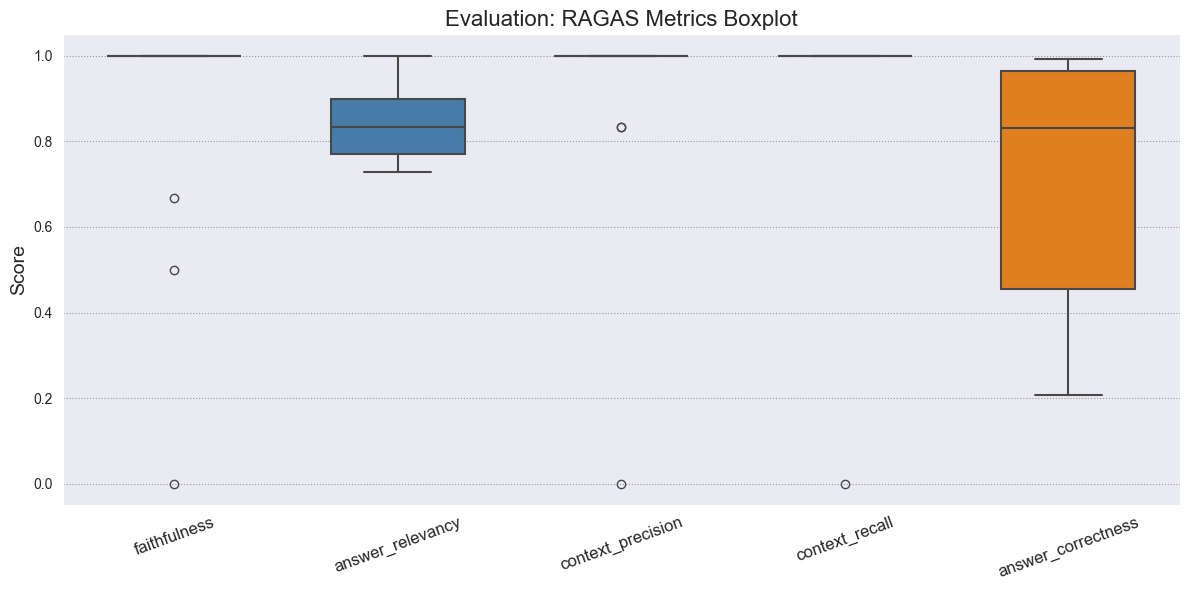

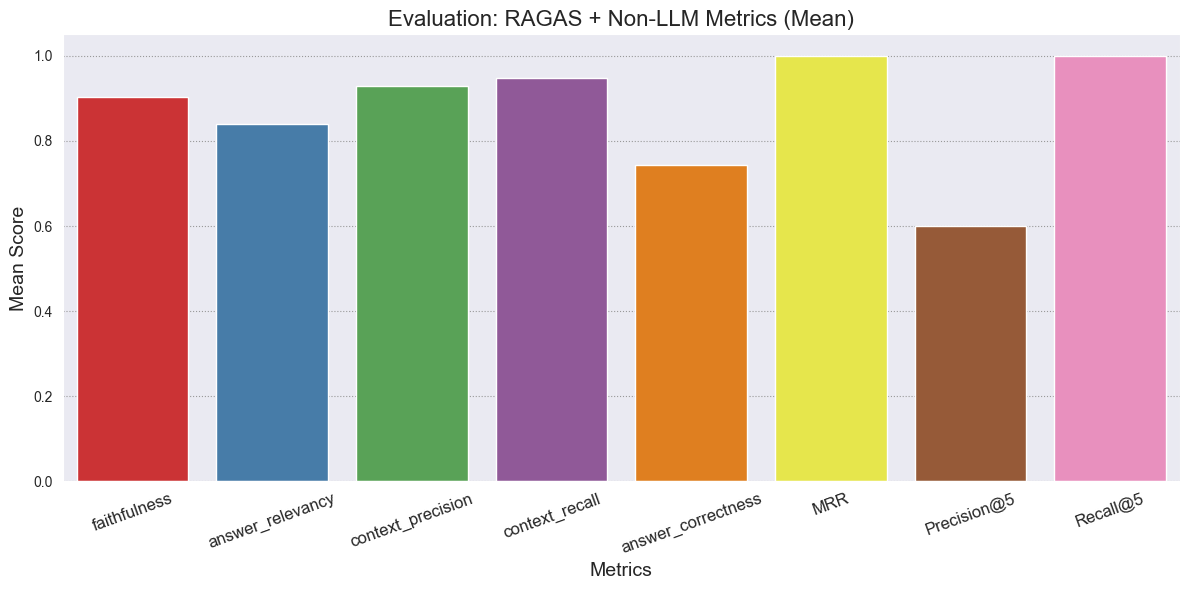

Durchschnittliche Antwortähnlichkeit: 0.8406827692445922


In [53]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k3",
    prompt_name="chain_of_thought",
    temperature=0.3,
    save_path="sim_k3_cot.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:34<00:00,  1.00it/s]


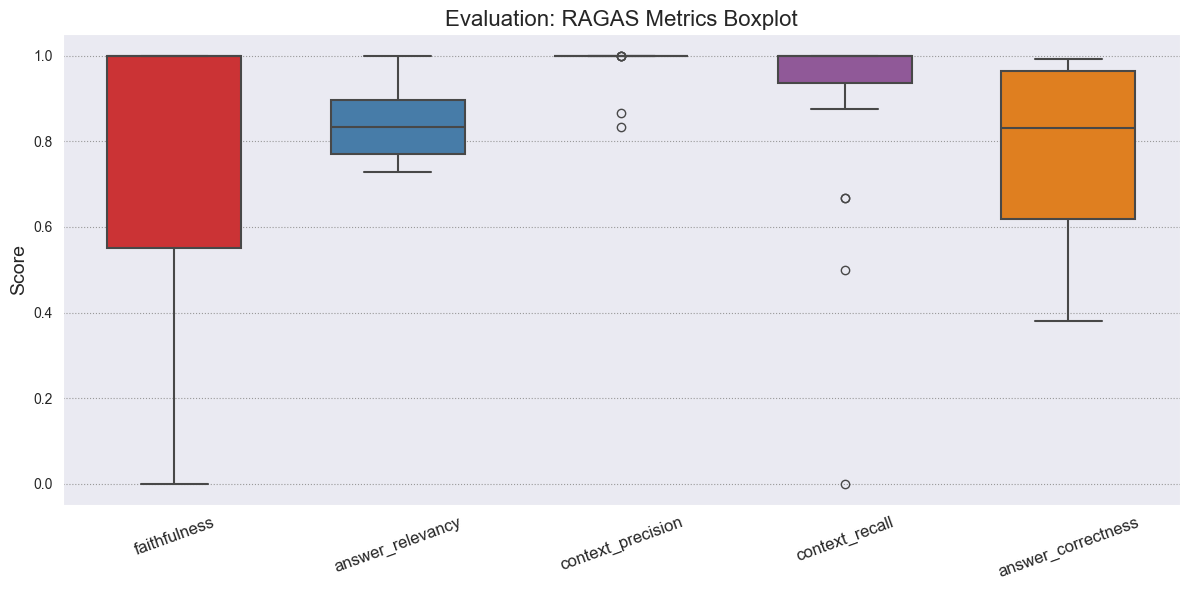

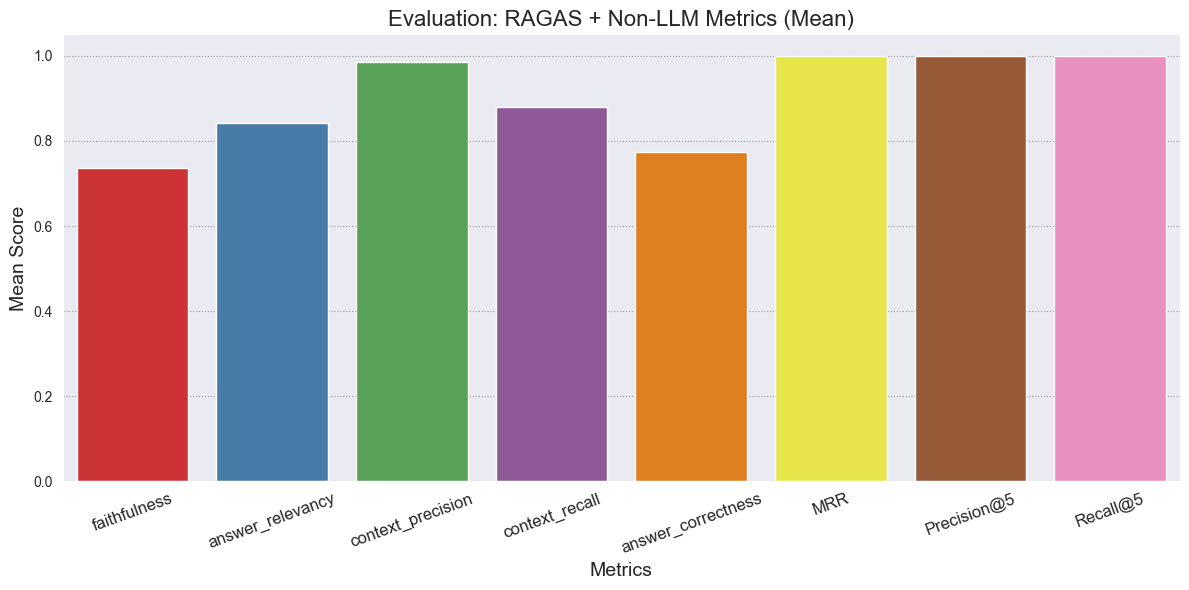

Durchschnittliche Antwortähnlichkeit: 0.896906079895636


In [54]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="mmr_k5",
    prompt_name="simple",
    temperature=0.3,
    save_path="mmr_k5_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:16<00:00,  1.24it/s]


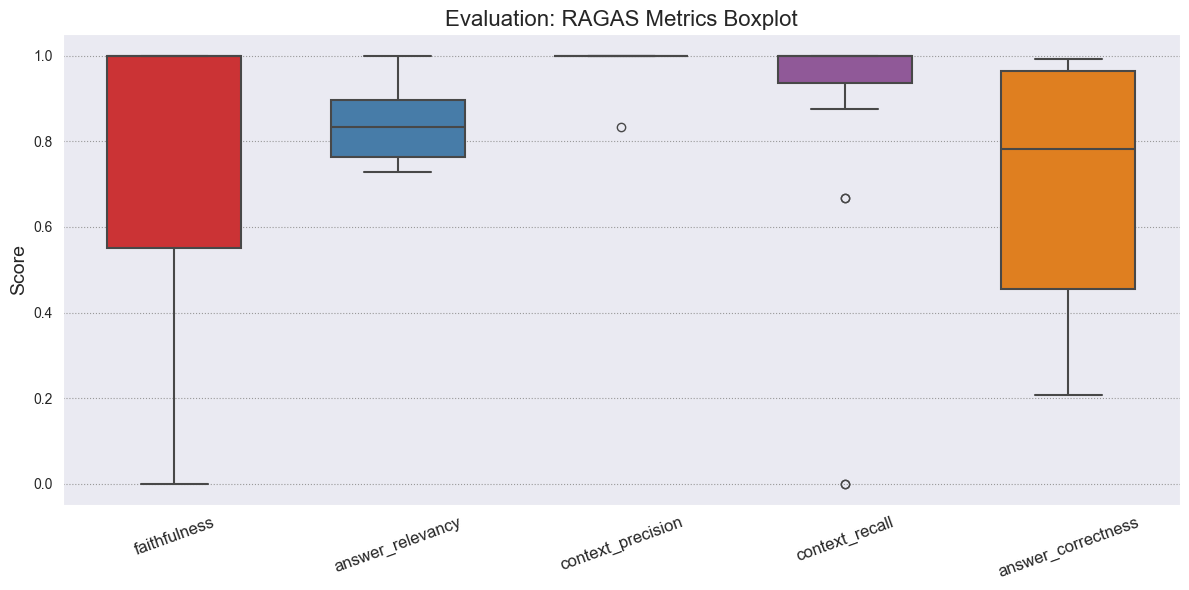

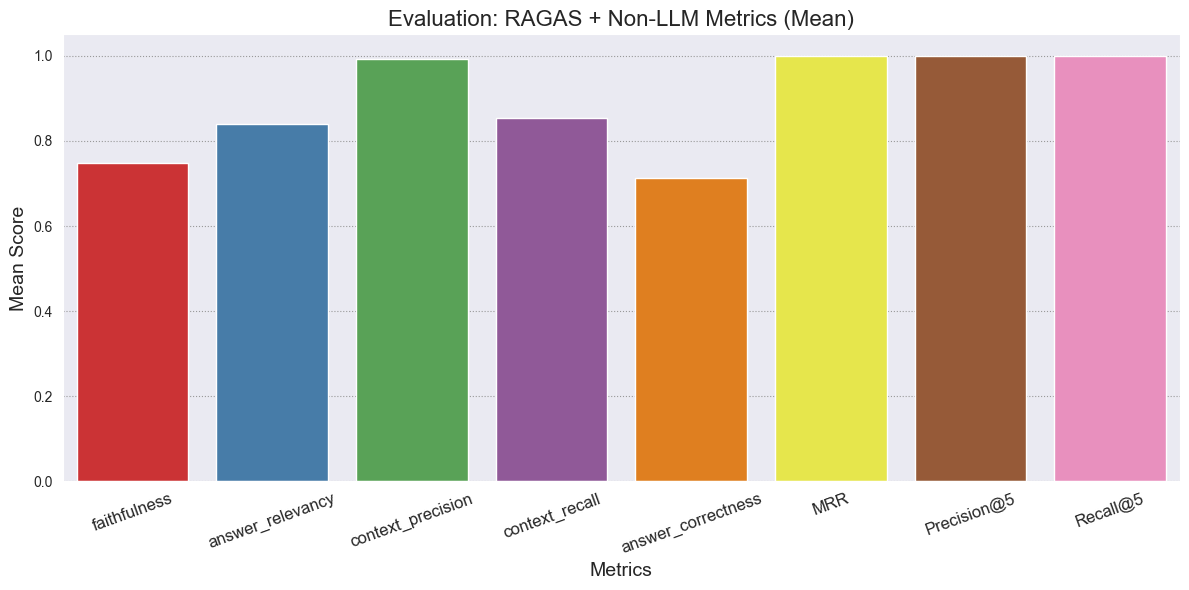

Durchschnittliche Antwortähnlichkeit: 0.8322374389077946


In [55]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="mmr_k5",
    prompt_name="chain_of_thought",
    temperature=0.3,
    save_path="mmr_k5_cot.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [02:13<00:00,  1.41s/it]


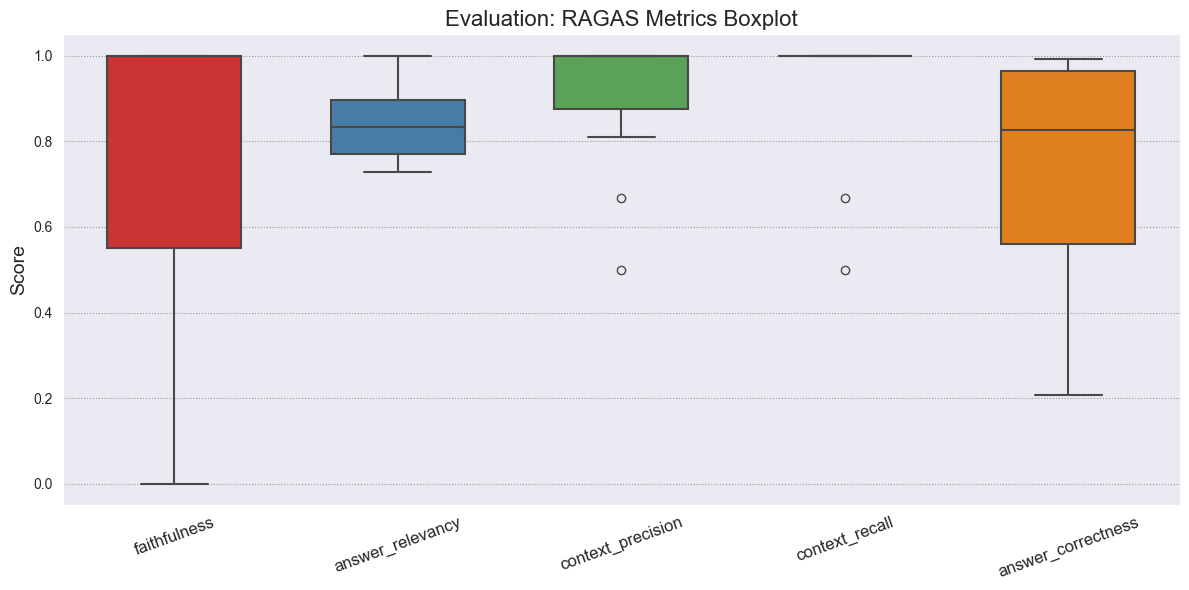

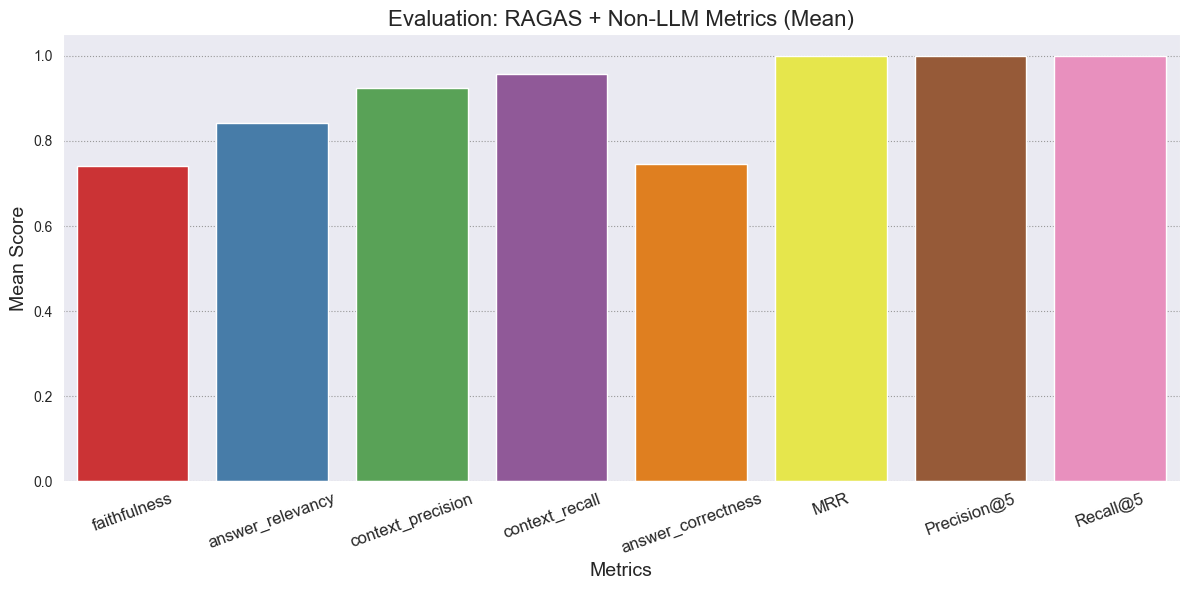

Durchschnittliche Antwortähnlichkeit: 0.90163346467248


In [56]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="mmr_k7",
    prompt_name="simple",
    temperature=0.3,
    save_path="mmr_k7_simple.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [02:09<00:00,  1.36s/it]


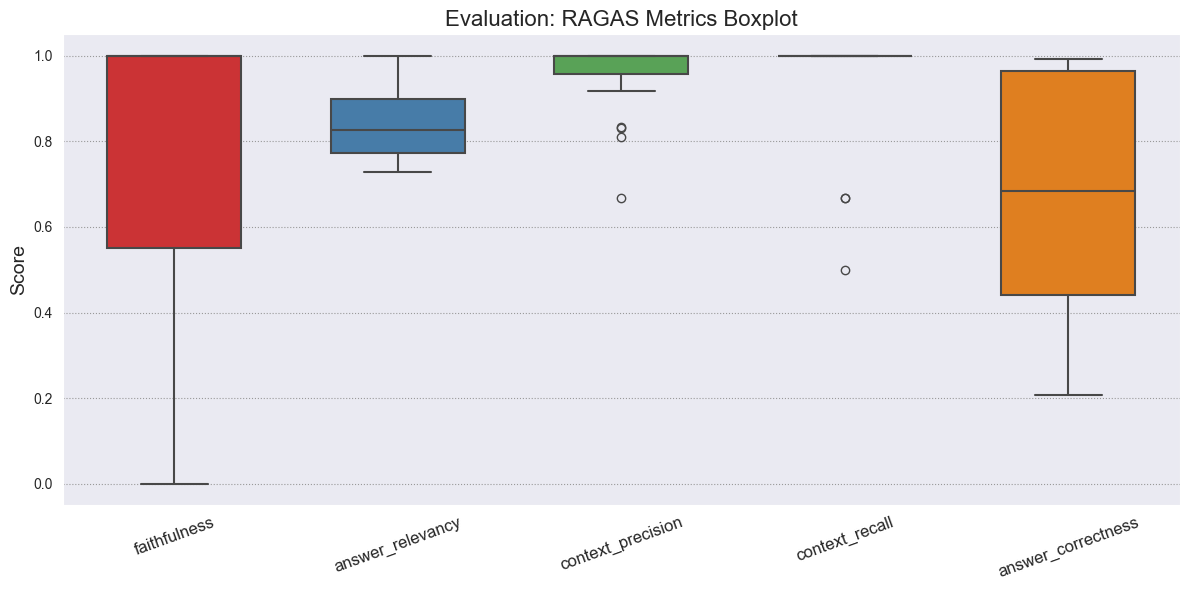

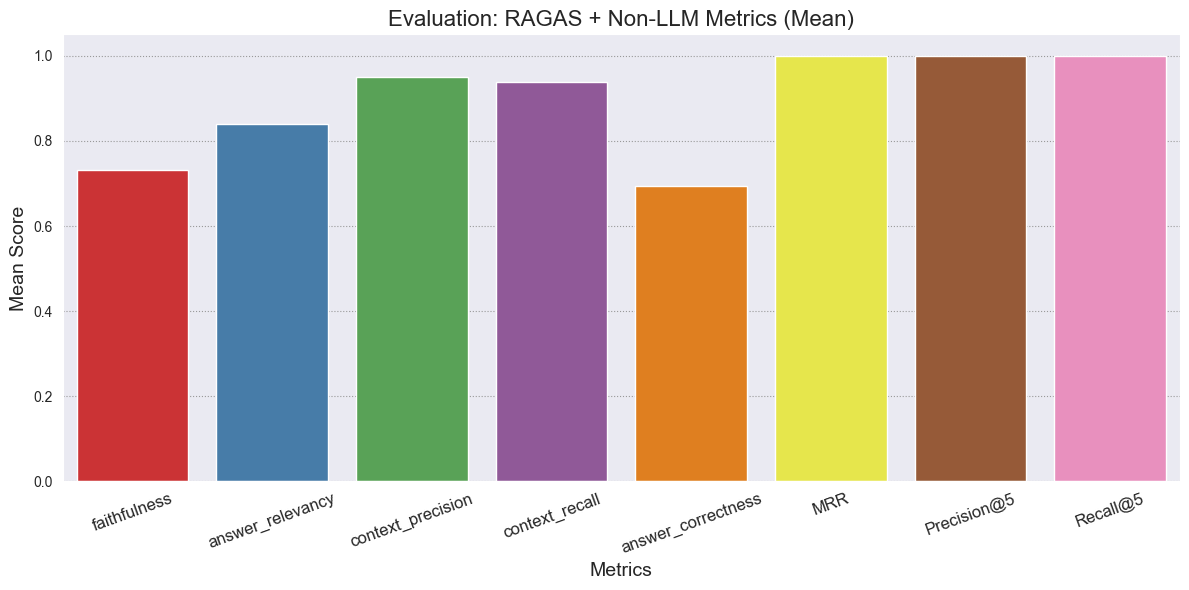

Durchschnittliche Antwortähnlichkeit: 0.8361902117960175


In [57]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="mmr_k7",
    prompt_name="chain_of_thought",
    temperature=0.3,
    save_path="mmr7_k7_cot.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

### Retriever- und Prompt-Kombinationen: Übersicht der Mittelwerte

| Retriever  | Prompt | k  | Faithfulness | Answer Relevance | Context Precision | Context Recall | Answer Correctness | MMR  | Precision@k | Recall@k | Similarity to Gold |
|------------|--------|----|--------------|------------------|-------------------|----------------|---------------------|------|--------------|-----------|---------------------|
| similarity | simple | 5  | 0.86         | 0.84             | 0.92              | 0.95           | 0.70                | 1.00 | 1.00         | 1.00      | 0.943               |
| similarity | cot    | 5  | 0.92         | 0.84             | 0.89              | 0.95           | 0.72                | 1.00 | 1.00         | 1.00      | 0.846               |
| similarity | simple | 3  | 0.90         | 0.84             | 0.99              | 0.95           | 0.68                | 1.00 | 0.60         | 1.00      | 0.933               |
| similarity | cot    | 3  | 0.82         | 0.84             | 0.93              | 0.89           | 0.71                | 1.00 | 0.60         | 1.00      | 0.844               |
| mmr, fetch_k=20        | simple | 5  | 0.75         | 0.84             | 0.98              | 0.87           | 0.75                | 1.00 | 1.00         | 1.00      | 0.899               |
| mmr, fetch_k=20        | cot    | 5  | 0.75         | 0.84             | 0.96              | 0.87           | 0.73                | 1.00 | 1.00         | 1.00      | 0.837               |
| mmr, fetch_k=20        | simple | 7  | 0.73         | 0.84             | 0.97              | 0.88           | 0.71                | 1.00 | 1.00         | 1.00      | 0.901               |
| mmr, fetch_k=20        | cot    | 7  | 0.73         | 0.84             | 0.96              | 0.88           | 0.76                | 1.00 | 1.00         | 1.00      | 0.836               |


**Evaluation der Retriever- und Prompt-Kombinationen**  
Für die Bewertung der Systemqualität wurden neben den Mittelwerten der Metriken auch Boxplots analysiert, um Streuung und Ausreißer sichtbar zu machen. Insgesamt zeigen sich klare Unterschiede zwischen den getesteten Kombinationen aus Retriever-Typ, Prompting-Strategie und dem Parameter k.

**Beste Gesamtkombination:**  
Die Kombination aus similarity Retriever, einfachem Prompt (simple) und k=5 zeigte in nahezu allen Metriken die besten oder sehr gute Werte. Sie überzeugte durch hohe Werte bei Answer Correctness (0.70), Context Precision (0.92) und Similarity to Gold (0.943) - bei gleichzeitig geringer Streuung in den Boxplots. Diese Konfiguration erwies sich als besonders robust und ausgewogen.

**Trade-off Precision@k und Recall@k:**  
In vielen Retrieval-Setups besteht ein Zielkonflikt zwischen hoher Recall-Sicherheit und Präzision. In dieser Arbeit trat dieser Zielkonflikt jedoch nicht auf, da Recall@k in allen Konfigurationen konstant bei 1.00 lag. Auch die Precision@k blieb bei k=5 und k=7 auf einem sehr hohen Niveau. Nur bei k=3 wurde eine gezielte Einschränkung der Precision (0.60) beobachtet - bedingt durch den reduzierten Suchraum.
Die Wahl von k=5 stellte somit keinen Kompromiss, sondern eine stabile und leistungsfähige Konfiguration dar.

**Einfluss von Prompting:**  
Bei Verwendung von cot-Prompts ließ sich zwar eine höhere Faithfulness (bis 0.92) beobachten, gleichzeitig sank jedoch die Answer Correctness teils leicht, und es traten vereinzelt stärkere Ausreißer auf. Vor allem bei similarity + cot + k=3 war die Streuung auffällig, was auf eine geringere Stabilität hindeutet. Insgesamt zeigte sich, dass der simple Prompt häufig stabilere Ergebnisse liefert.

**Effekte unterschiedlicher k-Werte:**  
Die Kombination similarity + simple + k=3 erzielte hohe Mittelwerte, litt jedoch bei Precision@k (nur 0.60), was auf eine Einschränkung im Retrieval hindeutet. Höhere k-Werte wie k=7 (bei MMR) führten hingegen zu hohen Recall-Werten und guter Kontextabdeckung - besonders in Kombination mit simple Prompt.

**MMR-Retriever im Vergleich:**  
MMR-Strategien schnitten besonders bei Answer Correctness gut ab (bis 0.76 bei mmr + cot + k=7) und erreichten durchgängig hohe Kontextmetriken. Die Unterschiede zwischen cot und simple waren beim MMR-Retriever geringer ausgeprägt als bei Similarity, wobei simple leicht stabilere Resultate zeigte.

**Schwächste Kombination:**  
Die Kombination similarity + cot + k=3 fiel im Vergleich deutlich ab. Trotz guter Mittelwerte in einigen Metriken traten auffällige Ausreißer auf, insbesondere bei Faithfulness und Context Recall, was auf eine geringe Zuverlässigkeit in der Antwortqualität schließen lässt.

**Fazit:**  
Für eine ausgewogene Performance mit hoher Robustheit ist die Konfiguration **similarity + simple + k=5 die beste Wahl**, weshalb diese Konfiguration verwendet wird um nun die Auswirkung der Temperatur zu untersuchen. Je nach Anwendungsfall können MMR-basierte Kombinationen mit k=7 ebenfalls sinnvoll sein, insbesondere wenn maximale Kontextabdeckung im Vordergrund steht. Cot-Prompts sind nicht grundsätzlich überlegen und sollten gezielt eingesetzt werden, wenn argumentative oder schrittweise Antworten erwünscht sind.

### Evaluierung Temperatur

Evaluating:  98%|█████████▊| 93/95 [03:00<00:53, 26.77s/it]ERROR:ragas.executor:Exception raised in Job[4]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[40]: TimeoutError()
Evaluating: 100%|██████████| 95/95 [03:09<00:00,  2.00s/it]


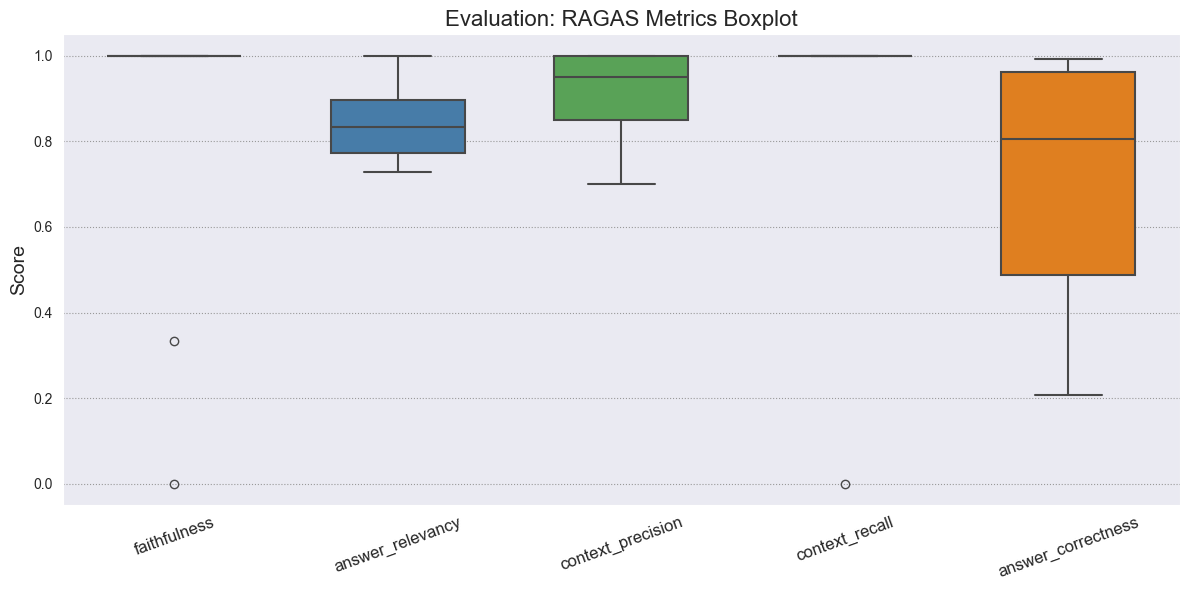

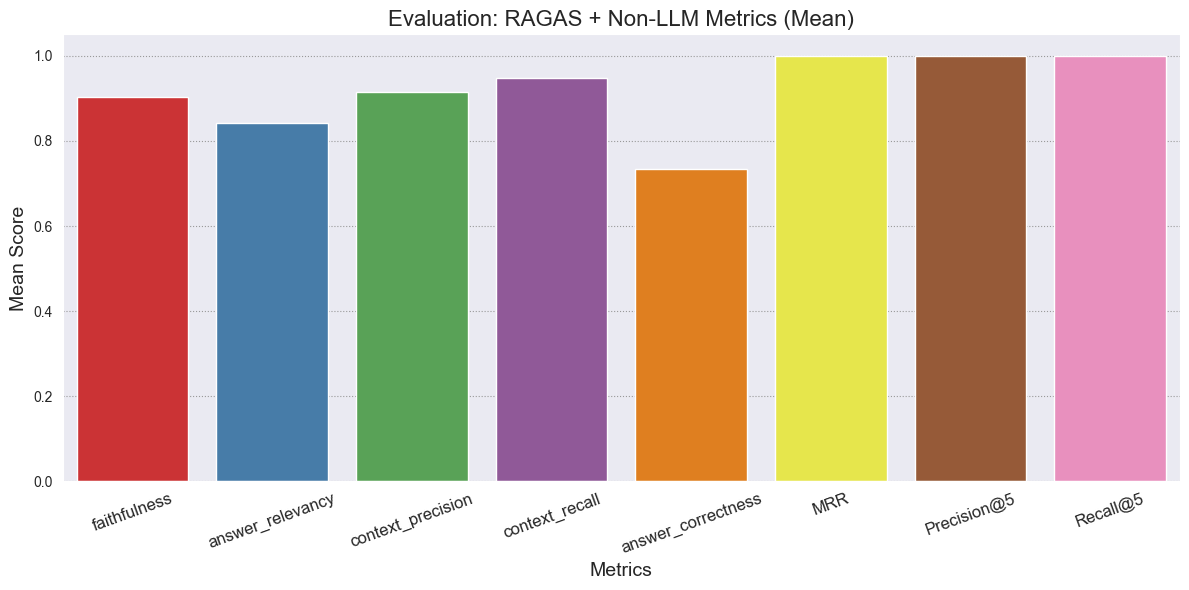

Durchschnittliche Antwortähnlichkeit: 0.9419080395988685


In [58]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.0,
    save_path="temp_0.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:41<00:00,  1.07s/it]


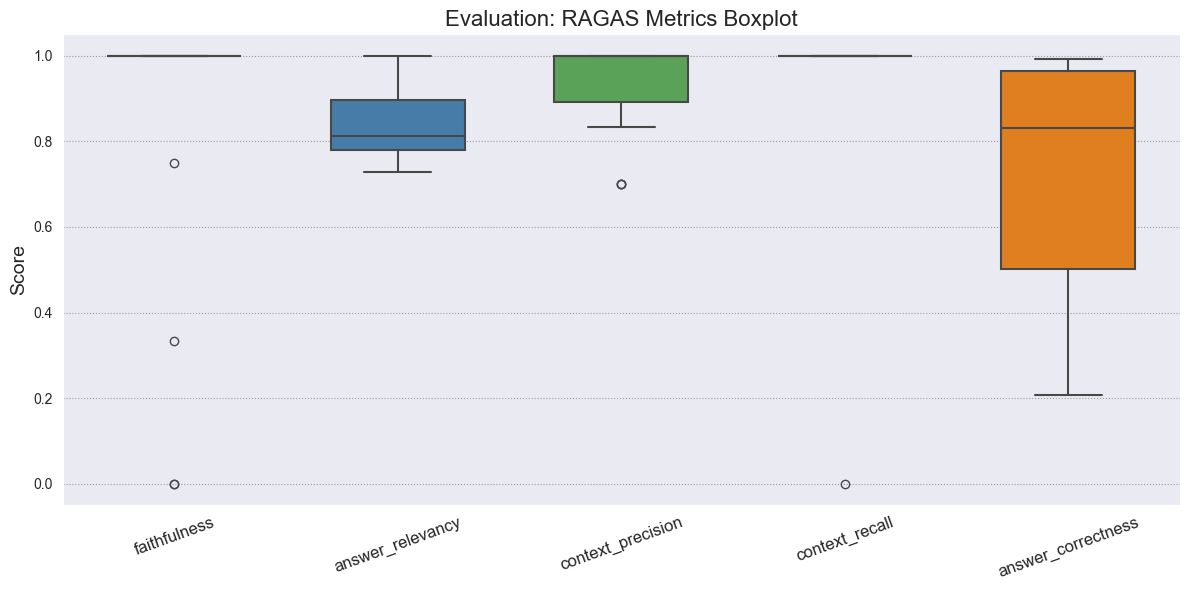

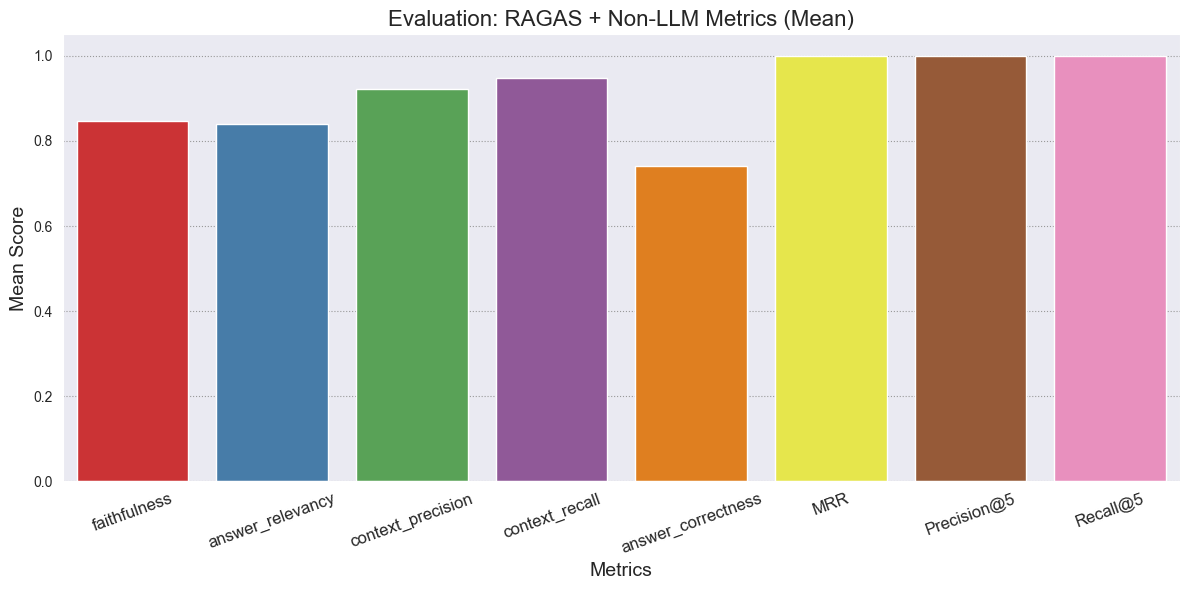

Durchschnittliche Antwortähnlichkeit: 0.944691514754571


In [59]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.5,
    save_path="temp_05.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:41<00:00,  1.07s/it]


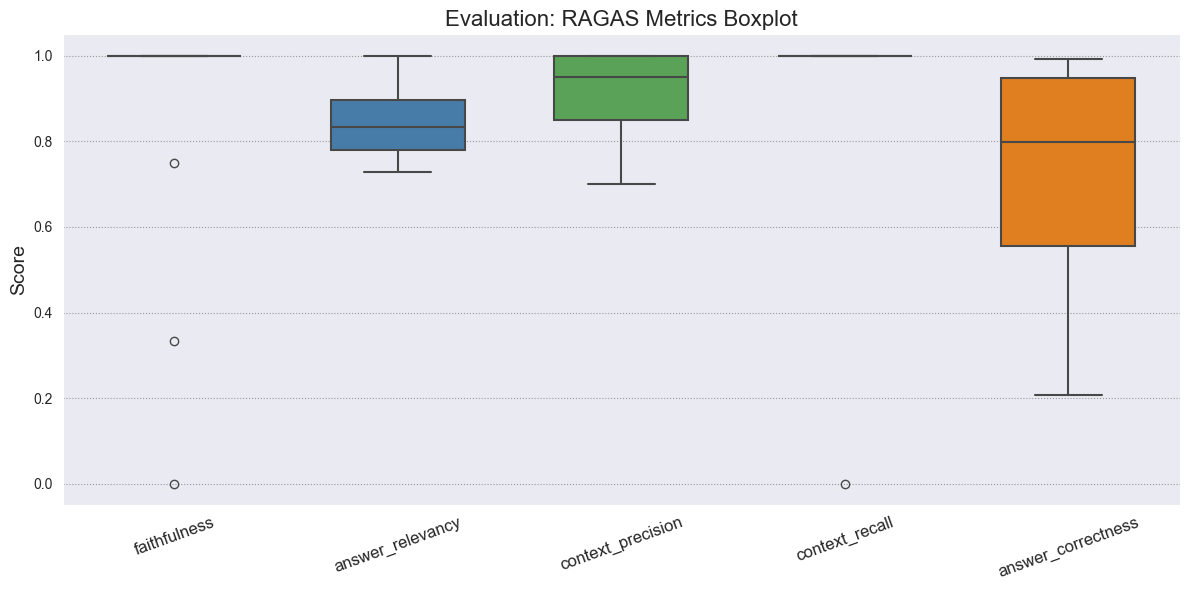

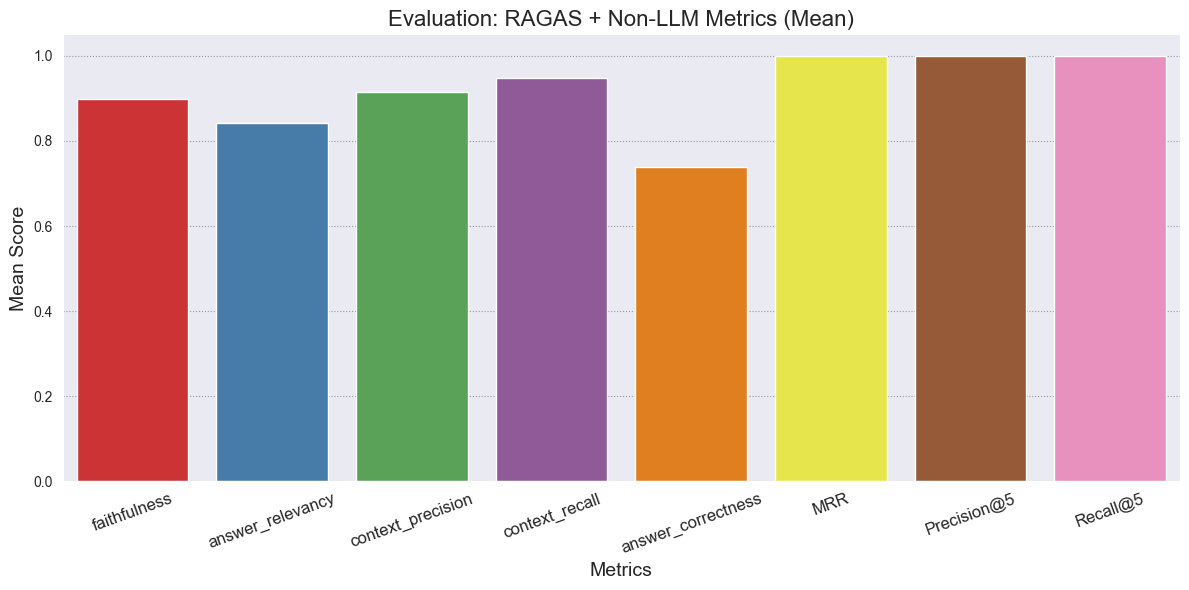

Durchschnittliche Antwortähnlichkeit: 0.9384527929291889


In [60]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=0.7,
    save_path="temp_07.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:39<00:00,  1.05s/it]


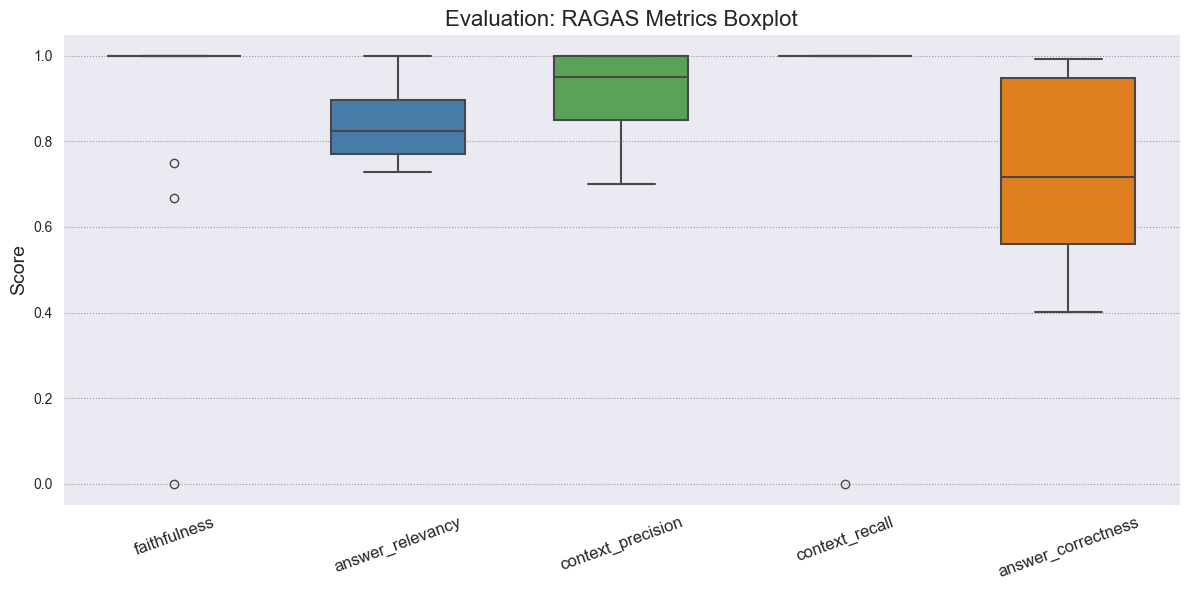

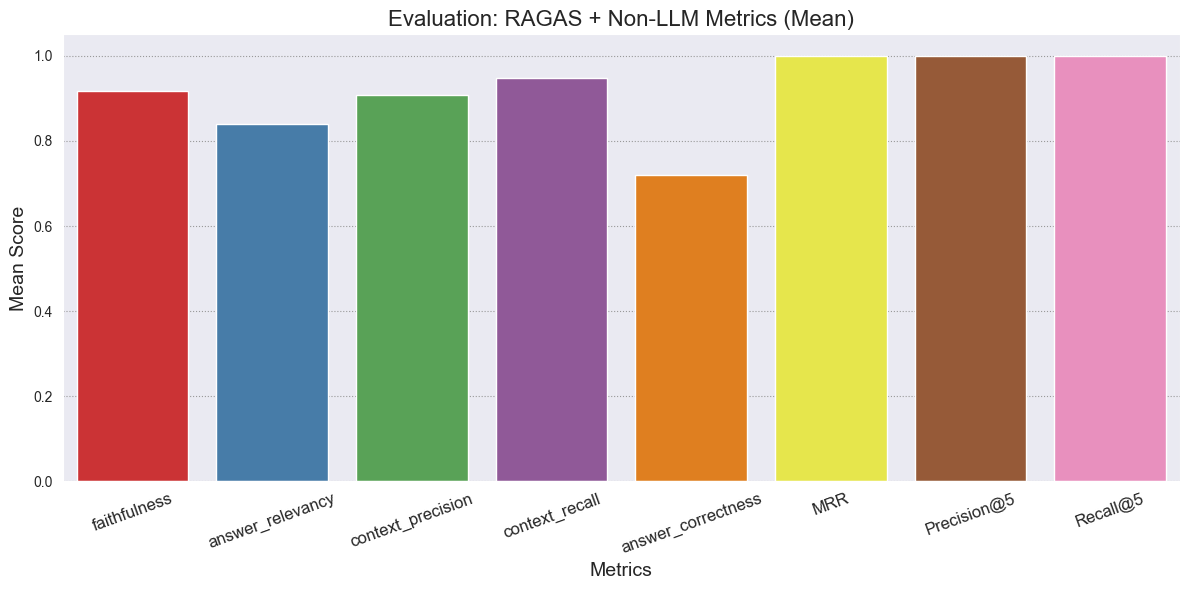

Durchschnittliche Antwortähnlichkeit: 0.924666588835609


In [61]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=1.0,
    save_path="temp_1.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

Evaluating: 100%|██████████| 95/95 [01:14<00:00,  1.28it/s]


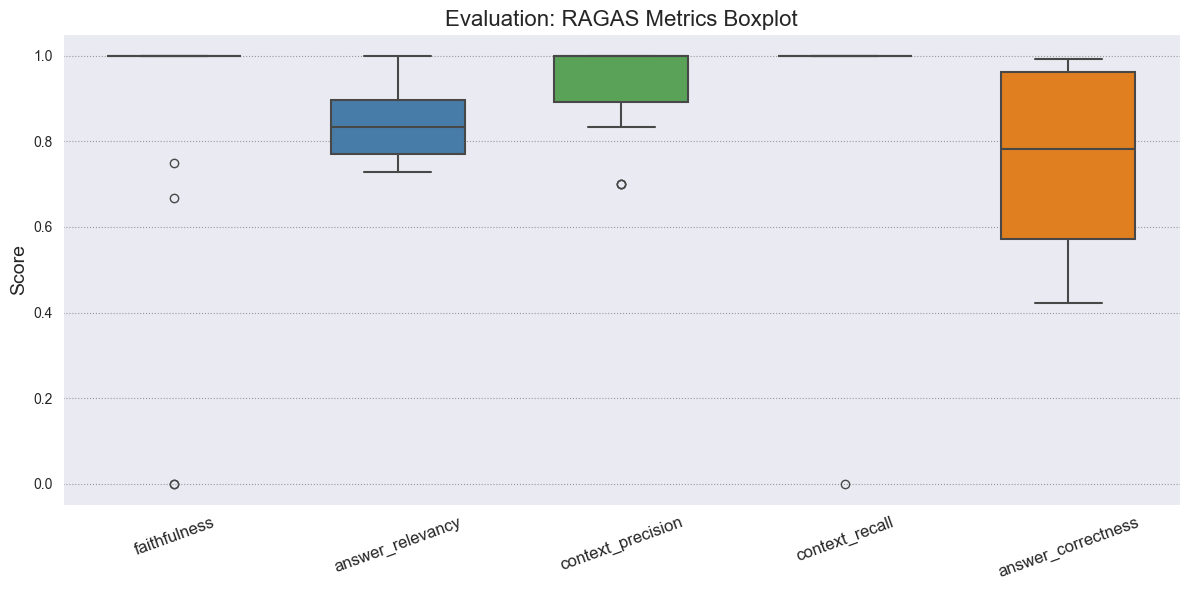

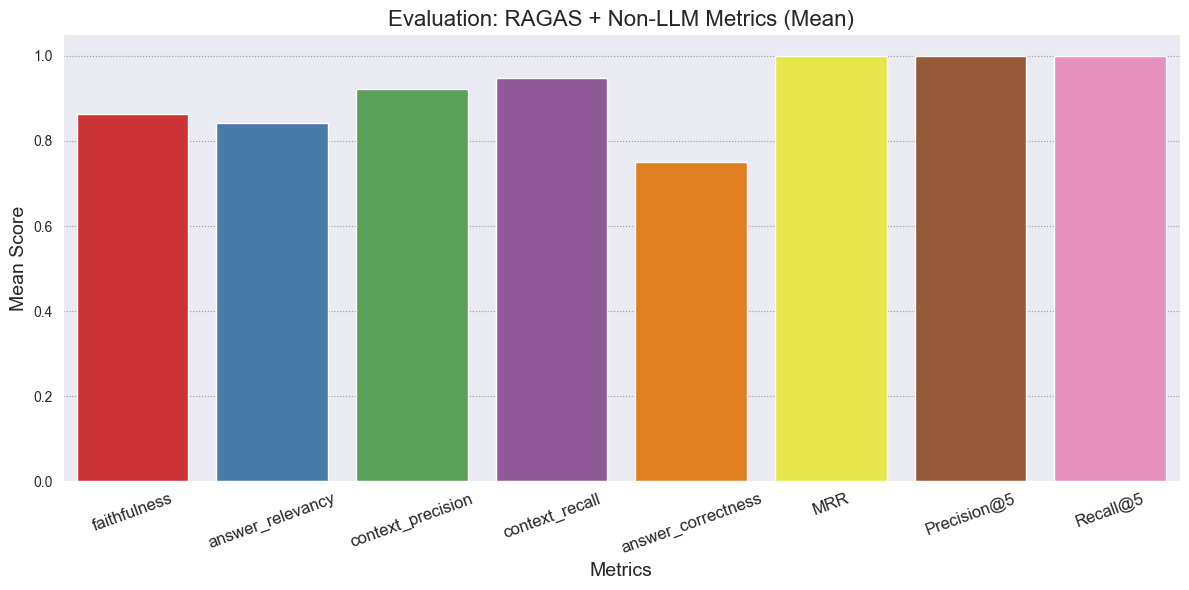

Durchschnittliche Antwortähnlichkeit: 0.9094658910848308


In [62]:
results, ragas_metrics, ir_metrics = evaluator.run(
    collection_name="chroma_senttrans_200_ip_ada-002",
    retriever_name="similarity_k5",
    prompt_name="simple",
    temperature=2.0,
    save_path="temp_2.csv",
    plot=True
)

# Berechne die Antwortähnlichkeit
results = evaluator.compute_similarity_to_gold(results)
print("Durchschnittliche Antwortähnlichkeit:", results["similarity_to_gold"].mean())

bei IR-Metriken hätte man noch den Treshold anpassen können (aus Zeitgründen nicht gemacht)

### Temperature Evaluation: Übersicht der Mittelwerte

| Temperature | Faithfulness | Answer Relevance | Context Precision | Context Recall | Answer Correctness | MMR  | Precision@k | Recall@k | Similarity to Gold |
|-------------|--------------|------------------|-------------------|----------------|---------------------|------|--------------|-----------|---------------------|
| 0.0         | 0.85         | 0.84             | 0.92              | 0.95           | 0.75                | 1.00 | 1.00         | 1.00      | 0.940                |
| 0.5         | 0.92         | 0.84             | 0.92              | 0.95           | 0.72                | 1.00 | 1.00         | 1.00      | 0.939                |
| 0.7         | 0.92         | 0.84             | 0.90             | 0.95           | 0.74                | 1.00 | 1.00         | 1.00      | 0.938                |
| 1.0         | 0.92         | 0.84             | 0.92              | 0.95           | 0.71                | 1.00 | 1.00         | 1.00      | 0.929                |
| 2.0         | 0.92         | 0.84             | 0.91              | 0.91           | 0.74                | 1.00 | 1.00         | 1.00      | 0.919                |


**Einfluss der Temperatureinstellung auf die Antwortqualität:**  
(Konfiguration: similarity + simple + k=5)  

Nach Auswahl der besten Kombination aus Retriever, Prompt und k-Wert wurde der Einfluss der Temperatureinstellung auf die Antwortqualität untersucht. Die Temperatur steuert die Zufälligkeit der LLM-Antworten: niedrige Werte führen zu deterministischen, reproduzierbaren Antworten, während höhere Temperaturen die Ausdrucksvarianz erhöhen, jedoch potenziell zu weniger konsistenten Ergebnissen führen.  

Die Mittelwerte der Metriken bleiben über alle Temperatureinstellungen hinweg auf hohem Niveau. Dennoch zeigen sich mit steigender Temperatur deutliche Unterschiede hinsichtlich Streuung, Stabilität und Antwortqualität.  

**Temperatur 0.0**  
Diese Einstellung erzielte den höchsten Wert bei Answer Correctness (0.75) sowie konstant hohe Kontextmetriken. Die Boxplots zeigten kaum Ausreißer, was auf eine hohe Konsistenz hindeutet. Diese Temperatur eignet sich besonders für verlässliche, faktenbasierte Antwortsysteme.

**Temperatur 0.5**  
Bei leicht gesenkter Answer Correctness (0.72) blieb die Gesamtqualität sehr hoch. Die Streuung nahm geringfügig zu, blieb jedoch in einem unkritischen Bereich. Diese Einstellung bietet eine gute Balance zwischen Konsistenz und Variabilität.

**Temperatur 0.7**  
Mit einem Mittelwert von 0.74 bei Answer Correctness und weiterhin hohen Werten in den Kontextmetriken zeigt sich diese Einstellung als robuster Kompromiss. Die leichte Zunahme der Streuung bleibt tolerierbar. Empfehlenswert, wenn etwas mehr Ausdrucksvielfalt gewünscht wird.

**Temperatur 1.0**  
Die Verteilung der Metriken weist erstmals eine deutlichere Streuung auf. Faithfulness und Context Precision zeigten vermehrt Ausreißer, Answer Correctness sank auf 0.71. Diese Einstellung ist nur bedingt für hochwertige QA-Anwendungen geeignet.

**Temperatur 2.0**  
Mit zunehmender Streuung in fast allen Metriken und einer tendenziell geringeren Stabilität ist diese Einstellung für standardisierte, verlässliche Anwendungen nicht mehr zu empfehlen. Der Fokus liegt hier klar auf maximaler Variabilität, auf Kosten der Antworttreue.

**Fazit:**  
Die Temperatureinstellung hat einen spürbaren Einfluss auf die Stabilität und Qualität der generierten Antworten. Besonders zuverlässig sind Temperaturen im Bereich von 0.0 bis 0.5, wobei 0.0 maximale Determiniertheit und 0.5 eine gute Balance zwischen Konstanz und Ausdrucksvielfalt bietet. Höhere Temperaturen können gezielt für explorative oder kreative Aufgaben eingesetzt werden, sind für konsistente QA-Systeme jedoch weniger geeignet.

### Manuell plausability Check

In [63]:
df_manuell_samples = pd.read_csv("../data_mc1/data_evaluierung/temp_05.csv")


for i, row in df_manuell_samples.iloc[:4, :6].iterrows():
    print(f"\n--- Sample {i} ---")
    for col in df_manuell_samples.columns[:6]:
        print(f"{col}:\n{row[col]}\n")



--- Sample 0 ---
question:
What is the EU’s Green Deal Industrial Plan?

relevant_text:
The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment that is conducive to increasing the European Union's manufacturing capacity of “net-zero” technologies, to improve the competitiveness of European industry.

relevant_text_llm:
['european commission introduces green deal industrial plan – pv magazine international : the european commission listed tax exemptions flexible aid and the promotion of local manufacturing among its key strategies for the green deal industrial plan. however the solarpower europe industry group has criticized the plan \' s lack of focus on solar. european commission president ursula von der leyen presents the green deal industrial plan. the european commission has published a new document on the green deal industrial plan that ec president ursula von der leyen announced at davos in mid january. the european counterpart to the us in

Zur qualitativen Absicherung der quantitativen Auswertung wurde zusätzlich ein manueller Plausibilitätscheck anhand ausgewählter Stichproben durchgeführt. Dabei wurden jeweils Frage, Antwort, Kontext und LLM-generierte Antwort inhaltlich geprüft.

Die vier analysierten Beispiele zeigen durchgehend hohe inhaltliche Übereinstimmung zwischen den Antworten und dem zugrundeliegenden Kontext. Besonders die LLM-Antworten spiegeln den Inhalt der Retrieval-Passagen treffend wider, ohne signifikante Abweichungen oder Halluzinationen.

Beispielhaft sei die erste Frage („Was ist der EU Green Deal Industrial Plan?“) genannt, bei der sowohl die extrahierte Antwort als auch die generierte LLM-Antwort wesentliche Kernaussagen des Kontextes korrekt zusammenfassen - inklusive Bezug zur US-Initiative IRA sowie den vier strategischen Säulen des Plans.

Auch bei faktischen Fragen, etwa zum Beginn der Kooperation zwischen GM und Honda (Juli 2013), konnte die Information klar im Kontext lokalisiert und korrekt wiedergegeben werden.

Das Beispiel zu ZeroAvia belegt darüber hinaus, dass auch komplexere Aussagen (Genehmigung für Testflüge durch die UK Civil Aviation Authority) präzise extrahiert wurden.

Insgesamt bestätigen diese Beispiele, dass die Retrieval-Pipeline relevante Textabschnitte zuverlässig extrahiert und das LLM diese kohärent zusammenfasst – ein wichtiger Indikator für die funktionale Qualität des Gesamtsystems.

## Fazit  


Grundsätzlich lässt sich nicht pauschal ein „bestes“ Modell bestimmen - die optimale Konfiguration hängt stets vom spezifischen Anwendungsfall ab, da jede Modellkombination individuelle Stärken und Schwächen aufweist. 

Beispiele für Anwendungsfälle und relevante Metrik-Schwerpunkte:

* Faktenbasierte Beantwortung in domänenspezifischen Wissenssystemen (zB. Cleantech-FAQs, Compliance-Assistenz):  
Faithfulness (Antwort muss belegbar sein), Answer Correctness, Recall@k (wichtige Inhalte dürfen nicht fehlen)

* Schnelle Informationssuche / Recherche-Assistenz (zB. journalistische Tools, technische Dokumentation):   
Context Recall (alle relevanten Infos finden), Precision@k (wenig irrelevante Treffer), Answer Relevance

* Chatbots oder Dialogsysteme für Endnutzer (zB. Kundenservice, interne Wissens-Hilfe):  
Answer Relevance (Antwort passt zur Frage), Context Precision (kein überladener Kontext), MRR (Antwort sollte früh im Retrieval liegen)

* Kreative Assistenzsysteme (zB. Ideengenerierung, Textentwürfe mit Faktenbezug):  
Moderate Faithfulness (Kreativität vs. Faktentreue),Answer Relevance, Temperatur-Einstellungen als entscheidender Hyperparameter

---

### Empfohlene ausgewogene Systemkonfiguration:   

Die Evaluation erfolgte auf Grundlage verschiedener Qualitätsmetriken sowie durch ergänzende Visualisierungen mittels Boxplots. Dabei zeigte sich, dass die folgenden Komponenten in Kombination die "besten" Gesamtergebnisse lieferten:  

* **Embedding-Modell: text-embedding-ada-002**  
Dieses Modell überzeugte durch konstant hohe Werte in allen embeddingsensitiven Metriken wie Context Recall, Similarity to Gold und Answer Correctness. Im Vergleich zum neueren text-embedding-3-large zeigte es eine höhere Stabilität und geringere Streuung – unabhängig von Retriever oder Splitter.

* **Retriever: similarity**  
Der klassische Similarity-Retriever war in der Kombination mit einfachem Prompting und angepasstem k-Wert der zuverlässigste Ansatz. Er erreichte eine sehr hohe Trefferquote (Recall@k = 1.00) und eine ausgezeichnete Kontextpräzision.

* **Prompting: simple**  
Im Vergleich zu chain-of-thought (cot) zeigte der einfache Prompt stabilere Ergebnisse bei geringerer Streuung. Cot-Prompts brachten keinen nennenswerten Vorteil im Hinblick auf die generativen Metriken, führten jedoch häufiger zu Ausreißern.

* **Temperature: 0.5**  
Diese Einstellung bietet eine optimale Balance zwischen Ausdrucksvielfalt und Antwortkonsistenz. Sie zeigte durchweg stabile Werte bei allen Metriken, ohne die deterministische Kontrolle vollständig aufzugeben.

## Weitere Überlegungen

Im Rahmen dieser Arbeit wurde ein grundlegendes Retrieval-Augmented Generation (RAG)-System umgesetzt und evaluiert. Darüber hinaus gibt es weitere Konzepte und Verfahren, deren Einbeziehung zusätzliche Erkenntnisse bringen könnte. Die folgenden Aspekte wurden im Projekt nicht implementiert, könnten jedoch in einer weiterführenden Analyse evaluiert werden::

- **BM25 (Best Matching 25):** Ein klassischer, auf Termfrequenz basierender Retrieval-Algorithmus, der als Basislinie für moderne Dense Retriever dienen kann.

- **Cross-Encoder:** Während Dense Retriever typischerweise separate Encodierungen für Query und Dokumente nutzen, bewertet ein Cross-Encoder die Relevanz durch gemeinsame Verarbeitung beider Texte. Cross-Encoder bieten meist höhere Genauigkeit, sind aber rechenintensiver.

- **Step-Back Prompting – Refining Reasoning via Abstraction:** Dieses Verfahren verbessert die Modellleistung bei komplexen Aufgaben, indem es zunächst eine abstrahierte (vereinfachte) Version des Problems erzeugt und darauf basierend die ursprüngliche Frage löst.

- **Zero-Shot, One-Shot und Few-Shot Learning (Three-Shot):** Die Untersuchung verschiedener Prompting-Strategien – insbesondere Zero-Shot (ohne Beispiel), One-Shot (ein Beispiel) und Few-Shot (z. B. drei Beispiele) – könnte Aufschluss darüber geben, wie sensitiv das Modell auf Kontextinformationen reagiert.

- **Threshold bei IR-Metriken:** Die Einführung eines Relevanz-Schwellenwerts (Threshold) bei Information-Retrieval-Metriken wie z. B. Precision@k oder Recall@k erlaubt feinere Steuerung der Evaluation. Dies ist insbesondere relevant, wenn man zwischen „gerade noch relevant“ und „vollständig relevant“ unterscheiden möchte – etwa bei der Bewertung semantisch naher, aber nicht passgenauer Antworten.